In [1]:
import os
import time
import math
import pickle
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import warnings
import torch
import torch.optim as optim
import scipy.stats

from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold
from category_encoders import TargetEncoder, OneHotEncoder
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from math import sqrt
from datetime import datetime

In [2]:
from src.utils import check_stationarity, get_scaler, get_sample_weight, load_word2vec_embeddings, get_torch_optimizer, dummy_lagged_df, mase_loss, mean_absolute_scaled_error, compute_mase_scale, get_torch_criterion, get_confidence_interval, winkler_score
from src.arima import grid_search_arima
from src.sarimax import grid_search_sarimax
from src.ml_model import grid_search_ml, get_model, one_step_prediction as one_step_ml_prediction
from src.rnn import train_rnn, eval_rnn, one_step_prediction, grid_search_rnn, TimeSeriesDataset, ForecastModel

# Forecasting Visitor Arrivals
Full train on Covid period, test on 2022 data (Experiment 2)

## Baseline of simple SARIMA 

In [3]:
country_list = ['Canada', 'Chile', 'Mexico', 'Chinese Taipei', 'Hong Kong SAR', 'Japan', 
                'Korea (ROK)', 'Macao, China', 'Maldives', 'Cambodia', 'Indonesia', 'Singapore', 
                'New Zealand', 'USA', 'Thailand', 'Turkey', 'Australia', 'Hawaii', 'Austria', 'Czech']

imputed_dir = './data/imputed/'

In [4]:
aus_df = pd.read_csv(os.path.join(imputed_dir, 'Chile.csv'))
aus_df['Date'] = pd.to_datetime(aus_df['Date'])
# aus_df = aus_df[aus_df['Date'] < '2020-01-01']
aus_df = aus_df.set_index('Date')

In [5]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'FSI', 'FXAgainstChina', 'Temperature', 'Precipitation']
target = 'VisitorArrivals'

train_df = aus_df[[target] + candidates]
train_df = train_df.loc[train_df[target].first_valid_index(): train_df[target].last_valid_index()]
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [6]:
len(test_y) / (len(train_y) + len(test_y))

0.09022556390977443

In [7]:
test_y

Date
2022-02-01     233.0
2022-03-01     294.0
2022-04-01     380.0
2022-05-01     404.0
2022-06-01     430.0
2022-07-01     537.0
2022-08-01     648.0
2022-09-01     579.0
2022-10-01     822.0
2022-11-01    1023.0
2022-12-01    1372.0
2023-01-01     872.0
Name: VisitorArrivals, dtype: float64

/scratch/zt00296/Projects/tourism-forecasting/src/utils.py:46: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The series isn't stationary


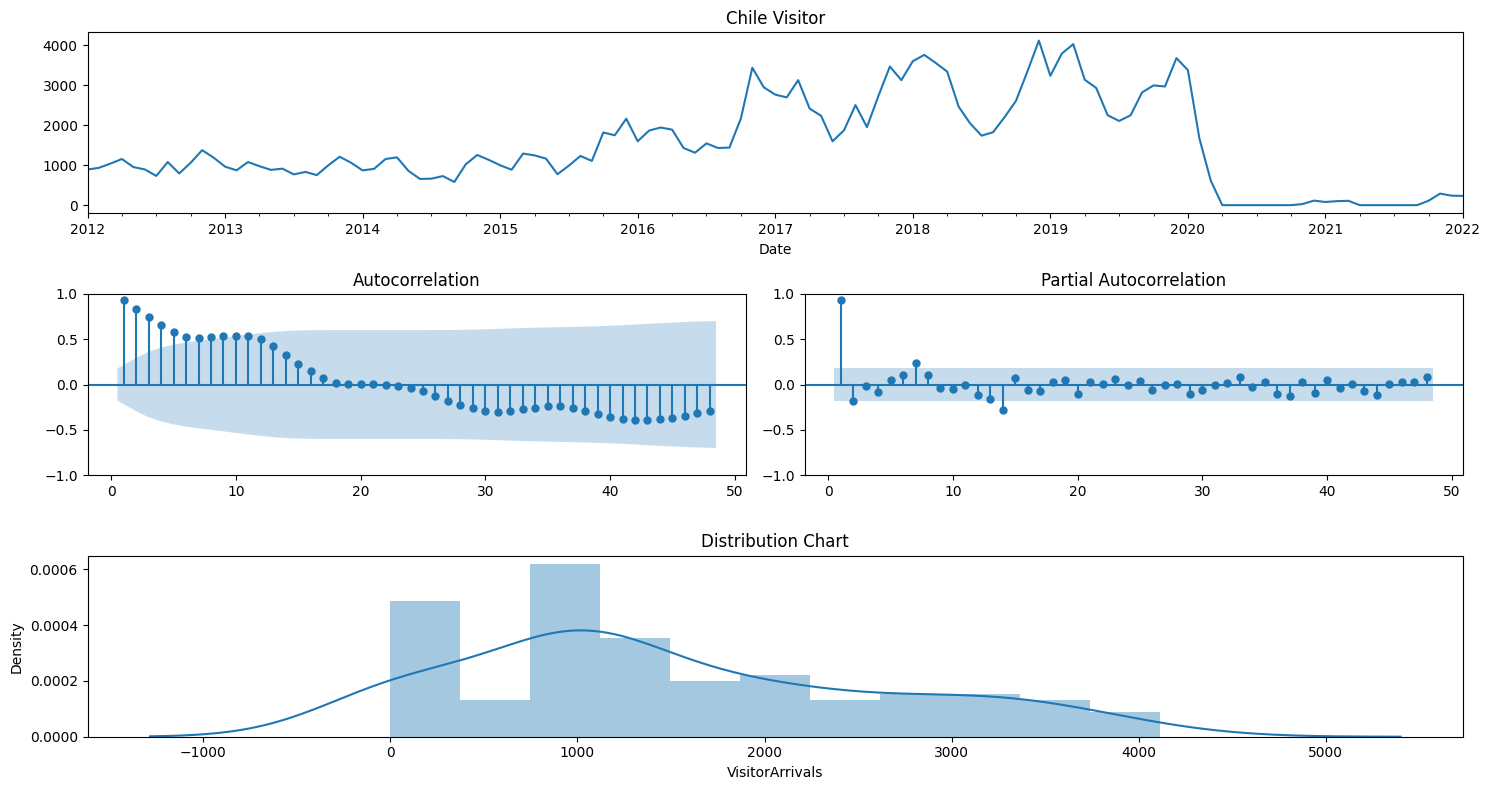

In [8]:
# find parameter analytically
check_stationarity(train_y.dropna(), title='Chile Visitor')

In [ ]:
best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, cv=True)
print(best_param, best_rmse)
sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
result = sarima_model.fit(disp=False)
pred = result.forecast(len(test_y))
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [16]:
sarima_pred, all_y, y_mase_scales = [], [], []
for c in country_list:
    f = c + '.csv'
    print('processing', f)
    df = pd.read_csv(os.path.join(imputed_dir, f))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] < '2023-01-01']
    df = df.set_index('Date')
    train_y = df[target]
    train_y = train_y.loc[train_y.first_valid_index(): train_y.last_valid_index()]
    for i in range(12, 0, -1):
        y_mase_scales.append(compute_mase_scale(train_y.iloc[:-i].values))
    train_y, test_y = train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, cv=True, init_repeat=False)
    print(best_param, best_rmse, best_r2)
    sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
    result = sarima_model.fit(disp=False)
    pred = result.forecast(len(test_y))
    sarima_pred.append(pred)
    all_y.append(test_y)
sarima_pred, all_y = pd.concat(sarima_pred).values, pd.concat(all_y).values
y_mase_scales = np.asarray(y_mase_scales)

processing Canada.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)


[(3, 0, 1), (1, 0, 0, 12), 'n'] 2435.635210783837 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Chile.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(2, 0, 1), (1, 0, 0, 12), 'c'] 199.28710246471417 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Mexico.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 0, 1), (1, 0, 1, 12), 'c'] 2890.194235809998 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Chinese Taipei.csv
[(3, 0, 1), (1, 0, 1, 12), 'c'] 27908.086352902035 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Hong Kong SAR.csv
[(1, 0, 1), (0, 0, 0, 12), 'n'] 920822.8423426916 None
processing Japan.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(2, 1, 1), (1, 0, 1, 12), 'c'] 80982.92298387477 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


processing Korea (ROK).csv
[(1, 1, 1), (0, 0, 0, 12), 'n'] 145793.28993589815 None
processing Macao, China.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(2, 0, 1), (1, 0, 1, 12), 'c'] 336542.9939849793 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Maldives.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)


[(3, 0, 1), (1, 0, 1, 12), 'c'] 11406.80827146774 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Hawaii.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(1, 0, 1), (1, 0, 0, 12), 'c'] 431.4254249673331 None
processing Austria.csv
[(3, 0, 0), (1, 0, 0, 12), 'n'] 2935.49631827309 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Czech.csv
[(3, 1, 1), (1, 0, 1, 12), 'c'] 4580.939909141591 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


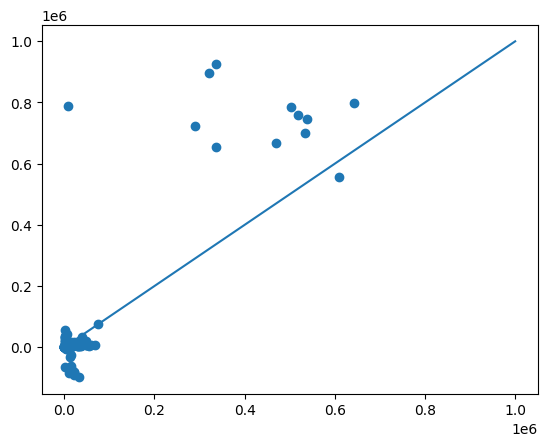

In [18]:
plt.scatter(all_y, sarima_pred)
plt.plot((0, 1000000), (0, 1000000))

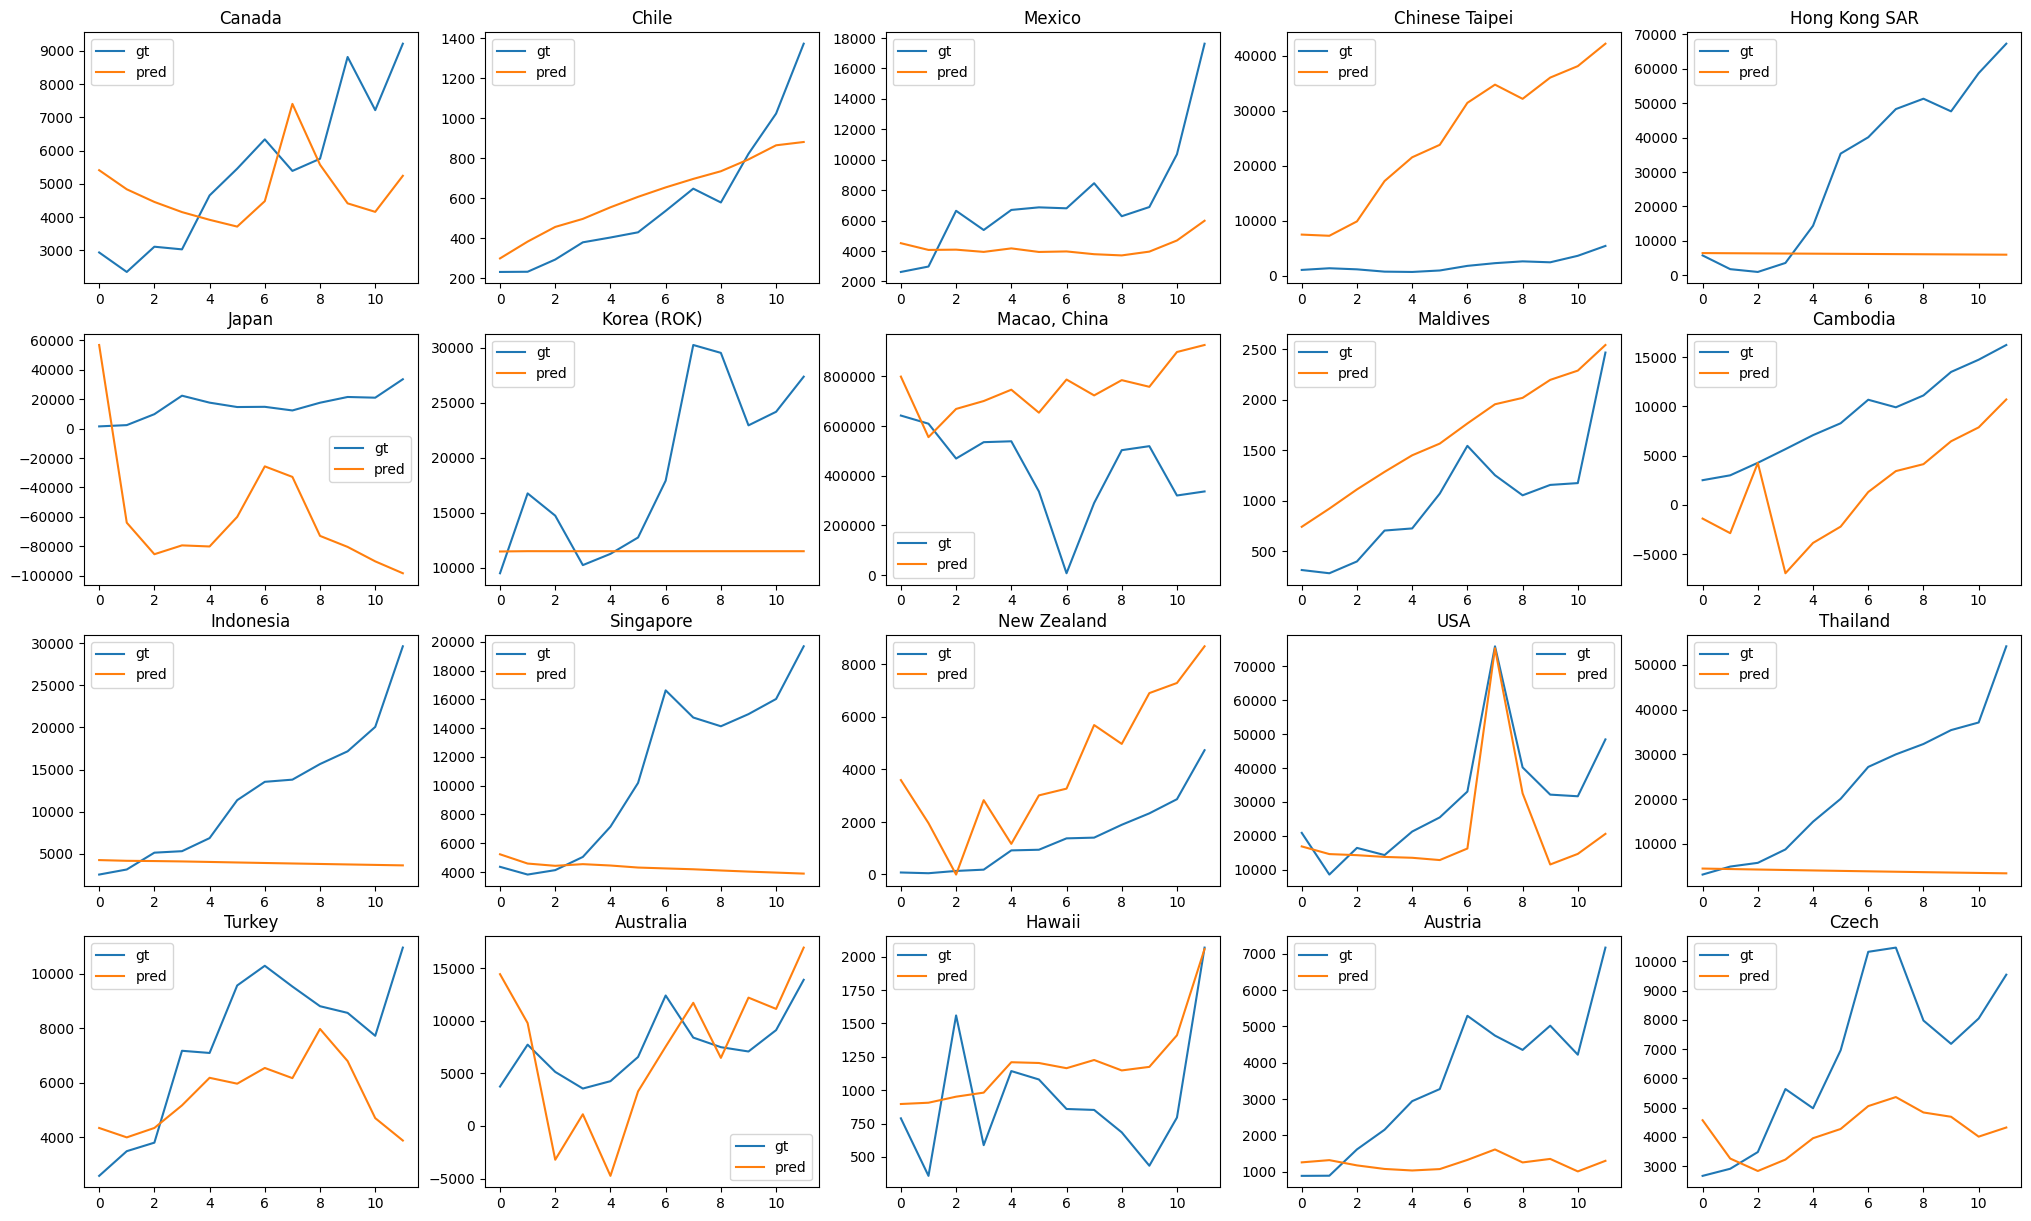

In [19]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(sarima_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [20]:
baseline_rmse = sqrt(mean_squared_error(all_y, sarima_pred))
baseline_r2 = r2_score(all_y, sarima_pred)
baseline_mae = mean_absolute_error(all_y, sarima_pred)
baseline_mape = mean_absolute_percentage_error(all_y, sarima_pred)
baseline_mase = mean_absolute_scaled_error(all_y, sarima_pred, y_mase_scales)
print(f'Baseline SARIMA RMSE: {baseline_rmse:.5f}\nBaseline SARIMA R2: {baseline_r2:.5f}'
      f'\nBaseline SARIMA MAE: {baseline_mae:.5f}\nBaseline SARIMA MAPE: {baseline_mape:.5f}\nBaseline SARIMA MASE: {baseline_mase:.5f}')

Baseline SARIMA RMSE: 90885.33651
Baseline SARIMA R2: 0.15415
Baseline SARIMA MAE: 27511.23941
Baseline SARIMA MAPE: 2.60370
Baseline SARIMA MASE: 0.44727


# Preprocessing Data

In [294]:
target = 'VisitorArrivals'
candidates = ['FXAgainstChina', 'CovidCases', 'CovidDeaths', 'FSI',
               'GDPPerCap', 'GDP', 'Population',
               'TravelPolicy', 'Temperature', 'Precipitation', 'GlobalCovidTrend',
               'DistFromChina', 'Country', 'GDPRatioChina',
               'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
               'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
               'ChinaGDP']
def load_data(country='Japan', csv_dir='./data/imputed', log_transform=True, dropna=True, remove=False):
    df = pd.read_csv(os.path.join(csv_dir, f'{country}.csv'))
    if dropna:
        df = df.iloc[df['VisitorArrivals'].first_valid_index():].reset_index(drop=True)
    if log_transform:
        df['VisitorArrivals'] = np.log1p(df['VisitorArrivals'])
    df['Date'] = pd.to_datetime(df['Date'])
    if remove:
        df = df[df['Date'] < '2023-01-01']
    df = df.set_index('Date').asfreq('MS')
    return df[candidates + [target]]

In [295]:
from src.utils import get_seasonal_component, inverse_target
#load all data and decomposed precovid seasonality
def load_and_preprocess_all(test_size=0, deduct_seasonality=True, single_x_scaler=False, single_y_scaler=False, scaler_type='standard', remove=False):
    all_data = {country: load_data(country, remove=remove) for country in country_list}
    all_decomposed_seasonal = {country: seasonal_decompose(df[df.index < ('2019-06-01' if country in ['Chinese Taipei', 'Hong Kong SAR'] else '2020-01-01')]['VisitorArrivals'], period=12) for country, df in all_data.items()}
    
    x_scaler, y_scaler = {}, {}
    #some feature engineering and processing
    for country in country_list:
        all_data[country]['Popularity'] = all_data[country]['VisitorArrivals'].median()
        all_data[country]['Unrest'] = 0.
        all_data[country]['TravelRestriction'] = (all_data[country][['TravelPolicy', 'ChinaConfinementPolicy', 'ChinaMovementPolicy']] > 0).all(axis=1).astype(int)
        
        all_data[country]['Year'] = all_data[country].index.year
        all_data[country]['MonthSin'] = np.sin(2 * np.pi * (all_data[country].index.month - 1) / 12.0)
        all_data[country]['MonthCos'] = np.cos(2 * np.pi * (all_data[country].index.month - 1) / 12.0)
        
        if deduct_seasonality:
            # remove seasonality
            seasonal_component = get_seasonal_component(all_decomposed_seasonal[country], len(all_data[country]))
            assert len(seasonal_component) == len(all_data[country])
            seasonal_component.index = all_data[country].index
            seasonal_component[(seasonal_component.index >= '2020-01-01') & (seasonal_component.index <= '2023-01-01')] = 0 # no seasonality during covid

            all_data[country]['VisitorArrivals'] -= seasonal_component
            
        # 1. taiwan ban china starting september 2019 - january 2024 election
        # 2. hong kong protest starting august 2019 end mid 2020
        # 3. china ban korea starting march 2017 - nov 2017
        # 4. singapore and thailand april 2014 - jan 2015
        # 5. sars world april 2003 - july 2003
        # 6. hawaii and USA trump presidential between november 2016 to january 2021
        # 7. turkey coup 2016
        if country == 'Chinese Taipei':
            all_data[country].loc[(all_data[country].index >= '2019-09-01') & (all_data[country].index <= '2024-02-01'), 'TravelRestriction'] = 1
        elif country == 'Hong Kong SAR':
            all_data[country].loc[(all_data[country].index >= '2019-08-01') & (all_data[country].index <= '2020-06-01'), 'Unrest'] = 1.
        elif country == 'Korea (ROK)':
            all_data[country].loc[(all_data[country].index >= '2017-03-01') & (all_data[country].index <= '2017-11-01'), 'TravelRestriction'] = 1
        elif country in ['Singapore', 'Thailand']:
            all_data[country].loc[(all_data[country].index >= '2014-04-01') & (all_data[country].index <= '2015-01-01'), 'Unrest'] = 1.
        elif country in ['Hawaii', 'USA']:
            all_data[country].loc[(all_data[country].index >= '2016-11-01') & (all_data[country].index <= '2021-01-01'), 'Unrest'] = 0.5
        elif country == 'Turkey':
            all_data[country].loc[(all_data[country].index >= '2015-12-01') & (all_data[country].index <= '2017-02-01'), 'Unrest'] = 1.
            
        all_data[country].loc[(all_data[country].index >= '2003-04-01') & (all_data[country].index <= '2003-07-01'), 'Unrest'] = 1. # SARS

        # assume covid case and deaths exponentially reduce
        for c in ['CovidCases', 'CovidDeaths']:
            all_data[country][c] = all_data[country][c].fillna(all_data[country][c].ffill()[all_data[country][c].isnull()].mul((1/2)**(all_data[country][c].groupby(all_data[country][c].notnull().cumsum()).cumcount()), 0)).round()
    
    country_feat = ['GDPPerCap', 'GDP', 'Population', 'CovidCases', 'CovidDeaths', 
                    'Temperature', 'Precipitation',]  # only normalize country specific features, other features are universal which will be normalize separately
    if single_x_scaler:
        temp_df = pd.concat([all_data[country][country_feat].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True)  # only fit on train that is valid
        x_scaler = get_scaler(scaler_type)
        x_scaler.fit(temp_df)
        for country in country_list:
            all_data[country][country_feat] = x_scaler.transform(all_data[country][country_feat])
    else:
        for country in country_list:
            country_x_scaler = get_scaler(scaler_type)
            country_x_scaler.fit(all_data[country][country_feat].iloc[:all_data[country][target].notna().sum()-test_size])
            all_data[country][country_feat] = country_x_scaler.transform(all_data[country][country_feat])
            x_scaler[country] = country_x_scaler
    
    universal_feat = ['FXAgainstChina', 'FSI', 'Year', 'MonthSin', 'MonthCos', 'Unrest',
                       'TravelPolicy', 'GlobalCovidTrend',
                       'DistFromChina', 'GDPRatioChina',
                       'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                       'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                       'ChinaGDP', 'Popularity', 'TravelRestriction']
    universal_x_scaler = get_scaler(scaler_type)
    temp_df = pd.concat([all_data[country][universal_feat].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True)
    universal_x_scaler.fit(temp_df)
    for country in country_list:
        all_data[country][universal_feat] = universal_x_scaler.transform(all_data[country][universal_feat])
        
    if single_y_scaler:
        temp_df = pd.concat([all_data[country][[target]].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True) # only fit on train
        y_scaler = get_scaler(scaler_type)
        y_scaler.fit(temp_df)
        for country in country_list:
            all_data[country][[target]] = y_scaler.transform(all_data[country][[target]])
    else:
        for country in country_list:
            country_y_scaler = get_scaler(scaler_type)
            country_y_scaler.fit(all_data[country][[target]].iloc[:all_data[country][target].notna().sum()-test_size])
            all_data[country][[target]] = country_y_scaler.transform(all_data[country][[target]])
            y_scaler[country] = country_y_scaler
    
    return all_data, all_decomposed_seasonal, x_scaler, universal_x_scaler, y_scaler

In [296]:
df = load_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 1997-01-01 to 2024-07-01
Freq: MS
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FXAgainstChina            331 non-null    float64
 1   CovidCases                319 non-null    float64
 2   CovidDeaths               319 non-null    float64
 3   FSI                       331 non-null    float64
 4   GDPPerCap                 331 non-null    float64
 5   GDP                       331 non-null    float64
 6   Population                331 non-null    float64
 7   TravelPolicy              331 non-null    float64
 8   Temperature               331 non-null    float64
 9   Precipitation             331 non-null    float64
 10  GlobalCovidTrend          331 non-null    float64
 11  DistFromChina             331 non-null    float64
 12  Country                   331 non-null    object 
 13  GDPRatioChina             331 non-nul

<Axes: >

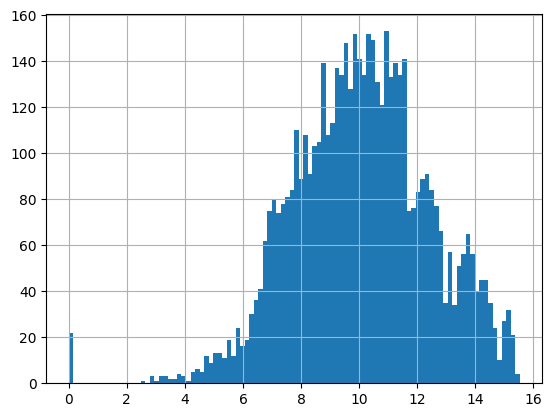

In [297]:
pd.concat([load_data(country, log_transform=True)['VisitorArrivals'] for country in country_list], ignore_index=True).hist(bins=100)

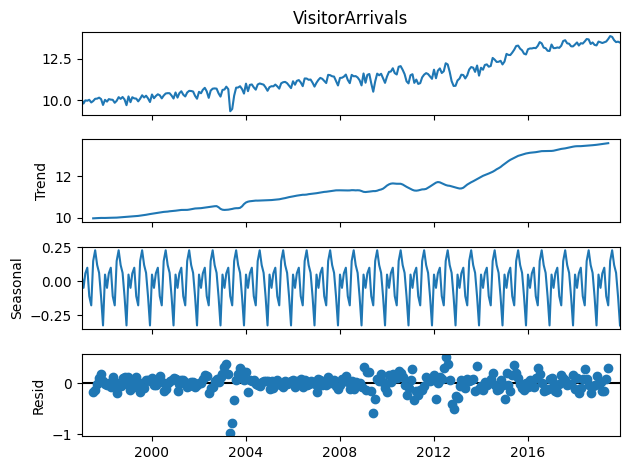

In [298]:
res = seasonal_decompose(df[df.index < '2020-01-01']['VisitorArrivals'], period=12)
fig = res.plot()

In [299]:
seasonal_component = get_seasonal_component(res, len(df))
seasonal_component.index = df.index
seasonal_component[(seasonal_component.index >= '2020-01-01') & (seasonal_component.index <= '2023-01-01')] = 0 # no seasonality during covid

In [300]:
from statsmodels.tsa.filters.filtertools import convolution_filter
filt = np.array([0.5] + [1] * (12 - 1) + [0.5]) / 12
trend = convolution_filter(df['VisitorArrivals'].values, filt, 2)
detrended = df['VisitorArrivals'].values - trend
resid = detrended - seasonal_component.values

In [301]:
df['Trend'] = trend
df['Seasonal'] = seasonal_component
df['Resid'] = resid

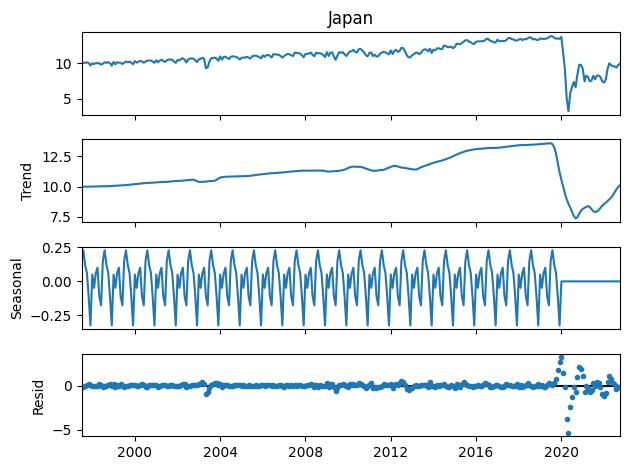

In [302]:
temp_df = df[['VisitorArrivals', 'Trend', 'Resid', 'Seasonal']].dropna().rename(columns={'VisitorArrivals': 'Japan'})
xlim = (temp_df.index[0], temp_df.index[-1])
series = [(temp_df['Japan'], 'Observed'), (temp_df['Trend'], 'Trend'), (temp_df['Seasonal'], 'Seasonal'), (temp_df['Resid'], 'residual')]
fig, axs = plt.subplots(len(series), 1, sharex=True)
for i, (ax, (series, def_name)) in enumerate(zip(axs, series)):
    if def_name != "residual":
        ax.plot(series)
    else:
        ax.plot(series, marker="o", linestyle="none", markersize=3)
        ax.plot(xlim, (0, 0), color="#000000", zorder=-3)
    name = getattr(series, "name", def_name)
    title = ax.set_title if i == 0 else ax.set_ylabel
    title(name)
    ax.set_xlim(xlim)
fig.tight_layout()

<Axes: xlabel='Date', ylabel='Processed Tourism Arrivals'>

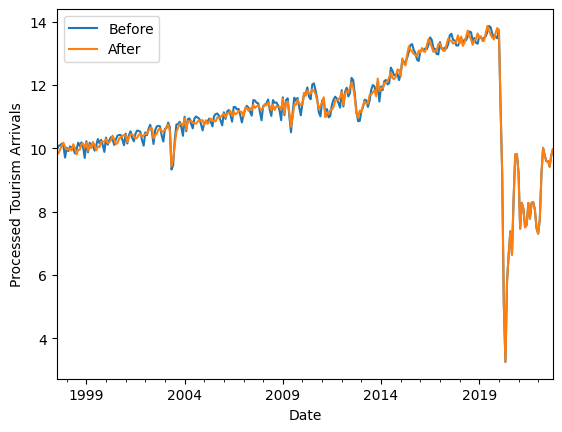

In [303]:
temp_df = df[['VisitorArrivals', 'Trend', 'Resid', 'Seasonal']].dropna()
temp_df['Before'] = temp_df['VisitorArrivals']
temp_df['After'] = temp_df['Trend'] + temp_df['Resid']
temp_df[['Before', 'After']].plot(ylabel='Processed Tourism Arrivals', fontsize=10)

In [304]:
deduct_seasonality = True
single_x_scaler = False
single_y_scaler = False
all_data, all_decomposed_seasonal, x_scaler, universal_x_scaler, y_scaler = load_and_preprocess_all(test_size=12, deduct_seasonality=deduct_seasonality, single_x_scaler=single_x_scaler, single_y_scaler=single_y_scaler, remove=False)

In [34]:
# longest input sequence
np.unique([df['VisitorArrivals'].notna().sum() for country, df in all_data.items()], return_counts=True)

(array([120, 132, 174, 216, 236, 240, 252, 276, 288, 300, 312, 324, 336,
        408]),
 array([1, 2, 1, 1, 1, 1, 3, 1, 2, 2, 1, 1, 1, 2]))

In [35]:
# longest required forecast
np.unique([df['VisitorArrivals'].isna().sum() for country, df in all_data.items()], return_counts=True)

(array([0]), array([20]))

## Regression

In [36]:
country_feat = [#'GDPPerCap', 'GDP', 'Population', 
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'CovidCases', 'CovidDeaths', 'TravelPolicy', 'GlobalCovidTrend',
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction']
target = 'VisitorArrivals'

In [41]:
# repeat for all countries
reg_pred, all_y = [], []
for country, df in all_data.items():
    print('processing', country)
    df = df.copy().dropna()
    train_x, train_y = df[country_feat + universal_feat], df[target]
    train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)
    train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    best_param, best_mae = grid_search_ml(train_x, train_y, score_function=mean_absolute_error, preprocess=['nopreprocess'],#sample_weight=sample_weight,
                                           additional_params={'rf': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)],
                                                              'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
                                                              'xgb': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)]})
    print(best_param, best_mae)
    model = get_model(best_param[0])
    model = model.set_params(**best_param[2])
    scaler = get_scaler(best_param[1])
    train_x_ = scaler.fit_transform(train_x)
    test_x_ = scaler.transform(test_x)
    model.fit(train_x_, train_y,)# sample_weight=sample_weight)
    pred = model.predict(test_x_)
    
    # reg_pred.append(inverse_target(pred, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0., 
    #                                y_scaler if single_y_scaler else y_scaler[country]))
    # all_y.append(inverse_target(test_y, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0., 
    #                             y_scaler if single_y_scaler else y_scaler[country]))
    reg_pred.append(inverse_target(pred, 0., y_scaler if single_y_scaler else y_scaler[country]))
    all_y.append(inverse_target(test_y, 0., y_scaler if single_y_scaler else y_scaler[country]))
    
reg_pred, all_y = np.concatenate(reg_pred), np.concatenate(all_y)

processing Canada
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 0.5210131806828739
processing Chile
('xgb', 'nopreprocess', {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'ma

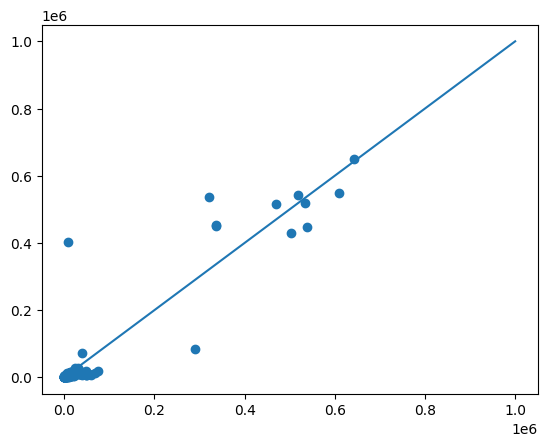

In [42]:
plt.scatter(all_y, reg_pred)
plt.plot((0, 1000000), (0, 1000000))

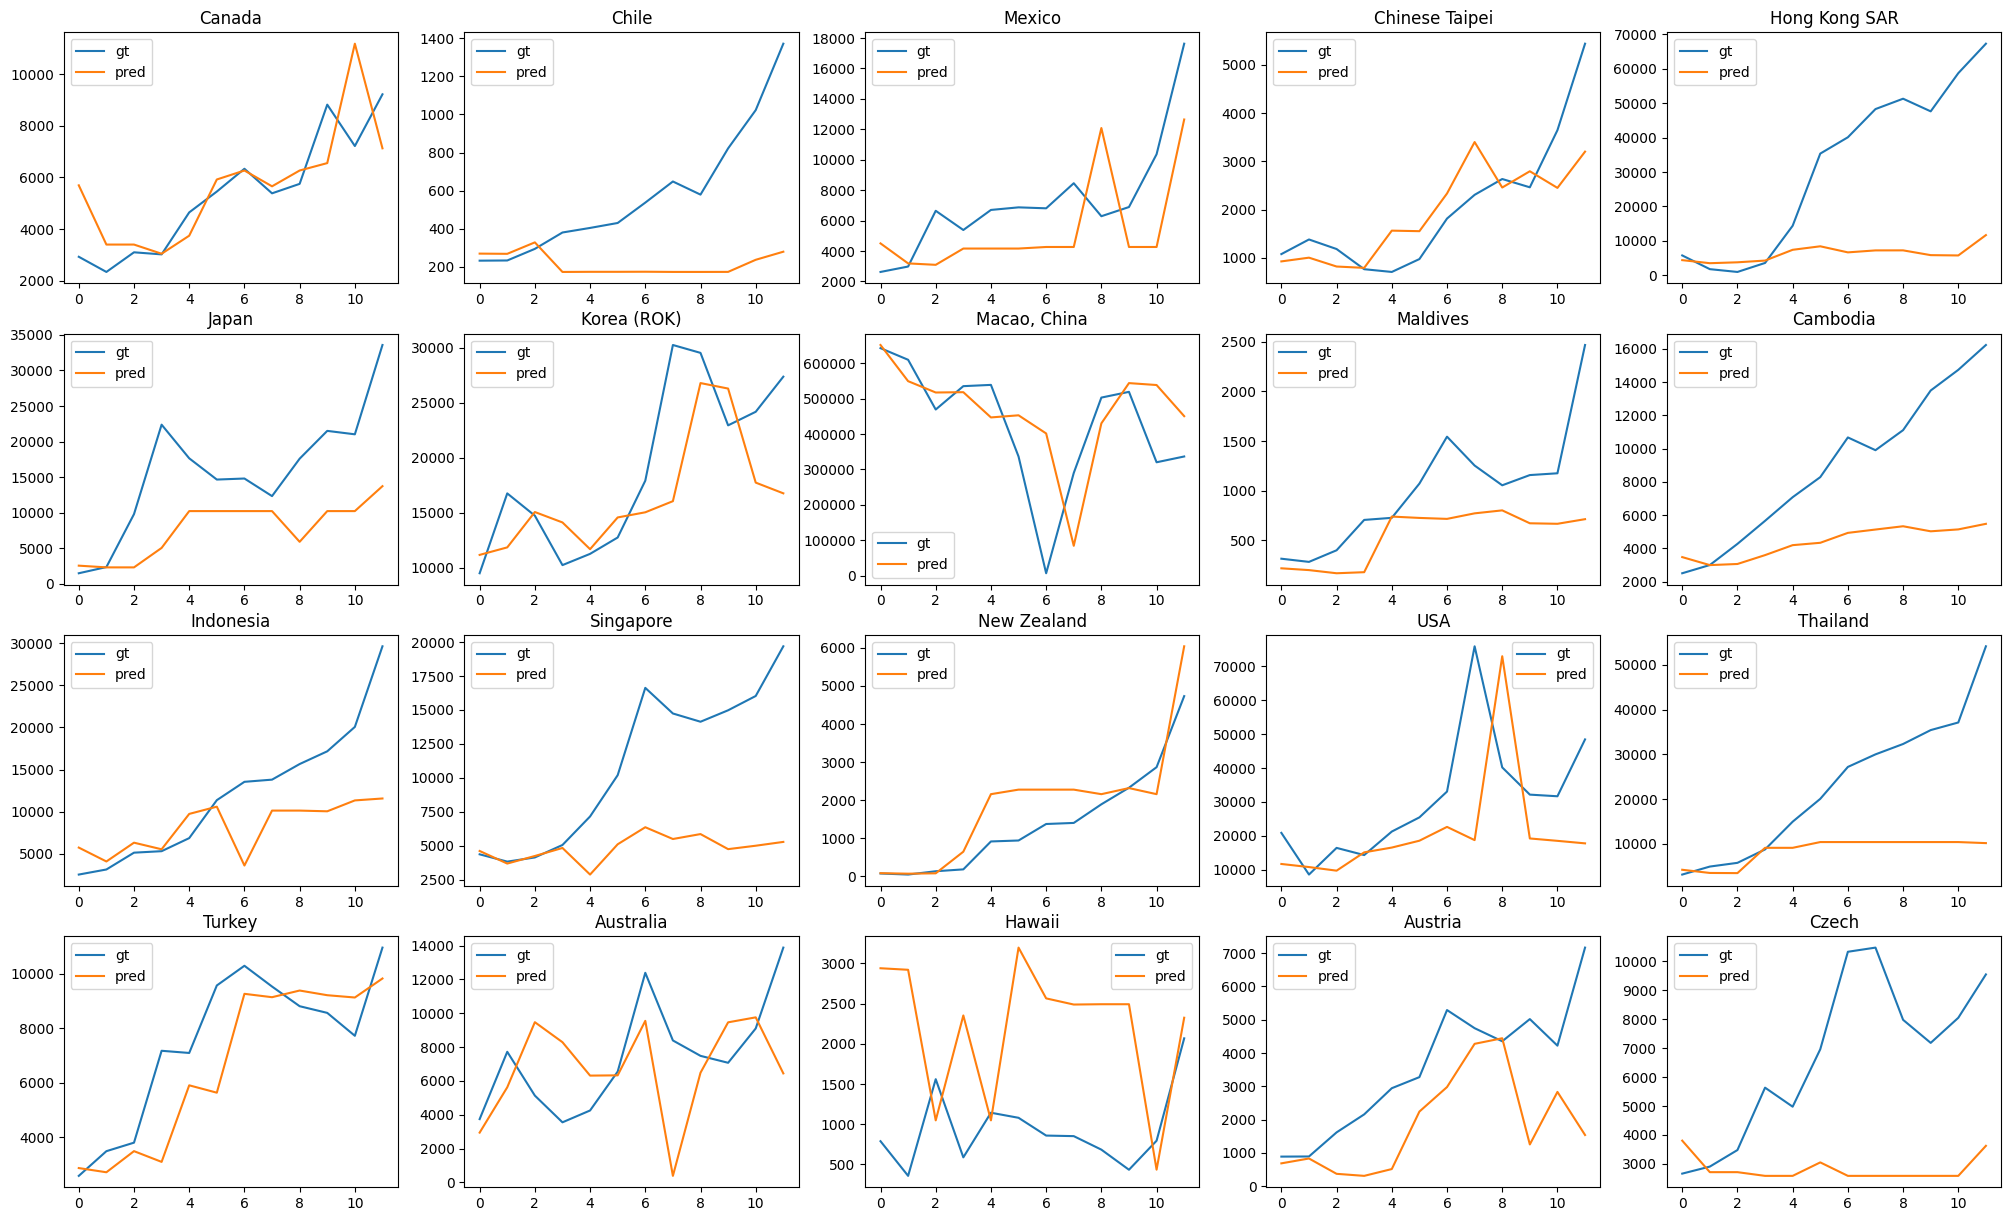

In [43]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(reg_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [44]:
reg_rmse = sqrt(mean_squared_error(all_y, reg_pred))
reg_r2 = r2_score(all_y, reg_pred)
reg_mae = mean_absolute_error(all_y, reg_pred)
reg_mape = mean_absolute_percentage_error(all_y, reg_pred)
reg_mase = mean_absolute_scaled_error(all_y, reg_pred, y_mase_scales)
print(f'Baseline Model RMSE: {reg_rmse:.5f}\nBaseline Model R2: {reg_r2:.5f}'
      f'\nBaseline Model MAE: {reg_mae:.5f}\nBaseline Model MAPE: {reg_mape:.5f}\nBaseline Model MASE: {reg_mase:.5f}')

Baseline Model RMSE: 36511.48227
Baseline Model R2: 0.86349
Baseline Model MAE: 10842.47165
Baseline Model MAPE: 0.75571
Baseline Model MASE: 0.32399


## Combination Regression Model

In [45]:
country_feat = [#'GDPPerCap', 'GDP', 'Population', 
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'CovidCases', 'CovidDeaths', 'TravelPolicy', 'GlobalCovidTrend',
                   'DistFromChina', 'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']

In [46]:
# repeat for all countries
all_train_x, all_train_y, all_test_x, all_test_y = [], [], [], []
for country, df in all_data.items():
    df = df.copy().dropna()
    train_x, train_y = df[country_feat + universal_feat], df[target]
    train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)
    train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    
    all_train_x.append(train_x)
    all_train_y.append(train_y)
    all_test_x.append(test_x)
    all_test_y.append(test_y)

all_train_x = pd.concat(all_train_x, ignore_index=True)
all_train_y = pd.concat(all_train_y, ignore_index=True)
# best_param, best_mae = grid_search_ml(all_train_x, all_train_y, score_function=mean_absolute_error, preprocess=['nopreprocess'],#sample_weight=sample_weight,
#                                       model_types=['rf', 'xgb'],
#                                        additional_params={'rf': [{'n_estimators': n} for n in (10, 50, 100, 300, 200, 400, 500)],
#                                                           'xgb': [{'n_estimators': n} for n in (10, 50, 100, 300, 200, 400, 500)]})

In [277]:
best_param, best_mae = ('xgb', 'nopreprocess', {'objective': 'reg:squarederror', 'n_estimators': 200}), 0.14475667605963807
print(best_param, best_mae)
model = get_model(best_param[0])
model = model.set_params(**best_param[2])
scaler = get_scaler(best_param[1])
all_train_x_ = scaler.fit_transform(all_train_x)
model.fit(all_train_x_, all_train_y,)# sample_weight=sample_weight)

reg_comb_pred, all_comb_y = [], []
for country, test_x, test_y in zip(all_data.keys(), all_test_x, all_test_y):
    test_x_ = scaler.transform(test_x)
    pred = model.predict(test_x_)
    
    # reg_comb_pred.append(inverse_target(pred, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
    #                                     y_scaler if single_y_scaler else y_scaler[country]))
    # all_comb_y.append(inverse_target(test_y, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
    #                                  y_scaler if single_y_scaler else y_scaler[country]))
    reg_comb_pred.append(inverse_target(pred, 0., y_scaler if single_y_scaler else y_scaler[country]))
    all_comb_y.append(inverse_target(test_y, 0., y_scaler if single_y_scaler else y_scaler[country]))

reg_comb_pred, all_comb_y = np.concatenate(reg_comb_pred), np.concatenate(all_comb_y)

('xgb', 'nopreprocess', {'objective': 'reg:squarederror', 'n_estimators': 200}) 0.14475667605963807


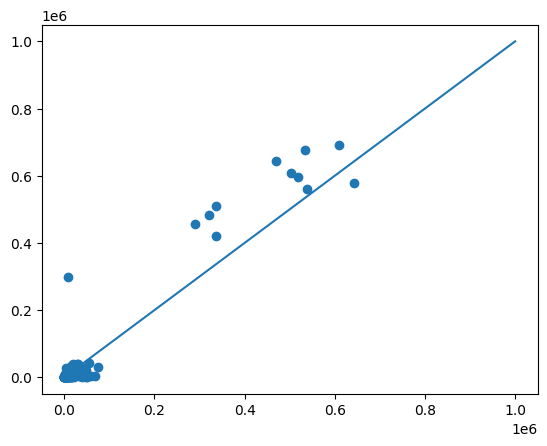

In [278]:
plt.scatter(all_y, reg_comb_pred)
plt.plot((0, 1000000), (0, 1000000))

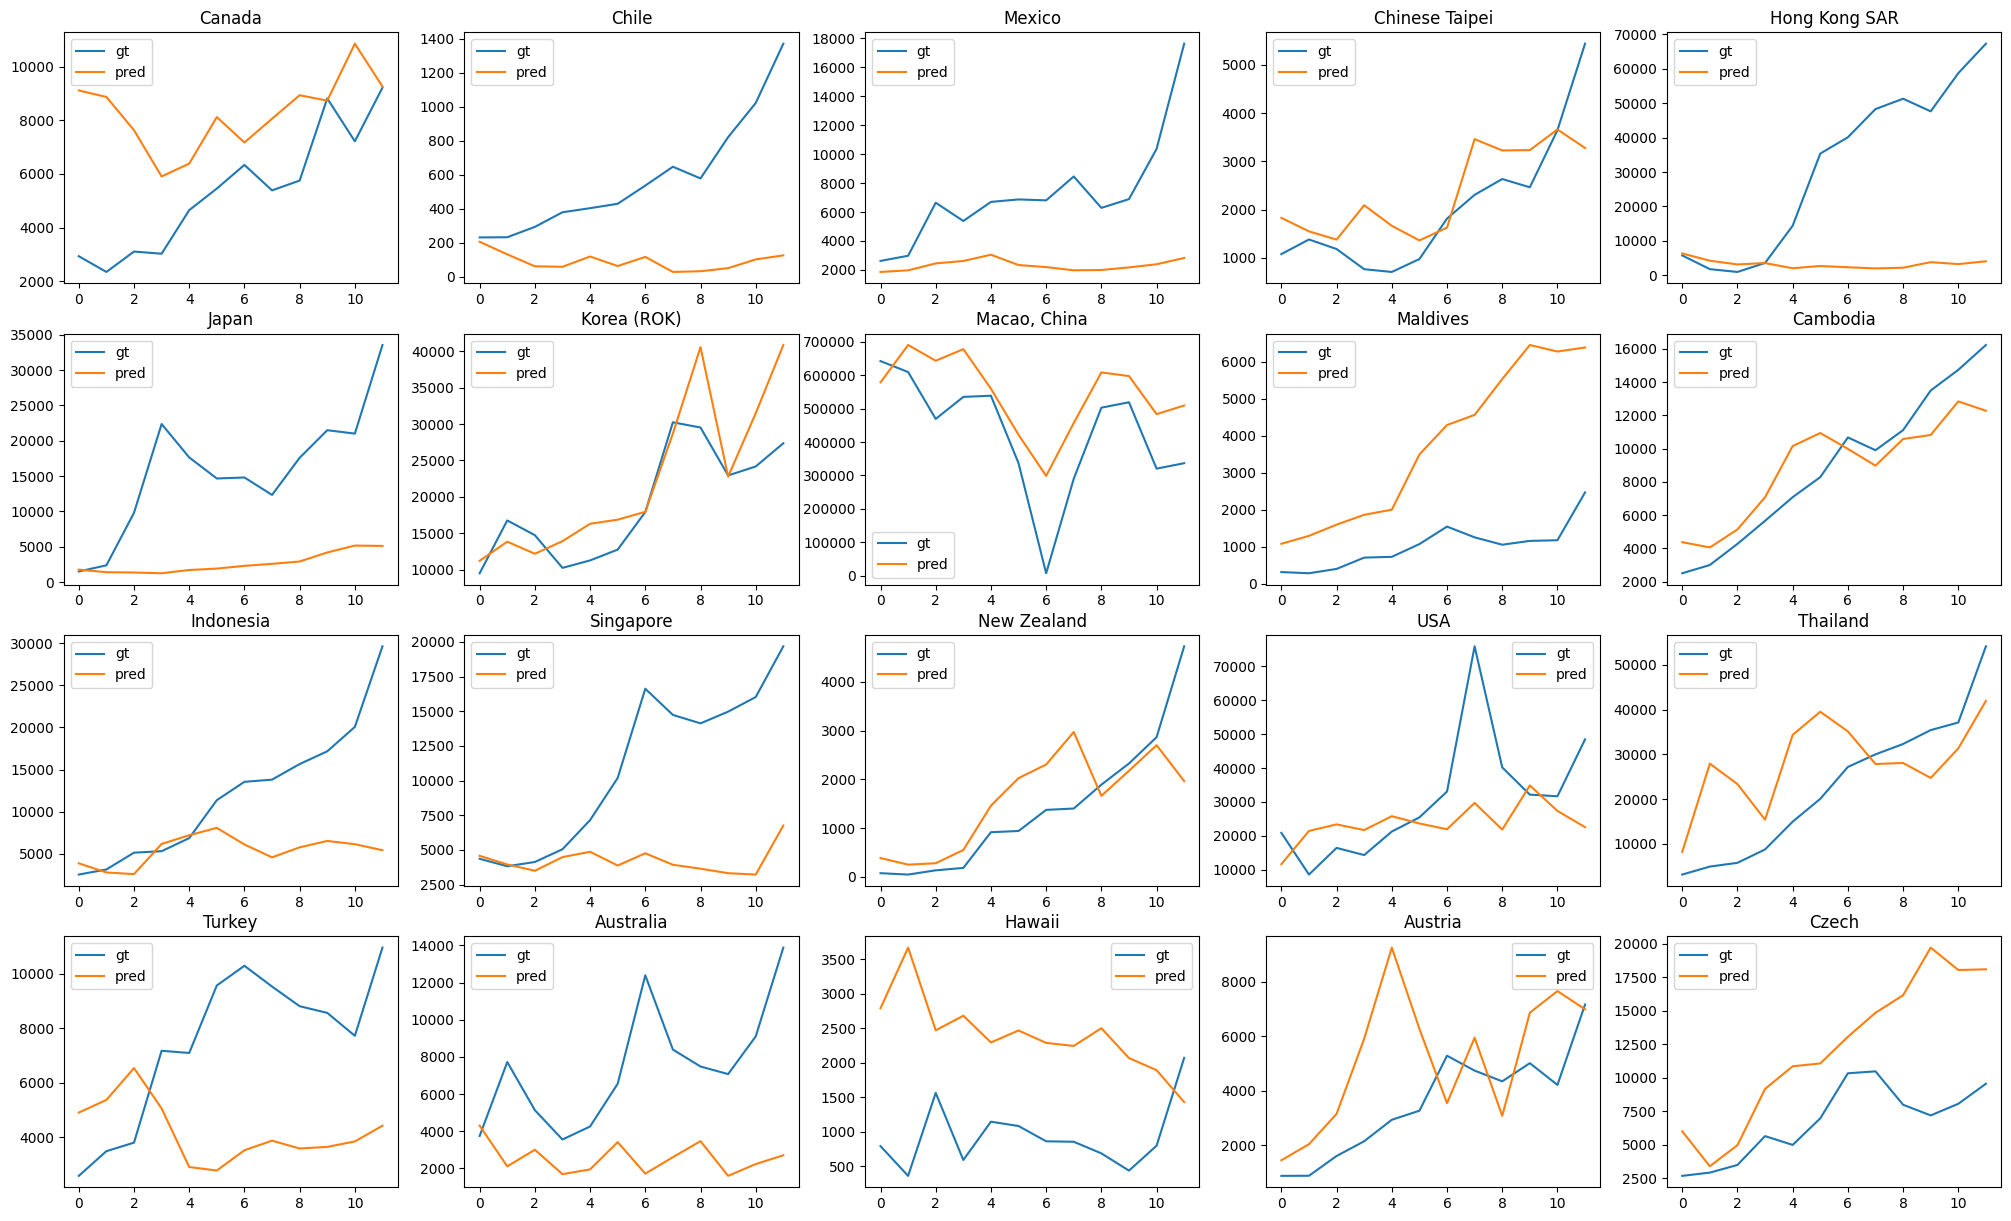

In [279]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(reg_comb_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [280]:
(all_y == all_comb_y).all()

True

In [281]:
comb_rmse = sqrt(mean_squared_error(all_y, reg_comb_pred))
comb_r2 = r2_score(all_y, reg_comb_pred)
comb_mae = mean_absolute_error(all_y, reg_comb_pred)
comb_mape = mean_absolute_percentage_error(all_y, reg_comb_pred)
comb_mase = mean_absolute_scaled_error(all_y, reg_comb_pred, y_mase_scales)
print(f'Combination Model RMSE: {comb_rmse:.5f}\nCombination Model R2: {comb_r2:.5f}'
      f'\nCombination Model MAE: {comb_mae:.5f}\nCombination Model MAPE: {comb_mape:.5f}\nCombination Model MASE: {comb_mase:.5f}')

Combination Model RMSE: 34431.34425
Combination Model R2: 0.87860
Combination Model MAE: 12281.62573
Combination Model MAPE: 1.02131
Combination Model MASE: 0.47812


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

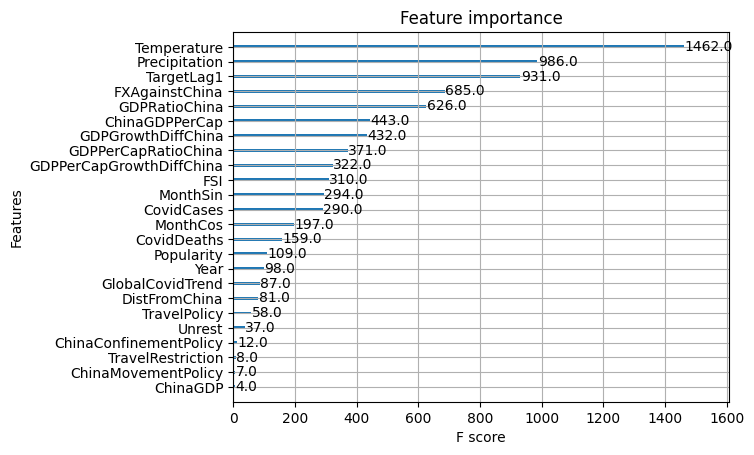

In [282]:
from xgboost import plot_importance
plot_importance(model)

In [283]:
len(country_feat + universal_feat)

23

In [284]:
# auto regressive predictions
reg_comb_pred, all_comb_y = [], []
for country, test_x, test_y in zip(all_data.keys(), all_test_x, all_test_y):
    test_x_ = scaler.transform(test_x)
    pred = []
    for i in range(len(test_x_)):
        if i > 0:
            test_x_.iloc[i:i+1, test_x_.columns.get_loc('TargetLag1')] = last_pred
        last_pred = model.predict(test_x_.iloc[i:i+1])
        pred.append(last_pred[0])
        
    pred = np.asarray(pred)
    
    reg_comb_pred.append(inverse_target(pred, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                        y_scaler if single_y_scaler else y_scaler[country]))
    all_comb_y.append(inverse_target(test_y, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                     y_scaler if single_y_scaler else y_scaler[country]))

reg_comb_pred, all_comb_y = np.concatenate(reg_comb_pred), np.concatenate(all_comb_y)

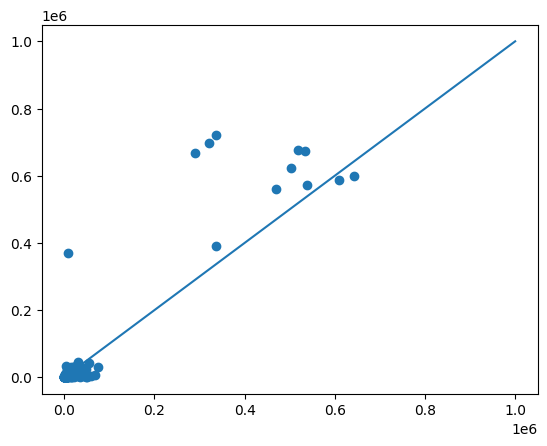

In [285]:
plt.scatter(all_y, reg_comb_pred)
plt.plot((0, 1000000), (0, 1000000))

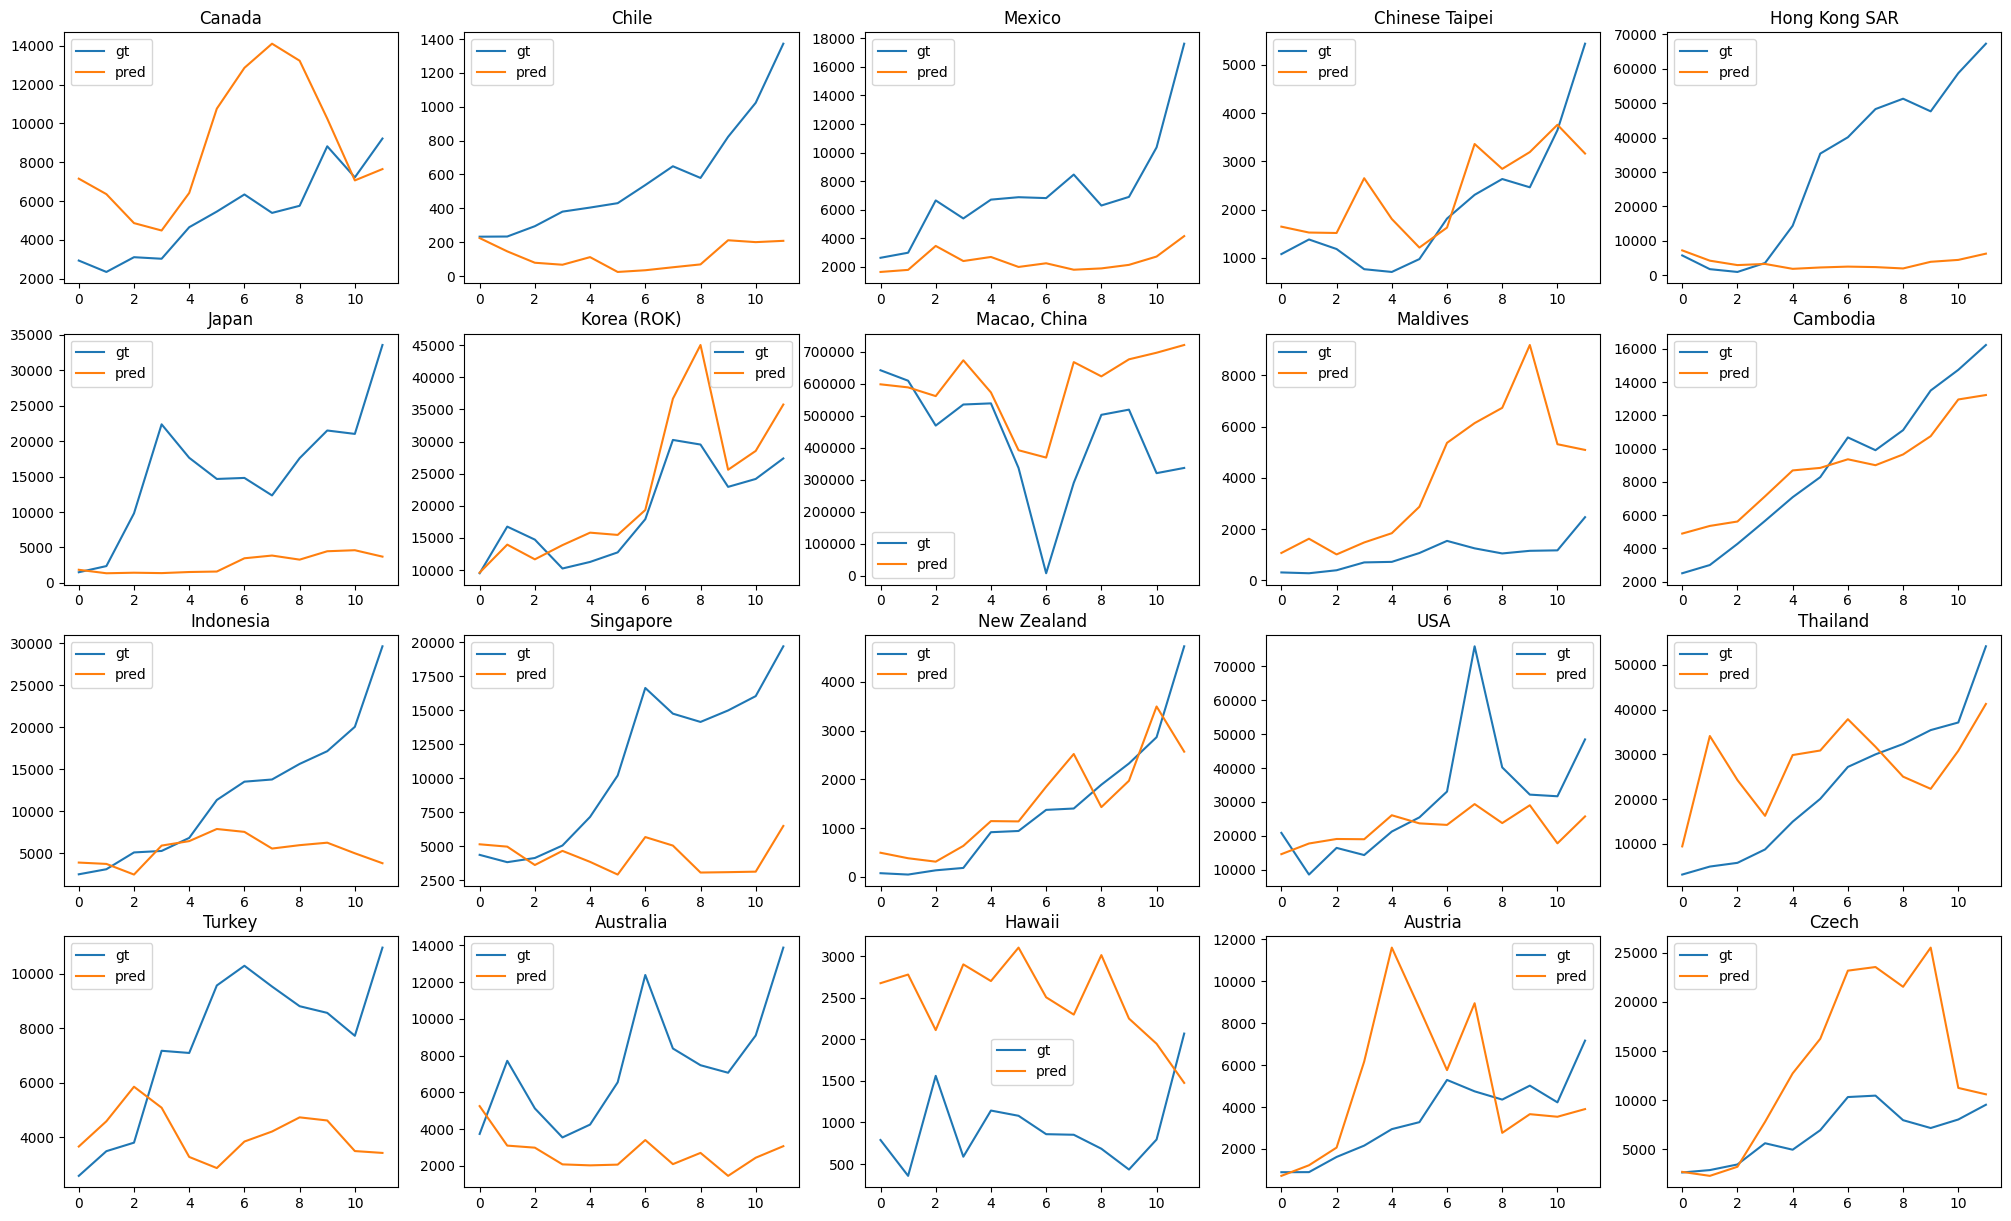

In [286]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(reg_comb_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [287]:
# inaccurate because we use actual data to predict
comb_rmse = sqrt(mean_squared_error(all_y, reg_comb_pred))
comb_r2 = r2_score(all_y, reg_comb_pred)
comb_mae = mean_absolute_error(all_y, reg_comb_pred)
comb_mape = mean_absolute_percentage_error(all_y, reg_comb_pred)
comb_mase = mean_absolute_scaled_error(all_y, reg_comb_pred, y_mase_scales)
print(f'Combination Model RMSE: {comb_rmse:.5f}\nCombination Model R2: {comb_r2:.5f}'
      f'\nCombination Model MAE: {comb_mae:.5f}\nCombination Model MAPE: {comb_mape:.5f}\nCombination Model MASE: {comb_mase:.5f}')

Combination Model RMSE: 52662.66295
Combination Model R2: 0.71600
Combination Model MAE: 14955.16756
Combination Model MAPE: 1.09845
Combination Model MASE: 0.49473


# RNN

In [202]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 'CovidCases', 'CovidDeaths', 'TravelPolicy', 'GlobalCovidTrend',
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'
def sliding_window(df, input_len=100, output_len=12, test_size=1):
    df = df.copy().dropna()
    x, y, mase = [], [], []
    if input_len <= 0:  # <=0 is full length
        input_len = len(df) - test_size * output_len * 2
    for i in range(len(df) - input_len - output_len + 1):
        x.append(df[country_feat + universal_feat + [target]].iloc[i: i + input_len])
        y.append(df[target].iloc[i + input_len: i + input_len + output_len].values)
        m = []
        for j in range(output_len):
            m.append(compute_mase_scale(df[target].iloc[: i + input_len + j].values, h=0))
        mase.append(m)
    y = np.asarray(y)
    mase = np.asarray(mase)
    return x[:-test_size*output_len], y[:-test_size*output_len], mase[:-test_size*output_len], x[-test_size:], y[-test_size:], mase[-test_size:] # train is until test_size*output_len to prevent leaking of test data to train data

In [158]:
seq_train_x, seq_train_y, mase_train, seq_test_x, seq_test_y, mase_test = sliding_window(all_data['Australia'], input_len=24, output_len=1, test_size=12)

In [159]:
len(country_feat + universal_feat)

23

In [160]:
seq_test_x[-1]

Temperature  Precipitation  FXAgainstChina       FSI    Country  \
Date                                                                          
2020-12-01     1.056959       0.623013       -0.265672 -1.375411  Australia   
2021-01-01     1.248392       1.419872       -0.265681 -1.286970  Australia   
2021-02-01     1.035689       1.488454       -0.265683 -1.286970  Australia   
2021-03-01     0.737906       1.308834       -0.265684 -1.286970  Australia   
2021-04-01     0.014717      -0.569011       -0.265685 -1.286970  Australia   
2021-05-01    -0.729741      -0.572277       -0.265681 -1.286970  Australia   
2021-06-01    -1.410389      -0.480834       -0.265670 -1.286970  Australia   
2021-07-01    -1.325308      -0.598403       -0.265656 -1.286970  Australia   
2021-08-01    -1.027525      -0.872732       -0.265646 -1.286970  Australia   
2021-09-01    -0.431958      -0.915188       -0.265645 -1.286970  Australia   
2021-10-01     0.248690      -0.448176       -0.265649 -1.286970  Australia   
2021-11-01     0.503933       0.528304       -0.265637 -1.286970  Australia   
2021-12-01     1.205851       0.231114       -0.265621 -1.286970  Australia   
2022-01-01     1.397283       1.752986       -0.265621 -1.248211  Australia   
2022-02-01     1.078230       1.406809       -0.265619 -1.248211  Australia   
2022-03-01     1.014419       0.616481       -0.265639 -1.248211  Australia   
2022-04-01     0.269960      -0.115062       -0.265648 -1.248211  Australia   
2022-05-01    -0.644660      -0.118328       -0.265645 -1.248211  Australia   
2022-06-01    -1.367849      -0.738834       -0.265642 -1.248211  Australia   
2022-07-01    -1.686902      -0.640859       -0.265629 -1.248211  Australia   
2022-08-01    -1.155146      -0.617998       -0.265647 -1.248211  Australia   
2022-09-01    -0.495769      -0.591872       -0.265640 -1.248211  Australia   
2022-10-01     0.099798       0.159266       -0.265622 -1.248211  Australia   
2022-11-01     0.418852       0.116811       -0.265646 -1.248211  Australia   

            CovidCases  CovidDeaths  TravelPolicy  GlobalCovidTrend  \
Date                                                                  
2020-12-01   -0.047918    -0.114719      4.341484          3.573588   
2021-01-01   -0.054267    -0.070333      4.341484          3.564162   
2021-02-01   -0.083932    -0.114719      4.341484          3.008034   
2021-03-01   -0.064776    -0.092526      4.341484          3.652137   
2021-04-01   -0.046933    -0.092526      4.341484          3.919204   
2021-05-01   -0.067951    -0.136911      4.341484          3.438483   
2021-06-01   -0.021537    -0.136911      4.341484          3.055163   
2021-07-01    0.222678     0.262558      4.341484          3.683557   
2021-08-01    2.292219     2.126749      4.341484          3.941198   
2021-09-01    5.206499     7.253273      4.341484          2.788096   
2021-10-01    7.543024    10.626570      4.341484          2.181697   
2021-11-01    3.997132     6.765032      2.021267          2.599578   
2021-12-01   16.885621     5.766359      2.021267          4.311950   
2022-01-01  214.069610    46.756358      2.021267          4.494184   
2022-02-01   75.834028    33.795795      2.021267          1.766957   
2022-03-01  125.845185    14.532493      0.861159          1.295662   
2022-04-01  147.808849    24.408264      0.861159          0.997176   
2022-05-01  161.757065    31.909412      0.861159          0.799232   
2022-06-01   85.257848    31.509943      0.861159          0.887207   
2022-07-01  124.481583    48.465200     -0.298949          0.962614   
2022-08-01   85.508631    44.204193     -0.298949          0.494461   
2022-09-01   21.314783    15.531166     -0.298949          0.384492   
2022-10-01   18.042116    10.449028     -0.298949          0.334221   
2022-11-01   33.524809    12.268833     -0.298949          0.321653   

            GDPRatioChina  ...  GDPPerCapRatioChina  GDPGrowthDiffChina  \
Date                       ...     

In [65]:
seq_train_x, seq_val_x, seq_train_y, seq_val_y = train_test_split(seq_train_x, seq_train_y, test_size=0.2, stratify=None)
train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))

In [66]:
len(train_dataset) + len(val_dataset)

372

In [50]:
def grid_search_rnn_custom(country_list, test_size=1, criterion_type='mse', model_types=None, input_size=19,
                    param_grids=None, max_epochs=50, verbose=True, cuda=True, output_len=12):
    if param_grids is None:
        param_grids = {}
    if model_types is None:
        model_types = ['lstm', 'gru']
    criterion = get_torch_criterion(criterion_type)

    best_score = np.inf
    best_param = None
    for seq_len in param_grids.get('seq_len', [24]):
        seq_train_x_ori, seq_train_y_ori, train_country = [], [], []
        for country in country_list:
            seq_train_x, seq_train_y, _, _ = sliding_window(all_data[country], input_len=seq_len, output_len=output_len, test_size=test_size)
            temp_country = [country] * len(seq_train_x)
            seq_train_x_ori.extend(seq_train_x)
            seq_train_y_ori.append(seq_train_y)
            train_country.extend(temp_country)
        seq_train_y_ori = np.concatenate(seq_train_y_ori)
        for batch_size in param_grids.get('batch_size', [64, 128]):
            for model_type in model_types:
                for num_layers in param_grids.get('num_layers', range(1, 3)): # 2 layers result in worse performance
                    for hidden_size in param_grids.get('hidden_size', [20, 50, 75]):
                        for optim_type in param_grids.get('optim_type', ['nadam', 'rmsprop']):
                            for lr in [0.001, 0.0005]:
                                model = ForecastModel(model_type, input_size=input_size, output_size=output_len, num_layers=num_layers, hidden_size=hidden_size, conditional_labels=country_list,)
                                optimizer = get_torch_optimizer(optim_type, model.parameters(), lr=lr)
                                score_list = []
                                kf = StratifiedKFold()
                                for train_index, test_index in kf.split(seq_train_x_ori, train_country):
                                    seq_train_x, seq_val_x = [seq_train_x_ori[i] for i in train_index], [seq_train_x_ori[i] for i in test_index]
                                    seq_train_y, seq_val_y  = seq_train_y_ori[train_index], seq_train_y_ori[test_index]
                                    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
                                    val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
                                    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True)
                                    val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, pin_memory=True)
                                    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=max_epochs, verbose=False, cuda=cuda)

                                    score_list.append(sqrt(val_losses[-1]) if criterion_type == 'mse' else val_losses[-1])
                                score = np.mean(score_list)
                                if score < best_score:
                                    best_score = score
                                    best_param = ({'seq_len': seq_len, 'batch_size': batch_size}, {'model_type': model_type, 'num_layers': num_layers, 'hidden_size': hidden_size},
                                                  {'optim_type': optim_type, 'lr': lr})
                                if verbose:
                                    print(({'seq_len': seq_len, 'batch_size': batch_size}, {'model_type': model_type, 'num_layers': num_layers, 'hidden_size': hidden_size},
                                          {'optim_type': optim_type, 'lr': lr}), round(score, 5), round(np.std(score_list), 5))
    return best_param, best_score

In [45]:
# commented out due to long runtime
# best_param, best_rmse = grid_search_rnn_custom(country_list)
# best_param, best_rmse

Epoch 0: train loss 2.2460, val loss 1.7678, time 1.7282
Epoch 1: train loss 1.4515, val loss 2.2500, time 1.5065
Epoch 2: train loss 1.3154, val loss 2.1348, time 1.5008
Epoch 3: train loss 1.2696, val loss 1.9682, time 1.5167
Epoch 4: train loss 1.2656, val loss 2.1455, time 1.5109
Epoch 5: train loss 1.2354, val loss 1.7528, time 1.5184
Epoch 6: train loss 1.1951, val loss 1.4762, time 1.5227
Epoch 7: train loss 1.1794, val loss 1.6978, time 1.5748
Epoch 8: train loss 1.1762, val loss 1.9130, time 1.5465
Epoch 9: train loss 1.1953, val loss 1.4435, time 1.5571
Epoch 10: train loss 1.1694, val loss 1.4090, time 1.5280
Epoch 11: train loss 1.1264, val loss 1.6936, time 1.5277
Epoch 12: train loss 1.1243, val loss 1.3257, time 1.5367
Epoch 13: train loss 1.1019, val loss 1.5483, time 1.5525
Epoch 14: train loss 1.0939, val loss 1.8324, time 1.5590
Epoch 15: train loss 1.1373, val loss 1.2882, time 1.5251
Epoch 16: train loss 1.0559, val loss 1.6476, time 1.5141
Epoch 17: train loss 1.0

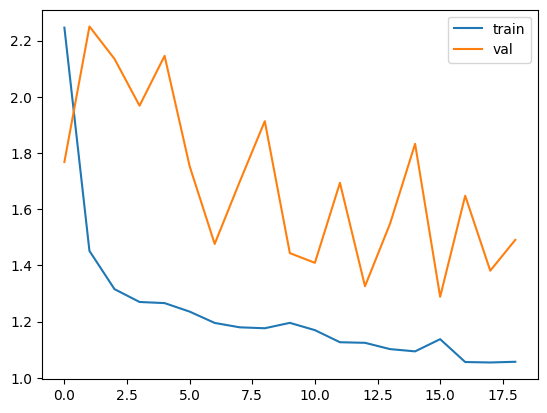

In [224]:
best_param = ({'seq_len': 24, 'batch_size': 128},
              {'model_type': 'gru', 'num_layers': 3, 'hidden_size': 50},
              {'optim_type': 'rmsprop', 'lr': 0.0005})
output_size=12
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                                      output_len=output_size, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)
train_mase_ori = np.concatenate(train_mase_ori)
test_mase_ori = np.concatenate(test_mase_ori)

model = ForecastModel(**best_param[1], input_size=23, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=100, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [225]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

In [230]:
rnn_pred, rnn_gt = [], []

for i in range(len(test_dataset)):
    country, ds_x, ds_y, _ = test_dataset.__getitem__(i)
# for i, country in enumerate(all_data.keys()):
#     ds_y = rnn_gts[i]
    # rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
    #                                y_scaler if single_y_scaler else y_scaler[country]))
    # rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
    #                              y_scaler if single_y_scaler else y_scaler[country]))
    rnn_pred.append(inverse_target(rnn_preds[i], 0., y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, 0., y_scaler if single_y_scaler else y_scaler[country]))
rnn_gt = np.concatenate(rnn_gt)
rnn_pred = np.concatenate(rnn_pred)

# monte carlo sample
model.dropout.train()
model.rnn.train()
samples = []
for _ in range(100):
    temp = []
    for country in all_data.keys():
        test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
        preds = []
        for i in range(len(test_x_)):
            if i > 0:
                last_pred = np.concatenate(preds)[-len(test_x_[i]):]
                test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
            with torch.no_grad():
                init_state = model.get_embeddings([country])
                x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
                init_state, x_input = init_state.cuda(), x_input.cuda()
                pred = model(x_input, init_state).detach().cpu().numpy()
            preds.append(pred)

        preds = np.concatenate(preds)
        temp.append(preds)
    samples.append(np.asarray(temp))

In [232]:
rnn_sample = [[] for _ in range(len(samples))]

# for i in range(len(test_dataset)):
#     country, ds_x, ds_y = test_dataset.__getitem__(i)
for j in range(len(samples)):
    for i, country in enumerate(all_data.keys()):
        rnn_sample[j].append(inverse_target(samples[j][i], 0., y_scaler if single_y_scaler else y_scaler[country]))
    rnn_sample[j] = np.concatenate(rnn_sample[j])

rnn_sample = np.asarray(rnn_sample)

In [233]:
ci = get_confidence_interval(rnn_sample)
rnn_lower = rnn_pred - ci
rnn_upper = rnn_pred + ci

In [234]:
(rnn_gt == all_y).all()

True

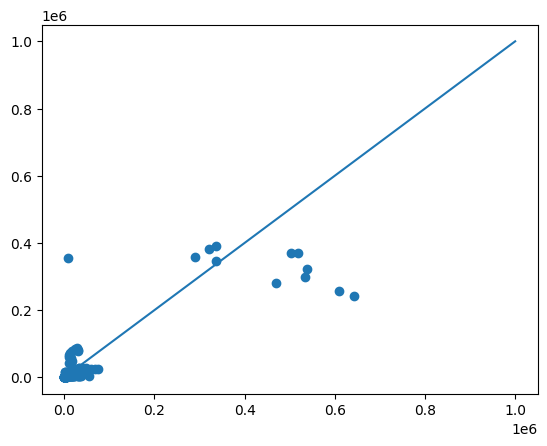

In [235]:
plt.scatter(all_y, rnn_pred)
plt.plot((0, 1000000), (0, 1000000))

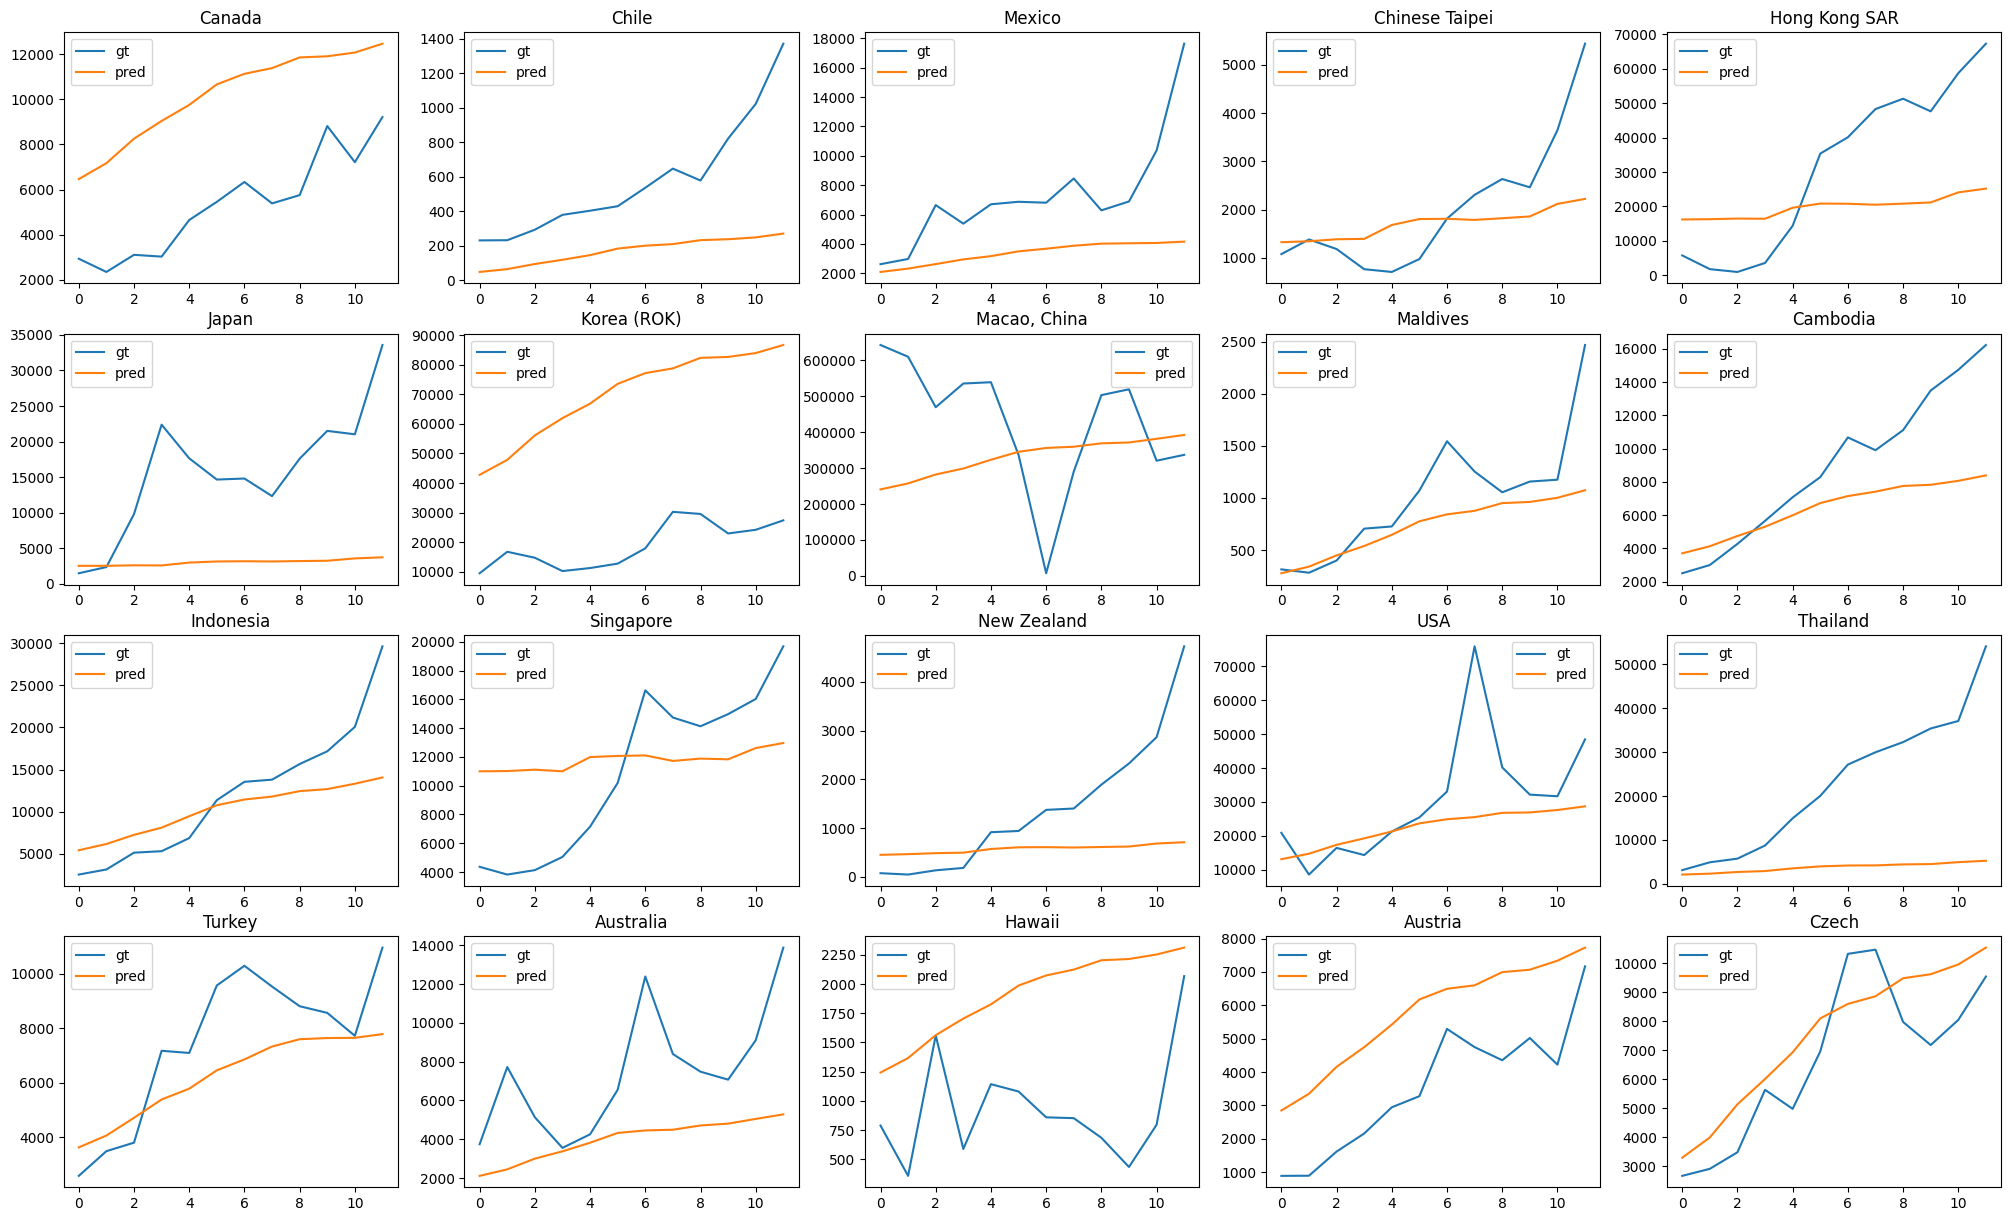

In [236]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(rnn_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [238]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_pred))
rnn_r2 = r2_score(all_y, rnn_pred)
rnn_mae = mean_absolute_error(all_y, rnn_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_pred, y_mase_scales)
rnn_winkler = winkler_score(rnn_lower, rnn_upper, all_y)

print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}\nRNN MAE: {rnn_mae:.5f}'
      f'\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}\nRNN Winkler: {rnn_winkler:.5f}')

RNN RMSE: 52009.60701
RNN R2: 0.72300
RNN MAE: 16590.29071
RNN MAPE: 1.07545
RNN MASE: 0.38868
RNN Winkler: 157508.03829


# One Step RNN

In [78]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 'CovidCases', 'CovidDeaths', 'TravelPolicy', 'GlobalCovidTrend',
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'

In [79]:
len(country_feat + universal_feat)

23

Epoch 0: train loss 2.2669, val loss 1.9618, time 1.8783
Epoch 1: train loss 1.3800, val loss 1.4667, time 1.6474
Epoch 2: train loss 0.9739, val loss 1.3226, time 1.6401
Epoch 3: train loss 0.9310, val loss 1.2553, time 1.6527
Epoch 4: train loss 0.8653, val loss 1.1176, time 1.6615
Epoch 5: train loss 0.8197, val loss 1.0065, time 1.6422
Epoch 6: train loss 0.7578, val loss 1.0584, time 1.6626
Epoch 7: train loss 0.7755, val loss 1.0277, time 1.6512
Epoch 8: train loss 0.7257, val loss 1.0448, time 1.6500
Epoch 9: train loss 0.7213, val loss 0.9455, time 1.6478
Epoch 10: train loss 0.7088, val loss 1.0959, time 1.6466
Epoch 11: train loss 0.6785, val loss 1.2038, time 1.6501
Epoch 12: train loss 0.7065, val loss 1.0224, time 1.6474
Epoch 13: train loss 0.7123, val loss 1.3315, time 1.6862
Epoch 14: train loss 0.7513, val loss 1.1382, time 1.6709
Epoch 15: train loss 0.7348, val loss 1.0501, time 1.6309
Early stopping as no improvement in val loss


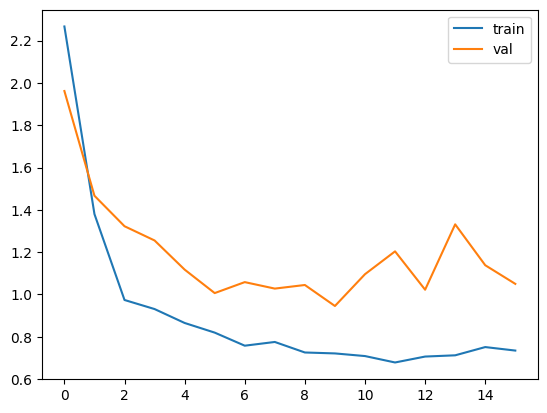

In [140]:
best_param = ({'seq_len': 24, 'batch_size': 256},
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 100},
              {'optim_type': 'rmsprop', 'lr': 0.001})
output_size=1
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                              output_len=output_size, test_size=12)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()
seq_test_y_ori = np.concatenate(seq_test_y_ori).squeeze()
train_mase_ori = np.concatenate(train_mase_ori).squeeze()
test_mase_ori = np.concatenate(test_mase_ori).squeeze()

model = ForecastModel(**best_param[1], input_size=23, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, early_stop_patience=5, epochs=100, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [141]:
# rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
model.eval()
rnn_preds, rnn_gts = [], []
for country in all_data.keys():
    test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
    preds = []
    for i in range(len(test_x_)):
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x_[i]):]
            test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
        with torch.no_grad():
            init_state = model.get_embeddings([country])
            x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = model(x_input, init_state).detach().cpu().numpy()
        preds.append(pred)
        
    preds = np.concatenate(preds)
    gts = np.asarray(test_y_)
    rnn_preds.append(preds)
    rnn_gts.append(gts)

rnn_preds = np.asarray(rnn_preds)
rnn_gts = np.asarray(rnn_gts)

# monte carlo sample
model.dropout.train()
model.rnn.train()
samples = []
for _ in range(100):
    temp = []
    for country in all_data.keys():
        test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
        preds = []
        for i in range(len(test_x_)):
            if i > 0:
                last_pred = np.concatenate(preds)[-len(test_x_[i]):]
                test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
            with torch.no_grad():
                init_state = model.get_embeddings([country])
                x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
                init_state, x_input = init_state.cuda(), x_input.cuda()
                pred = model(x_input, init_state).detach().cpu().numpy()
            preds.append(pred)

        preds = np.concatenate(preds)
        temp.append(preds)
    samples.append(np.asarray(temp))

In [142]:
rnn_os_pred, rnn_gt = [], []
rnn_os_sample = [[] for _ in range(len(samples))]

# for i in range(len(test_dataset)):
#     country, ds_x, ds_y = test_dataset.__getitem__(i)
for i, country in enumerate(all_data.keys()):
    ds_y = rnn_gts[i]
    # rnn_os_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
    #                                y_scaler if single_y_scaler else y_scaler[country]))
    # rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
    #                              y_scaler if single_y_scaler else y_scaler[country]))
    rnn_os_pred.append(inverse_target(rnn_preds[i], 0., y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, 0., y_scaler if single_y_scaler else y_scaler[country]))
for j in range(len(samples)):
    for i, country in enumerate(all_data.keys()):
        # rnn_os_sample[j].append(inverse_target(samples[j][i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
        #                                        y_scaler if single_y_scaler else y_scaler[country]))
        rnn_os_sample[j].append(inverse_target(samples[j][i], 0., y_scaler if single_y_scaler else y_scaler[country]))
    rnn_os_sample[j] = np.concatenate(rnn_os_sample[j])
    
rnn_gt = np.concatenate(rnn_gt)
rnn_os_pred = np.concatenate(rnn_os_pred)
rnn_os_sample = np.asarray(rnn_os_sample)

In [143]:
ci = get_confidence_interval(rnn_os_sample)
rnn_os_lower = rnn_os_pred - ci
rnn_os_upper = rnn_os_pred + ci

In [144]:
(rnn_gt == all_y).all()

True

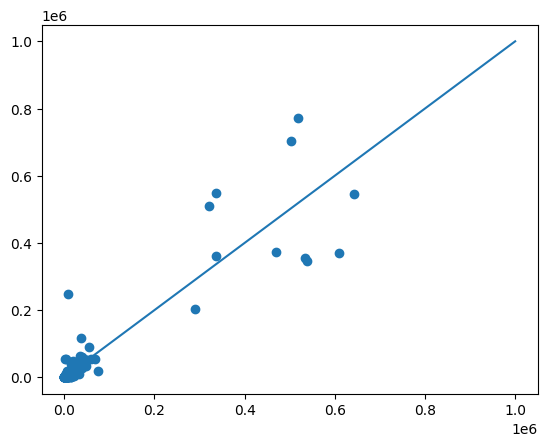

In [145]:
plt.scatter(all_y, rnn_os_pred)
plt.plot((0, 1000000), (0, 1000000))

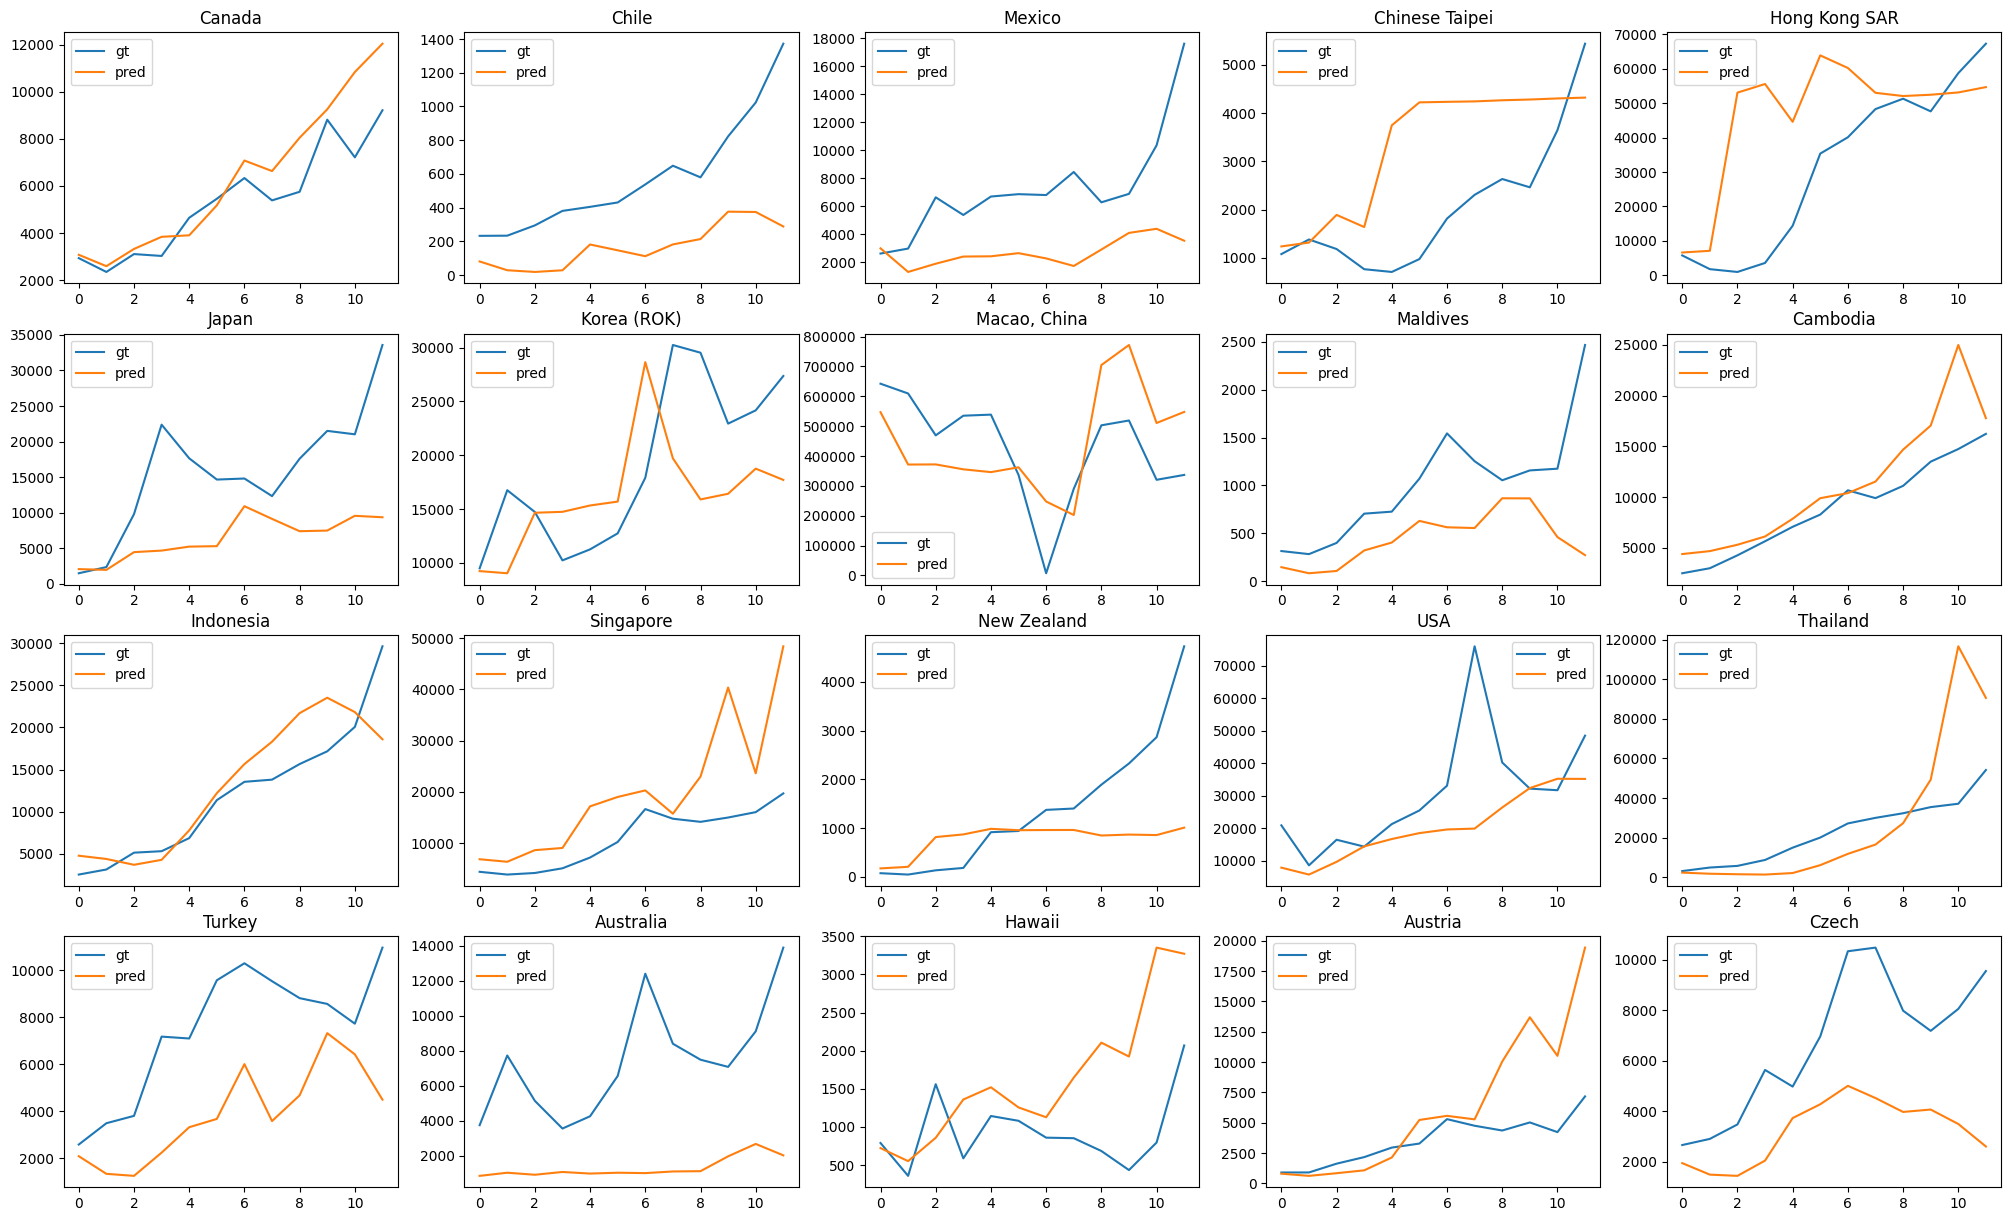

In [146]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(rnn_os_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [239]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_os_pred))
rnn_r2 = r2_score(all_y, rnn_os_pred)
rnn_mae = mean_absolute_error(all_y, rnn_os_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_os_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_os_pred, y_mase_scales)
rnn_winkler = winkler_score(rnn_os_lower, rnn_os_upper, all_y)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}\nRNN MAE: {rnn_mae:.5f}'
      f'\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}\nRNN Winkler: {rnn_winkler:.5f}')

RNN RMSE: 41961.08304
RNN R2: 0.81970
RNN MAE: 13544.25119
RNN MAPE: 1.03294
RNN MASE: 0.39887
RNN Winkler: 126509.36039


# Separate RNN models

In [191]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 'CovidCases', 'CovidDeaths', 'TravelPolicy', 'GlobalCovidTrend',
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction']
# static_feat = ['DistFromChina', 'Popularity']

Canada
Epoch 0: train loss 3.7479, val loss 2.7611, time 0.0924
Epoch 1: train loss 2.6651, val loss 2.3176, time 0.0800
Epoch 2: train loss 2.4527, val loss 1.5639, time 0.0794
Epoch 3: train loss 2.1234, val loss 1.0707, time 0.0809
Epoch 4: train loss 1.9833, val loss 0.9071, time 0.0778
Epoch 5: train loss 1.9475, val loss 0.8105, time 0.0752
Epoch 6: train loss 1.6565, val loss 0.8282, time 0.0774
Epoch 7: train loss 1.8645, val loss 0.9099, time 0.0753
Epoch 8: train loss 1.5862, val loss 1.0056, time 0.0746
Epoch 9: train loss 1.4144, val loss 1.1047, time 0.0757
Epoch 10: train loss 1.3941, val loss 1.2113, time 0.0746
Epoch 11: train loss 1.3512, val loss 1.3192, time 0.0743
Epoch 12: train loss 1.2962, val loss 1.4240, time 0.0765
Epoch 13: train loss 1.4140, val loss 1.5060, time 0.0757
Epoch 14: train loss 1.4038, val loss 1.6314, time 0.0752
Epoch 15: train loss 1.2424, val loss 1.7476, time 0.0762
Epoch 16: train loss 1.3513, val loss 1.8539, time 0.0754
Epoch 17: train l

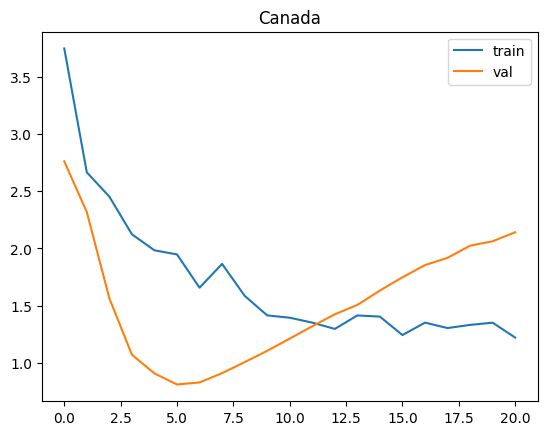

Chile
Epoch 0: train loss 5.8478, val loss 0.6745, time 0.0377
Epoch 1: train loss 5.1640, val loss 0.8670, time 0.0326
Epoch 2: train loss 4.2973, val loss 1.0633, time 0.0330
Epoch 3: train loss 4.4621, val loss 1.0783, time 0.0323
Epoch 4: train loss 4.2276, val loss 1.0189, time 0.0316
Epoch 5: train loss 4.0556, val loss 1.1234, time 0.0319
Epoch 6: train loss 3.8709, val loss 1.4333, time 0.0314
Epoch 7: train loss 3.4939, val loss 1.7521, time 0.0317
Epoch 8: train loss 3.5641, val loss 1.9750, time 0.0319
Epoch 9: train loss 3.4141, val loss 2.1159, time 0.0337
Epoch 10: train loss 3.5120, val loss 2.1320, time 0.0323
Epoch 11: train loss 3.1581, val loss 2.1664, time 0.0322
Epoch 12: train loss 3.0708, val loss 2.2990, time 0.0320
Epoch 13: train loss 3.3218, val loss 2.4907, time 0.0320
Epoch 14: train loss 3.1172, val loss 2.6131, time 0.0319
Epoch 15: train loss 2.8092, val loss 2.6409, time 0.0327
Epoch 16: train loss 2.9450, val loss 2.6262, time 0.0335
Epoch 17: train lo

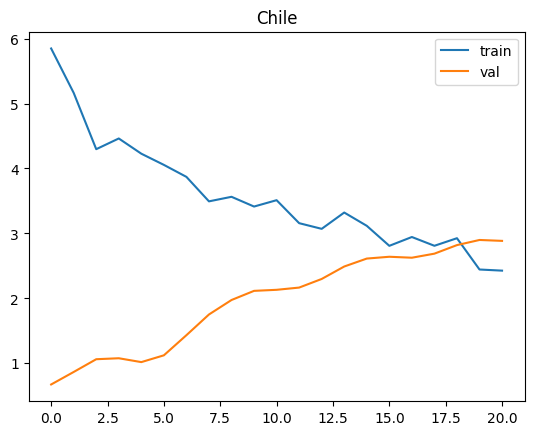

Mexico
Epoch 0: train loss 2.3920, val loss 1.3868, time 0.0717
Epoch 1: train loss 1.8443, val loss 1.3239, time 0.0619
Epoch 2: train loss 1.4543, val loss 1.4836, time 0.0621
Epoch 3: train loss 1.5326, val loss 2.2704, time 0.0616
Epoch 4: train loss 1.3365, val loss 2.8580, time 0.0620
Epoch 5: train loss 1.2250, val loss 2.8950, time 0.0625
Epoch 6: train loss 1.1693, val loss 2.6384, time 0.0614
Epoch 7: train loss 1.1492, val loss 2.4300, time 0.0607
Epoch 8: train loss 1.0298, val loss 2.2839, time 0.0627
Epoch 9: train loss 1.0316, val loss 2.2800, time 0.0613
Epoch 10: train loss 1.0103, val loss 2.2985, time 0.0609
Epoch 11: train loss 1.0533, val loss 2.3634, time 0.0608
Epoch 12: train loss 0.9541, val loss 2.4257, time 0.0623
Epoch 13: train loss 0.9487, val loss 2.4606, time 0.0623
Epoch 14: train loss 0.9349, val loss 2.4633, time 0.0614
Epoch 15: train loss 0.9076, val loss 2.4537, time 0.0611
Epoch 16: train loss 0.9701, val loss 2.4442, time 0.0619
Epoch 17: train l

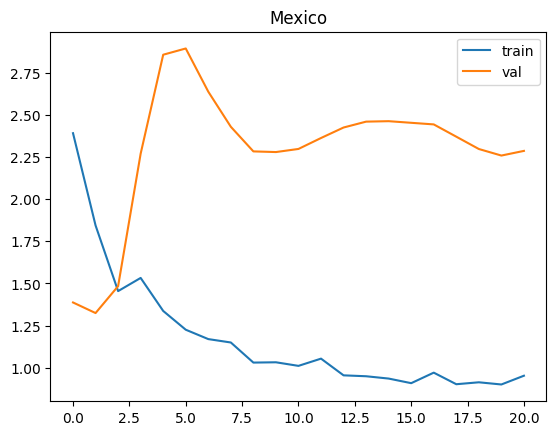

Chinese Taipei
Epoch 0: train loss 3.5039, val loss 5.8886, time 0.0543
Epoch 1: train loss 2.9874, val loss 5.4321, time 0.0470
Epoch 2: train loss 2.3811, val loss 4.6292, time 0.0469
Epoch 3: train loss 2.4795, val loss 3.7532, time 0.0466
Epoch 4: train loss 2.4761, val loss 3.2900, time 0.0469
Epoch 5: train loss 2.0343, val loss 2.9780, time 0.0480
Epoch 6: train loss 2.2334, val loss 2.5063, time 0.0468
Epoch 7: train loss 1.9191, val loss 2.0878, time 0.0470
Epoch 8: train loss 1.8434, val loss 1.8326, time 0.0474
Epoch 9: train loss 1.8312, val loss 1.6456, time 0.0475
Epoch 10: train loss 1.8122, val loss 1.5207, time 0.0473
Epoch 11: train loss 1.5941, val loss 1.3999, time 0.0462
Epoch 12: train loss 1.5344, val loss 1.2907, time 0.0471
Epoch 13: train loss 1.5119, val loss 1.2324, time 0.0464
Epoch 14: train loss 1.4309, val loss 1.1819, time 0.0462
Epoch 15: train loss 1.4322, val loss 1.1830, time 0.0472
Epoch 16: train loss 1.3518, val loss 1.1965, time 0.0472
Epoch 17:

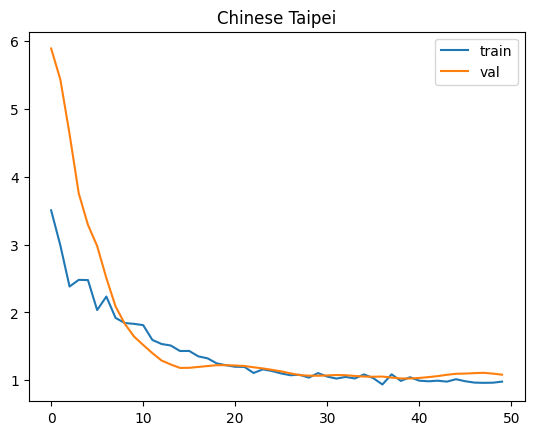

Hong Kong SAR
Epoch 0: train loss 5.1606, val loss 7.3170, time 0.0998
Epoch 1: train loss 3.5052, val loss 5.8407, time 0.0891
Epoch 2: train loss 2.8569, val loss 6.2102, time 0.0871
Epoch 3: train loss 2.7988, val loss 5.6310, time 0.0878
Epoch 4: train loss 2.4372, val loss 4.6074, time 0.0866
Epoch 5: train loss 2.2811, val loss 4.2940, time 0.0880
Epoch 6: train loss 2.0932, val loss 4.0847, time 0.0884
Epoch 7: train loss 1.9444, val loss 3.5348, time 0.0939
Epoch 8: train loss 1.8001, val loss 3.1232, time 0.0933
Epoch 9: train loss 1.8109, val loss 2.8162, time 0.0947
Epoch 10: train loss 1.6733, val loss 2.6140, time 0.0921
Epoch 11: train loss 1.5562, val loss 2.4191, time 0.0927
Epoch 12: train loss 1.5080, val loss 2.2424, time 0.0957
Epoch 13: train loss 1.4979, val loss 2.0430, time 0.0927
Epoch 14: train loss 1.4718, val loss 2.0056, time 0.0923
Epoch 15: train loss 1.4639, val loss 1.9221, time 0.0943
Epoch 16: train loss 1.4559, val loss 2.0357, time 0.0945
Epoch 17: 

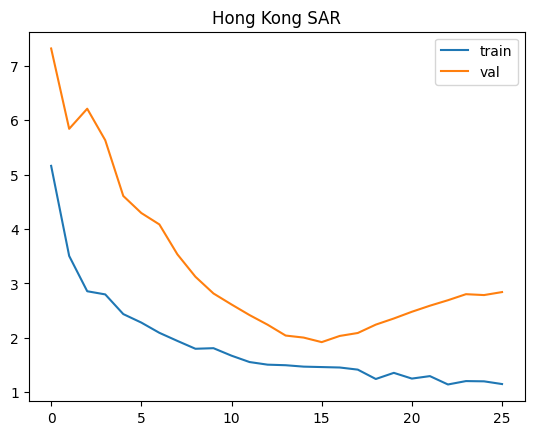

Japan
Epoch 0: train loss 4.8930, val loss 3.4525, time 0.1174
Epoch 1: train loss 3.3705, val loss 2.0693, time 0.1048
Epoch 2: train loss 3.1906, val loss 1.7835, time 0.1047
Epoch 3: train loss 2.5556, val loss 1.3914, time 0.1041
Epoch 4: train loss 2.6354, val loss 1.2391, time 0.1037
Epoch 5: train loss 2.3530, val loss 1.3453, time 0.1044
Epoch 6: train loss 2.4852, val loss 1.5276, time 0.1048
Epoch 7: train loss 1.8759, val loss 1.8741, time 0.1034
Epoch 8: train loss 1.9021, val loss 1.9698, time 0.1034
Epoch 9: train loss 1.9238, val loss 2.1628, time 0.1025
Epoch 10: train loss 1.9299, val loss 2.3455, time 0.1062
Epoch 11: train loss 1.8412, val loss 2.3437, time 0.1045
Epoch 12: train loss 1.6152, val loss 2.4090, time 0.1035
Epoch 13: train loss 1.6348, val loss 2.5702, time 0.1038
Epoch 14: train loss 1.6003, val loss 2.4612, time 0.1034
Epoch 15: train loss 1.6441, val loss 2.5624, time 0.1047
Epoch 16: train loss 1.4811, val loss 2.6759, time 0.1035
Epoch 17: train lo

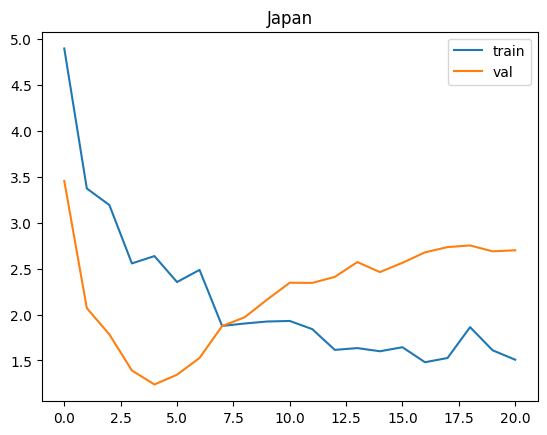

Korea (ROK)
Epoch 0: train loss 3.5684, val loss 3.8601, time 0.1112
Epoch 1: train loss 2.3239, val loss 3.0716, time 0.1018
Epoch 2: train loss 2.1852, val loss 1.5281, time 0.0996
Epoch 3: train loss 1.9924, val loss 1.6837, time 0.0961
Epoch 4: train loss 1.6291, val loss 1.8764, time 0.0957
Epoch 5: train loss 1.5802, val loss 1.0715, time 0.0958
Epoch 6: train loss 1.4162, val loss 0.9265, time 0.0962
Epoch 7: train loss 1.3556, val loss 1.1620, time 0.0967
Epoch 8: train loss 1.3742, val loss 1.1661, time 0.0970
Epoch 9: train loss 1.3321, val loss 0.9532, time 0.0960
Epoch 10: train loss 1.2286, val loss 0.8995, time 0.0946
Epoch 11: train loss 1.2546, val loss 0.9338, time 0.0964
Epoch 12: train loss 1.2803, val loss 0.8397, time 0.0984
Epoch 13: train loss 1.2134, val loss 0.8253, time 0.0955
Epoch 14: train loss 1.2171, val loss 0.8271, time 0.0958
Epoch 15: train loss 1.2111, val loss 0.8798, time 0.0950
Epoch 16: train loss 1.1269, val loss 0.8518, time 0.0958
Epoch 17: tr

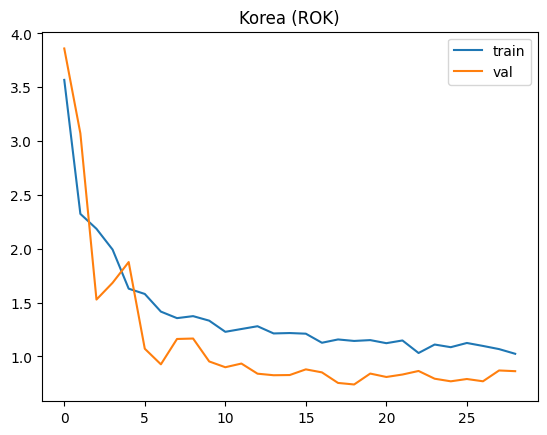

Macao, China
Epoch 0: train loss 2.5853, val loss 2.0016, time 0.1057
Epoch 1: train loss 1.8435, val loss 1.6466, time 0.0928
Epoch 2: train loss 1.4162, val loss 2.1406, time 0.0971
Epoch 3: train loss 1.5144, val loss 1.3253, time 0.1101
Epoch 4: train loss 1.3607, val loss 1.4959, time 0.0935
Epoch 5: train loss 1.2838, val loss 1.9795, time 0.0938
Epoch 6: train loss 1.1899, val loss 2.0022, time 0.0948
Epoch 7: train loss 1.0835, val loss 1.6643, time 0.0929
Epoch 8: train loss 1.0646, val loss 1.6412, time 0.0928
Epoch 9: train loss 1.0230, val loss 1.5988, time 0.0933
Epoch 10: train loss 0.9807, val loss 1.5697, time 0.0943
Epoch 11: train loss 0.9304, val loss 1.5682, time 0.0937
Epoch 12: train loss 0.9106, val loss 1.5688, time 0.0950
Epoch 13: train loss 0.9405, val loss 1.5592, time 0.0955
Epoch 14: train loss 0.8946, val loss 1.5900, time 0.0936
Epoch 15: train loss 0.8496, val loss 1.5952, time 0.0967
Epoch 16: train loss 0.8979, val loss 1.6318, time 0.0952
Epoch 17: t

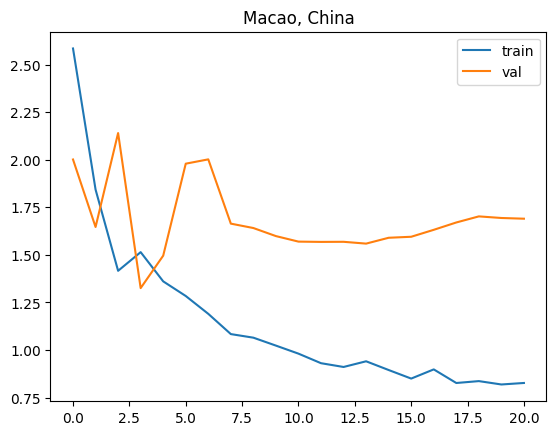

Maldives
Epoch 0: train loss 2.7160, val loss 1.3450, time 0.1097
Epoch 1: train loss 1.9060, val loss 0.9790, time 0.0963
Epoch 2: train loss 1.6048, val loss 1.2872, time 0.0957
Epoch 3: train loss 1.4689, val loss 1.8980, time 0.0961
Epoch 4: train loss 1.3811, val loss 2.1949, time 0.0946
Epoch 5: train loss 1.2871, val loss 2.2681, time 0.0947
Epoch 6: train loss 1.2034, val loss 2.3127, time 0.0978
Epoch 7: train loss 1.1020, val loss 2.3331, time 0.0963
Epoch 8: train loss 1.1219, val loss 2.2653, time 0.0958
Epoch 9: train loss 1.0381, val loss 2.1850, time 0.0962
Epoch 10: train loss 1.0468, val loss 2.1110, time 0.0947
Epoch 11: train loss 1.0493, val loss 2.1259, time 0.0937
Epoch 12: train loss 0.9982, val loss 2.1734, time 0.0973
Epoch 13: train loss 0.9423, val loss 2.1104, time 0.0964
Epoch 14: train loss 0.9684, val loss 2.0715, time 0.0950
Epoch 15: train loss 0.9151, val loss 2.1623, time 0.0971
Epoch 16: train loss 0.8875, val loss 2.2452, time 0.0969
Epoch 17: train

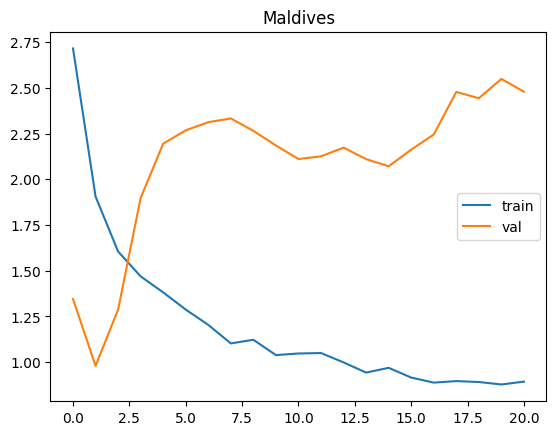

Cambodia
Epoch 0: train loss 4.1293, val loss 1.9228, time 0.0877
Epoch 1: train loss 2.0871, val loss 1.5058, time 0.0759
Epoch 2: train loss 2.1008, val loss 1.4688, time 0.0751
Epoch 3: train loss 1.5124, val loss 1.7819, time 0.0757
Epoch 4: train loss 1.5433, val loss 1.9617, time 0.0748
Epoch 5: train loss 1.3968, val loss 2.0612, time 0.0703
Epoch 6: train loss 1.5395, val loss 2.0699, time 0.0713
Epoch 7: train loss 2.6171, val loss 1.9244, time 0.0712
Epoch 8: train loss 1.3583, val loss 1.7761, time 0.0719
Epoch 9: train loss 1.2445, val loss 1.6887, time 0.0723
Epoch 10: train loss 1.2178, val loss 1.6587, time 0.0709
Epoch 11: train loss 1.1096, val loss 1.6739, time 0.0705
Epoch 12: train loss 1.0899, val loss 1.6343, time 0.0713
Epoch 13: train loss 1.0890, val loss 1.6154, time 0.0713
Epoch 14: train loss 1.3304, val loss 1.5946, time 0.0718
Epoch 15: train loss 1.1533, val loss 1.5433, time 0.0741
Epoch 16: train loss 1.1606, val loss 1.5043, time 0.0707
Epoch 17: train

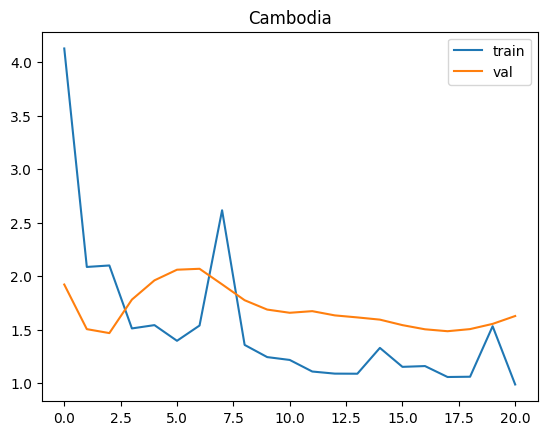

Indonesia
Epoch 0: train loss 4.4477, val loss 2.5982, time 0.0354
Epoch 1: train loss 4.3228, val loss 2.7869, time 0.0309
Epoch 2: train loss 3.5957, val loss 2.6605, time 0.0303
Epoch 3: train loss 2.3238, val loss 2.3474, time 0.0322
Epoch 4: train loss 3.1691, val loss 2.0252, time 0.0309
Epoch 5: train loss 2.7294, val loss 1.6916, time 0.0306
Epoch 6: train loss 2.5477, val loss 1.4332, time 0.0304
Epoch 7: train loss 2.5201, val loss 1.2041, time 0.0315
Epoch 8: train loss 2.3060, val loss 0.9915, time 0.0288
Epoch 9: train loss 1.9043, val loss 0.8541, time 0.0281
Epoch 10: train loss 2.3265, val loss 0.8834, time 0.0292
Epoch 11: train loss 2.0586, val loss 1.0395, time 0.0283
Epoch 12: train loss 2.2205, val loss 1.1283, time 0.0281
Epoch 13: train loss 2.1996, val loss 1.1879, time 0.0281
Epoch 14: train loss 2.2192, val loss 1.2383, time 0.0281
Epoch 15: train loss 2.1971, val loss 1.2611, time 0.0285
Epoch 16: train loss 2.1947, val loss 1.2522, time 0.0282
Epoch 17: trai

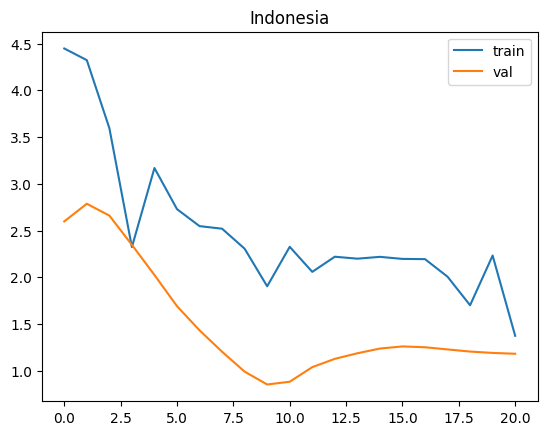

Singapore
Epoch 0: train loss 2.2712, val loss 3.2831, time 0.0896
Epoch 1: train loss 1.7558, val loss 2.8297, time 0.0788
Epoch 2: train loss 1.6807, val loss 2.2664, time 0.0772
Epoch 3: train loss 1.4438, val loss 1.3766, time 0.0766
Epoch 4: train loss 1.5169, val loss 1.0405, time 0.0755
Epoch 5: train loss 1.4270, val loss 0.8146, time 0.0755
Epoch 6: train loss 1.3658, val loss 0.7983, time 0.0771
Epoch 7: train loss 1.2721, val loss 0.8030, time 0.0770
Epoch 8: train loss 1.2855, val loss 0.7718, time 0.0749
Epoch 9: train loss 1.3147, val loss 0.7233, time 0.0754
Epoch 10: train loss 1.0450, val loss 0.6531, time 0.0743
Epoch 11: train loss 1.0441, val loss 0.6370, time 0.0746
Epoch 12: train loss 1.3771, val loss 0.5971, time 0.0765
Epoch 13: train loss 1.0384, val loss 0.5733, time 0.0756
Epoch 14: train loss 1.2077, val loss 0.5541, time 0.0751
Epoch 15: train loss 0.9734, val loss 0.5427, time 0.0760
Epoch 16: train loss 1.1169, val loss 0.5605, time 0.0743
Epoch 17: trai

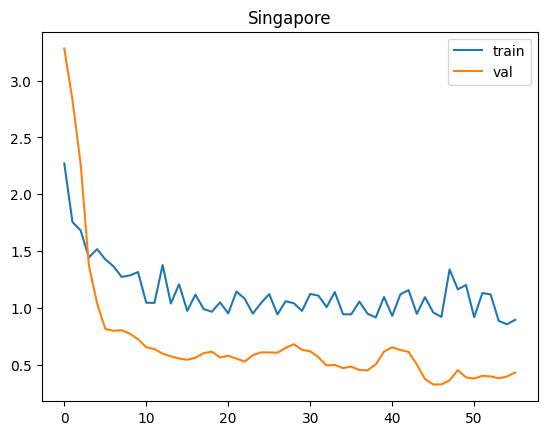

New Zealand
Epoch 0: train loss 3.3781, val loss 4.5900, time 0.0887
Epoch 1: train loss 2.2223, val loss 3.6555, time 0.0760
Epoch 2: train loss 2.1672, val loss 3.3065, time 0.0744
Epoch 3: train loss 1.8750, val loss 2.8114, time 0.0765
Epoch 4: train loss 1.6670, val loss 2.5339, time 0.0746
Epoch 5: train loss 1.7914, val loss 2.4113, time 0.0743
Epoch 6: train loss 1.5074, val loss 2.2626, time 0.0760
Epoch 7: train loss 1.4315, val loss 2.2049, time 0.0746
Epoch 8: train loss 1.4068, val loss 2.1532, time 0.0742
Epoch 9: train loss 1.6669, val loss 2.1326, time 0.0760
Epoch 10: train loss 1.2993, val loss 2.1489, time 0.0751
Epoch 11: train loss 1.2600, val loss 2.2401, time 0.0743
Epoch 12: train loss 1.1917, val loss 2.3359, time 0.0755
Epoch 13: train loss 1.3280, val loss 2.3929, time 0.0747
Epoch 14: train loss 1.1295, val loss 2.4971, time 0.0749
Epoch 15: train loss 1.0911, val loss 2.7036, time 0.0759
Epoch 16: train loss 1.1609, val loss 2.9007, time 0.0800
Epoch 17: tr

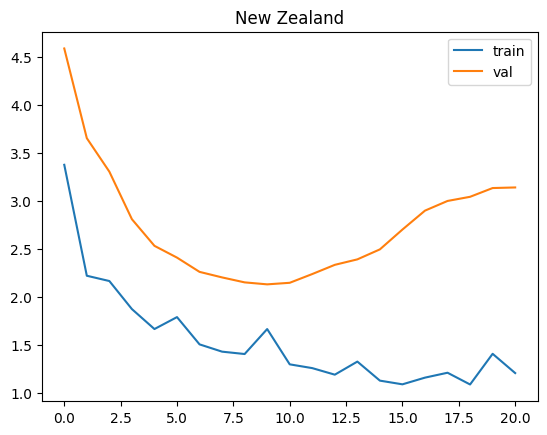

USA
Epoch 0: train loss 4.0539, val loss 1.4370, time 0.1012
Epoch 1: train loss 2.7727, val loss 1.3160, time 0.0874
Epoch 2: train loss 2.5930, val loss 1.7959, time 0.0881
Epoch 3: train loss 2.1456, val loss 1.5063, time 0.0887
Epoch 4: train loss 2.0974, val loss 1.8279, time 0.0872
Epoch 5: train loss 1.8351, val loss 2.5057, time 0.0884
Epoch 6: train loss 1.7578, val loss 2.7814, time 0.0894
Epoch 7: train loss 1.6706, val loss 2.8467, time 0.0882
Epoch 8: train loss 1.5174, val loss 2.9939, time 0.0883
Epoch 9: train loss 1.5307, val loss 3.2421, time 0.0888
Epoch 10: train loss 1.4930, val loss 3.4286, time 0.0889
Epoch 11: train loss 1.3749, val loss 3.5313, time 0.0885
Epoch 12: train loss 1.4240, val loss 3.6200, time 0.0887
Epoch 13: train loss 1.3546, val loss 3.7588, time 0.0883
Epoch 14: train loss 1.3415, val loss 3.8680, time 0.1051
Epoch 15: train loss 1.2650, val loss 3.8666, time 0.0900
Epoch 16: train loss 1.2923, val loss 3.8807, time 0.0902
Epoch 17: train loss

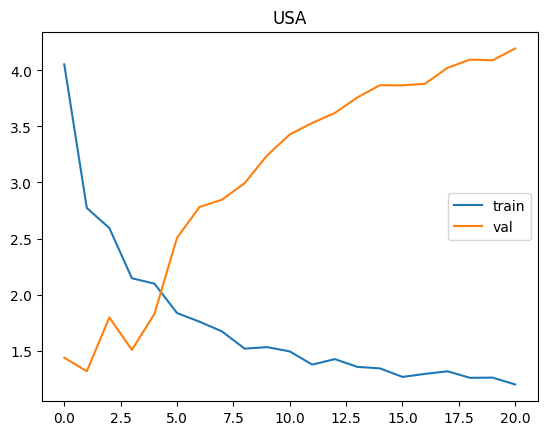

Thailand
Epoch 0: train loss 3.4347, val loss 1.4657, time 0.1278
Epoch 1: train loss 2.4435, val loss 1.6362, time 0.1274
Epoch 2: train loss 2.1574, val loss 1.6048, time 0.1116
Epoch 3: train loss 1.9991, val loss 1.5091, time 0.1108
Epoch 4: train loss 1.8777, val loss 1.4949, time 0.1111
Epoch 5: train loss 1.6269, val loss 1.5178, time 0.1105
Epoch 6: train loss 1.5677, val loss 1.9101, time 0.1096
Epoch 7: train loss 1.5098, val loss 2.1615, time 0.1101
Epoch 8: train loss 1.5634, val loss 2.3924, time 0.1119
Epoch 9: train loss 1.4358, val loss 2.6810, time 0.1112
Epoch 10: train loss 1.4138, val loss 2.7358, time 0.1117
Epoch 11: train loss 1.4449, val loss 2.9924, time 0.1103
Epoch 12: train loss 1.4492, val loss 3.1280, time 0.1114
Epoch 13: train loss 1.4136, val loss 3.0987, time 0.1112
Epoch 14: train loss 1.4428, val loss 3.4234, time 0.1101
Epoch 15: train loss 1.3556, val loss 3.4258, time 0.1094
Epoch 16: train loss 1.4087, val loss 3.4996, time 0.1105
Epoch 17: train

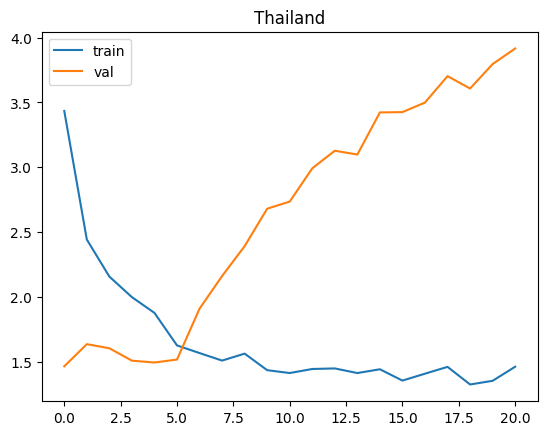

Turkey
Epoch 0: train loss 2.4394, val loss 1.5429, time 0.1033
Epoch 1: train loss 1.7350, val loss 1.7427, time 0.0905
Epoch 2: train loss 1.4369, val loss 2.5347, time 0.0891
Epoch 3: train loss 1.2937, val loss 3.1854, time 0.0901
Epoch 4: train loss 1.3210, val loss 3.4237, time 0.0905
Epoch 5: train loss 1.1987, val loss 3.2316, time 0.0900
Epoch 6: train loss 1.0565, val loss 3.0046, time 0.0898
Epoch 7: train loss 1.0493, val loss 2.6371, time 0.0891
Epoch 8: train loss 1.0035, val loss 2.3979, time 0.0891
Epoch 9: train loss 0.9888, val loss 2.2802, time 0.0890
Epoch 10: train loss 0.9295, val loss 2.3550, time 0.0908
Epoch 11: train loss 0.9178, val loss 2.3046, time 0.0900
Epoch 12: train loss 0.9458, val loss 2.4560, time 0.0907
Epoch 13: train loss 0.9022, val loss 2.5717, time 0.0891
Epoch 14: train loss 0.8816, val loss 2.4370, time 0.0890
Epoch 15: train loss 0.8865, val loss 2.4423, time 0.0901
Epoch 16: train loss 0.8649, val loss 2.3783, time 0.0905
Epoch 17: train l

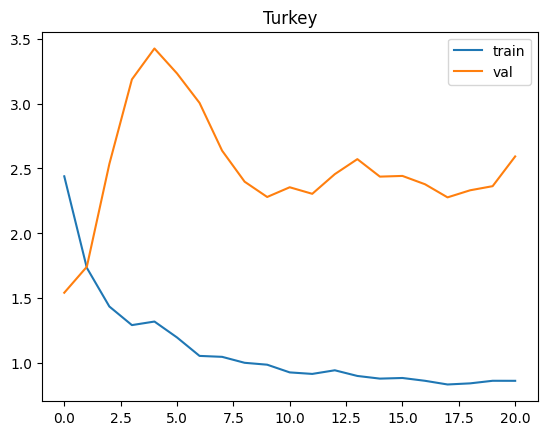

Australia
Epoch 0: train loss 4.0658, val loss 1.4202, time 0.1555
Epoch 1: train loss 2.7052, val loss 1.6418, time 0.1375
Epoch 2: train loss 2.2986, val loss 1.4330, time 0.1363
Epoch 3: train loss 2.0185, val loss 2.8422, time 0.1351
Epoch 4: train loss 1.7192, val loss 4.0926, time 0.1374
Epoch 5: train loss 1.5561, val loss 4.6800, time 0.1353
Epoch 6: train loss 1.4842, val loss 4.9670, time 0.1300
Epoch 7: train loss 1.4429, val loss 5.2822, time 0.1288
Epoch 8: train loss 1.3142, val loss 5.5915, time 0.1311
Epoch 9: train loss 1.2573, val loss 5.8015, time 0.1295
Epoch 10: train loss 1.2055, val loss 5.6333, time 0.1295
Epoch 11: train loss 1.2101, val loss 5.5813, time 0.1289
Epoch 12: train loss 1.1739, val loss 5.2319, time 0.1316
Epoch 13: train loss 1.1879, val loss 5.3145, time 0.1296
Epoch 14: train loss 1.1617, val loss 5.4238, time 0.1301
Epoch 15: train loss 1.1321, val loss 5.4219, time 0.1281
Epoch 16: train loss 1.1260, val loss 5.5460, time 0.1307
Epoch 17: trai

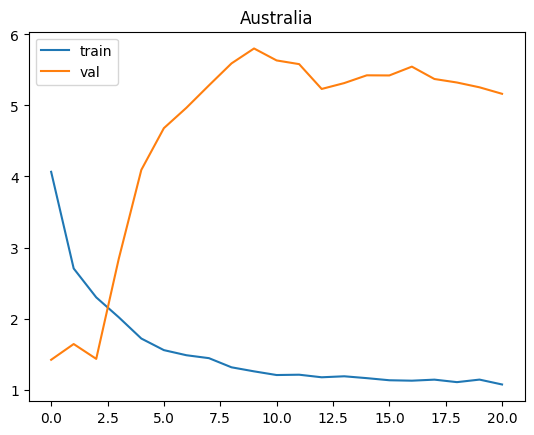

Hawaii
Epoch 0: train loss 2.6920, val loss 1.5188, time 0.1057
Epoch 1: train loss 1.9391, val loss 0.8691, time 0.0898
Epoch 2: train loss 1.6564, val loss 0.7415, time 0.0905
Epoch 3: train loss 1.6203, val loss 0.8465, time 0.0930
Epoch 4: train loss 1.4824, val loss 0.8372, time 0.0906
Epoch 5: train loss 1.4140, val loss 0.8114, time 0.0895
Epoch 6: train loss 1.3426, val loss 0.7799, time 0.0907
Epoch 7: train loss 1.2837, val loss 0.7240, time 0.0905
Epoch 8: train loss 1.2672, val loss 0.7113, time 0.0944
Epoch 9: train loss 1.2062, val loss 0.7303, time 0.0987
Epoch 10: train loss 1.2133, val loss 0.7501, time 0.1019
Epoch 11: train loss 1.1849, val loss 0.6946, time 0.0939
Epoch 12: train loss 1.1544, val loss 0.7778, time 0.0966
Epoch 13: train loss 1.1080, val loss 0.8050, time 0.0968
Epoch 14: train loss 1.1264, val loss 0.8510, time 0.0952
Epoch 15: train loss 1.1067, val loss 0.8535, time 0.0956
Epoch 16: train loss 1.1003, val loss 0.8557, time 0.0949
Epoch 17: train l

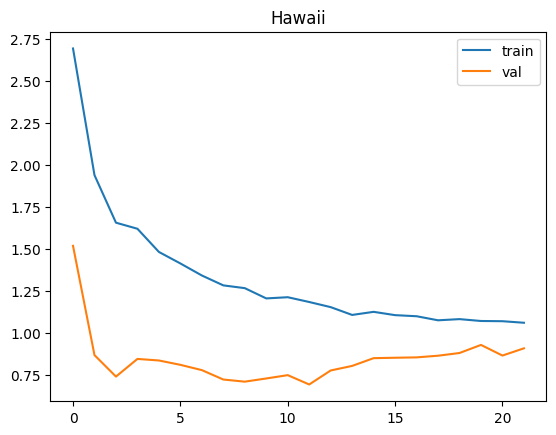

Austria
Epoch 0: train loss 3.8403, val loss 2.8731, time 0.0818
Epoch 1: train loss 2.9430, val loss 2.9482, time 0.0710
Epoch 2: train loss 2.4954, val loss 2.8565, time 0.0722
Epoch 3: train loss 2.5151, val loss 2.1139, time 0.0728
Epoch 4: train loss 2.1869, val loss 1.0464, time 0.0715
Epoch 5: train loss 2.1589, val loss 0.7939, time 0.0709
Epoch 6: train loss 1.8200, val loss 0.7451, time 0.0717
Epoch 7: train loss 1.8845, val loss 1.0660, time 0.0709
Epoch 8: train loss 1.7599, val loss 1.4500, time 0.0718
Epoch 9: train loss 1.6838, val loss 1.5925, time 0.0744
Epoch 10: train loss 1.6390, val loss 1.7096, time 0.0718
Epoch 11: train loss 1.5796, val loss 1.8949, time 0.0715
Epoch 12: train loss 1.5103, val loss 2.1023, time 0.0729
Epoch 13: train loss 1.5005, val loss 2.2675, time 0.0721
Epoch 14: train loss 1.4793, val loss 2.3814, time 0.0712
Epoch 15: train loss 1.4821, val loss 2.5118, time 0.0720
Epoch 16: train loss 1.4455, val loss 2.6871, time 0.0741
Epoch 17: train 

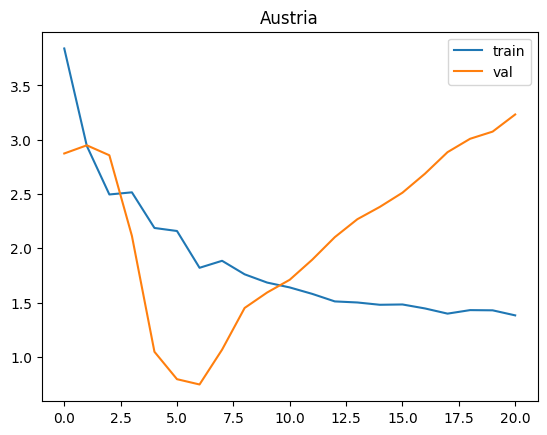

Czech
Epoch 0: train loss 4.6950, val loss 0.7511, time 0.0403
Epoch 1: train loss 3.5343, val loss 0.7176, time 0.0354
Epoch 2: train loss 3.2005, val loss 0.6828, time 0.0356
Epoch 3: train loss 3.3284, val loss 0.7168, time 0.0349
Epoch 4: train loss 3.1297, val loss 0.6957, time 0.0343
Epoch 5: train loss 2.7375, val loss 0.6413, time 0.0347
Epoch 6: train loss 3.0158, val loss 0.6324, time 0.0344
Epoch 7: train loss 2.4210, val loss 0.7151, time 0.0344
Epoch 8: train loss 2.7004, val loss 0.9008, time 0.0359
Epoch 9: train loss 2.5526, val loss 1.0753, time 0.0350
Epoch 10: train loss 2.3680, val loss 1.1796, time 0.0347
Epoch 11: train loss 2.3914, val loss 1.3216, time 0.0345
Epoch 12: train loss 2.1649, val loss 1.5411, time 0.0341
Epoch 13: train loss 1.9773, val loss 1.7124, time 0.0340
Epoch 14: train loss 1.9143, val loss 1.7772, time 0.0350
Epoch 15: train loss 1.8766, val loss 1.8285, time 0.0347
Epoch 16: train loss 1.8994, val loss 1.9213, time 0.0344
Epoch 17: train lo

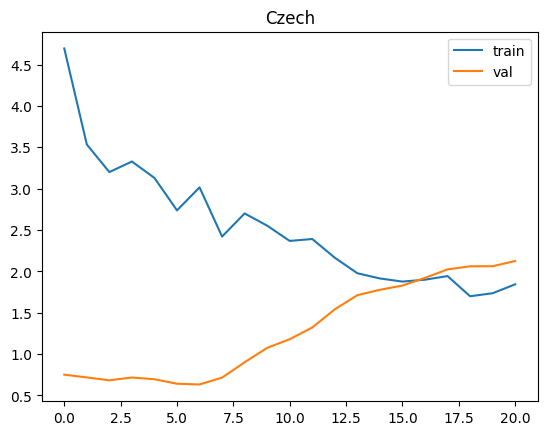

In [197]:
best_param = ({'seq_len': 24, 'batch_size': 64}, 
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'rmsprop', 'lr': 0.0005})
output_size=12

rnn_sep_pred, rnn_sep_gt = [], []
rnn_sep_sample = [[] for _ in range(100)]

for i, country in enumerate(country_list):
    print(country)
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                                          output_len=output_size, test_size=1)

    model = ForecastModel(**best_param[1], input_size=22, output_size=12, conditional_labels=country_list)
    optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
    criterion = get_torch_criterion('mase')

    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y, mases=train_mase)# (model.num_layers, model.hidden_size))
    test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y, mases=test_mase)# (model.num_layers, model.hidden_size))
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, early_stop_patience=10, cuda=True, epochs=100, mase=True)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(country)
    plt.legend()
    plt.show()
    
    rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

    _, ds_x, ds_y, _ = test_dataset.__getitem__(0)
    # rnn_sep_pred.append(inverse_target(rnn_preds[0], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
    #                                y_scaler if single_y_scaler else y_scaler[country]))
    # rnn_sep_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
    #                              y_scaler if single_y_scaler else y_scaler[country]))
    rnn_sep_pred.append(inverse_target(rnn_preds[0], 0., y_scaler if single_y_scaler else y_scaler[country]))
    rnn_sep_gt.append(inverse_target(ds_y, 0., y_scaler if single_y_scaler else y_scaler[country]))
    for j in range(100):
        rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, dropout=True, mase=True)
        # rnn_sep_sample[j].append(inverse_target(rnn_preds[0], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
        #                        y_scaler if single_y_scaler else y_scaler[country]))
        rnn_sep_sample[j].append(inverse_target(rnn_preds[0], 0., y_scaler if single_y_scaler else y_scaler[country]))

rnn_sep_gt = np.concatenate(rnn_sep_gt)
rnn_sep_pred = np.concatenate(rnn_sep_pred)
for j in range(100):
    rnn_sep_sample[j] = np.concatenate(rnn_sep_sample[j])
rnn_sep_sample = np.asarray(rnn_sep_sample)

In [198]:
ci = get_confidence_interval(rnn_sep_sample)
rnn_sep_lower = rnn_sep_pred - ci
rnn_sep_upper = rnn_sep_pred + ci

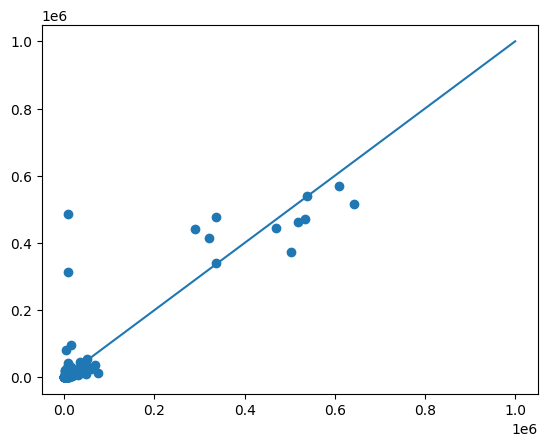

In [199]:
plt.scatter(all_y, rnn_sep_pred)
plt.plot((0, 1000000), (0, 1000000))

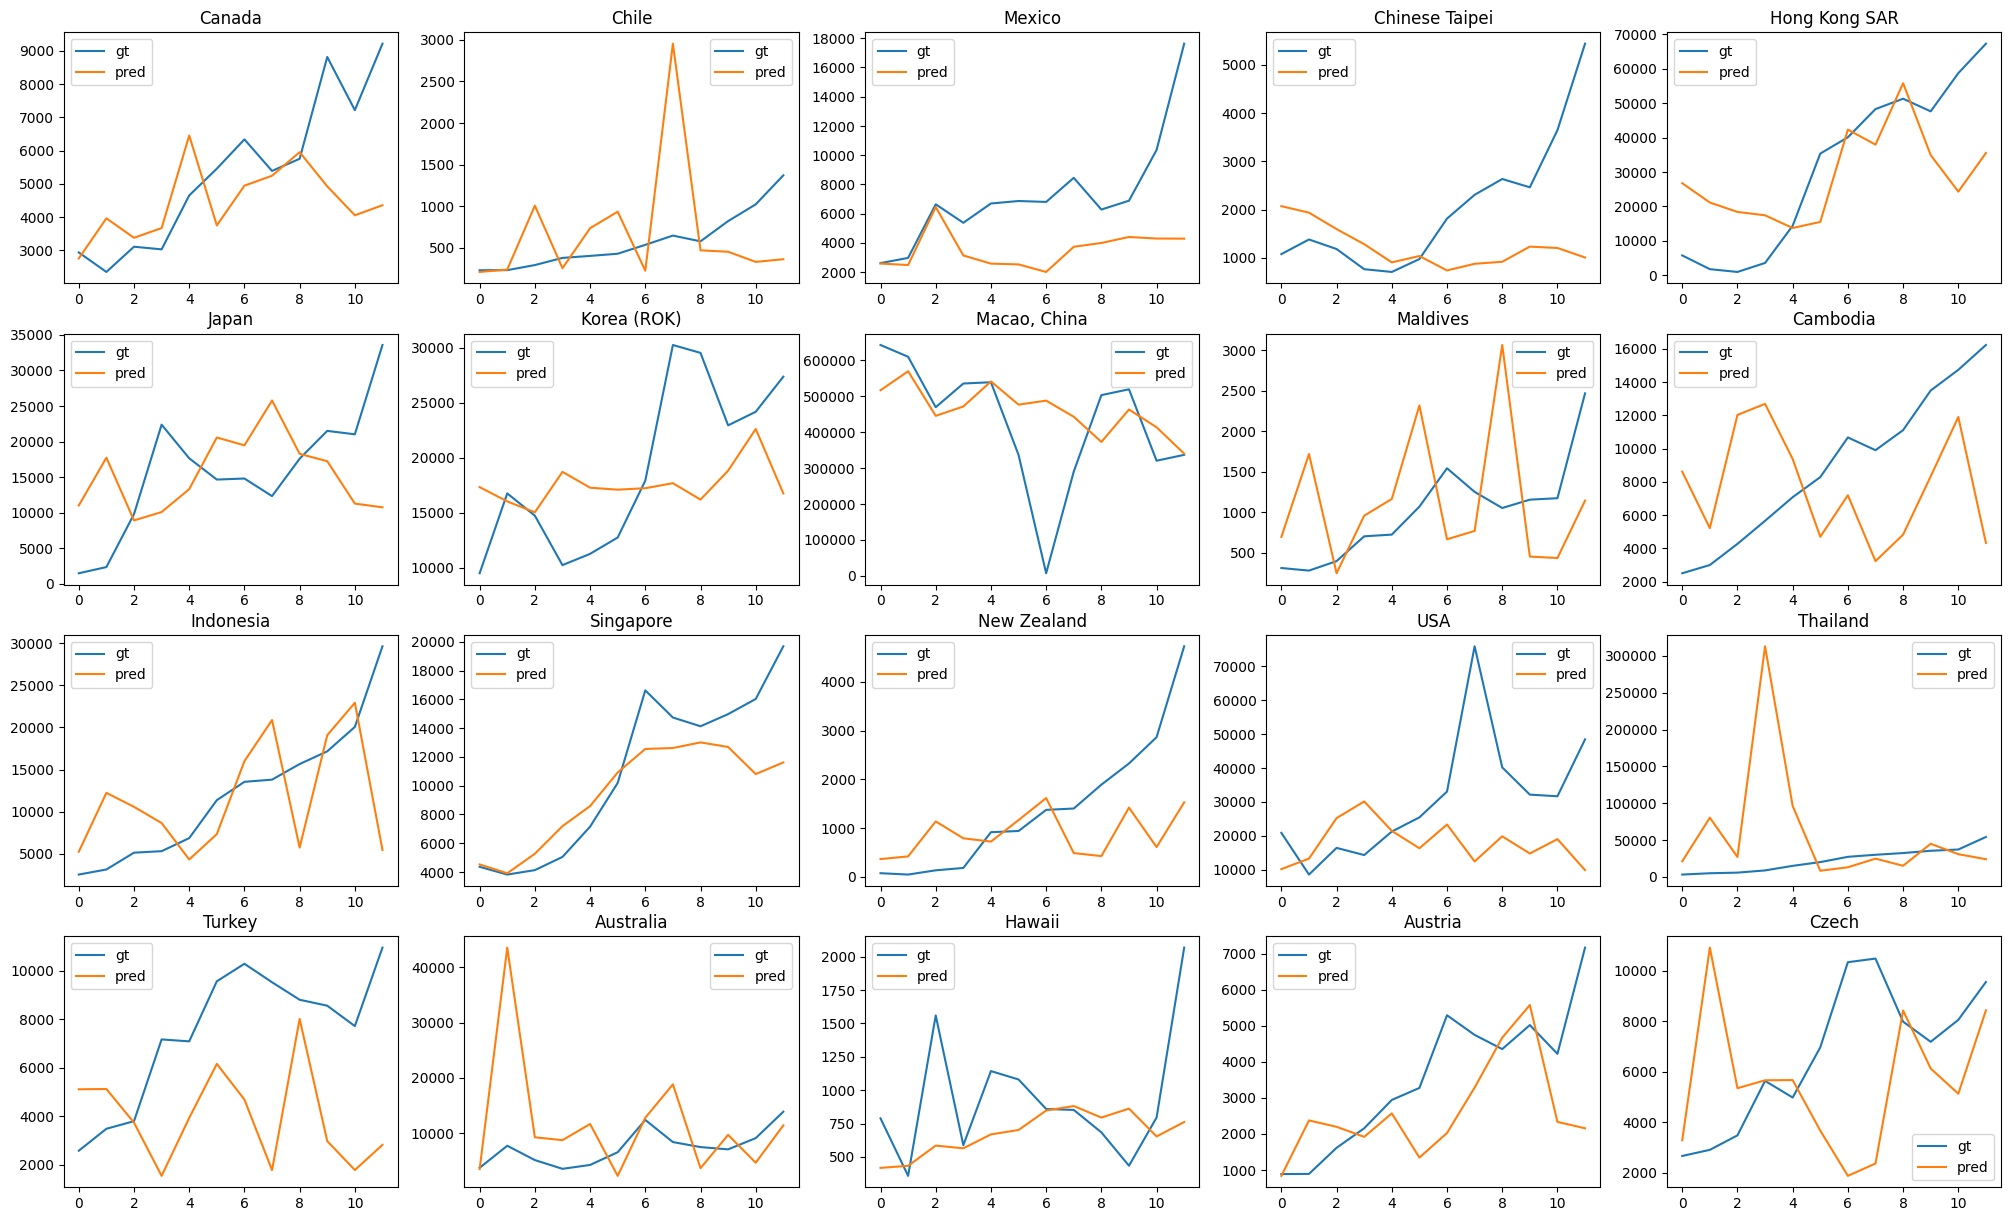

In [200]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(rnn_sep_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [240]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
rnn_sep_mae = mean_absolute_error(all_y, rnn_sep_pred)
rnn_sep_mape = mean_absolute_percentage_error(all_y, rnn_sep_pred)
rnn_sep_mase = mean_absolute_scaled_error(all_y, rnn_sep_pred, y_mase_scales)
rnn_sep_winkler = winkler_score(rnn_sep_lower, rnn_sep_upper, all_y)
print(f'RNN Sep RMSE: {rnn_sep_rmse:.5f}\nRNN Sep R2: {rnn_sep_r2:.5f}\nRNN Sep MAE: {rnn_sep_mae:.5f}'
      f'\nRNN Sep MAPE: {rnn_sep_mape:.5f}\nRNN Sep MASE: {rnn_sep_mase:.5f}\nRNN Sep Winkler: {rnn_sep_winkler:.5f}')

RNN Sep RMSE: 43234.37694
RNN Sep R2: 0.80859
RNN Sep MAE: 12276.80500
RNN Sep MAPE: 1.34418
RNN Sep MASE: 0.39757
RNN Sep Winkler: 110099.66419


# Ensemble RNN models

In [246]:
for w in range(10):
    w = w / 10
    ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred
    ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
    print(f'Weight: {w}, RMSE: {ens_rmse:.5f}')
w = 0.5
ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred
ensemble_sample = w * rnn_sep_sample + (1 - w) * rnn_os_sample

Weight: 0.0, RMSE: 41961.08304
Weight: 0.1, RMSE: 39192.61270
Weight: 0.2, RMSE: 36928.67434
Weight: 0.3, RMSE: 35266.56844
Weight: 0.4, RMSE: 34293.91133
Weight: 0.5, RMSE: 34069.79951
Weight: 0.6, RMSE: 34608.78657
Weight: 0.7, RMSE: 35876.48792
Weight: 0.8, RMSE: 37799.66128
Weight: 0.9, RMSE: 40284.53841


In [247]:
ci = get_confidence_interval(ensemble_sample)
ensemble_lower = ensemble_pred - ci
ensemble_upper = ensemble_pred + ci

In [249]:
rnn_ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
rnn_ens_r2 = r2_score(all_y, ensemble_pred)
rnn_ens_mae = mean_absolute_error(all_y, ensemble_pred)
rnn_ens_mape = mean_absolute_percentage_error(all_y, ensemble_pred)
rnn_ens_mase = mean_absolute_scaled_error(all_y, ensemble_pred, y_mase_scales)
rnn_ens_winkler = winkler_score(ensemble_lower, ensemble_upper, all_y)

print(f'RNN Ensemble RMSE: {rnn_ens_rmse:.5f}\nRNN Ensemble R2: {rnn_ens_r2:.5f}\nRNN Ensemble MAE: {rnn_ens_mae:.5f}'
      f'\nRNN Ensemble MAPE: {rnn_ens_mape:.5f}\nRNN Ensemble MASE: {rnn_ens_mase:.5f}\nRNN Ensemble Winkler: {rnn_ens_winkler:.5f}')

RNN Ensemble RMSE: 34069.79951
RNN Ensemble R2: 0.88114
RNN Ensemble MAE: 10784.88882
RNN Ensemble MAPE: 1.05902
RNN Ensemble MASE: 0.34205
RNN Ensemble Winkler: 99216.31482


In [7]:
# swap green to RNNe
temp = plt.rcParams['axes.prop_cycle'].by_key()['color']
# temp[2], temp[5] = temp[5], temp[2]

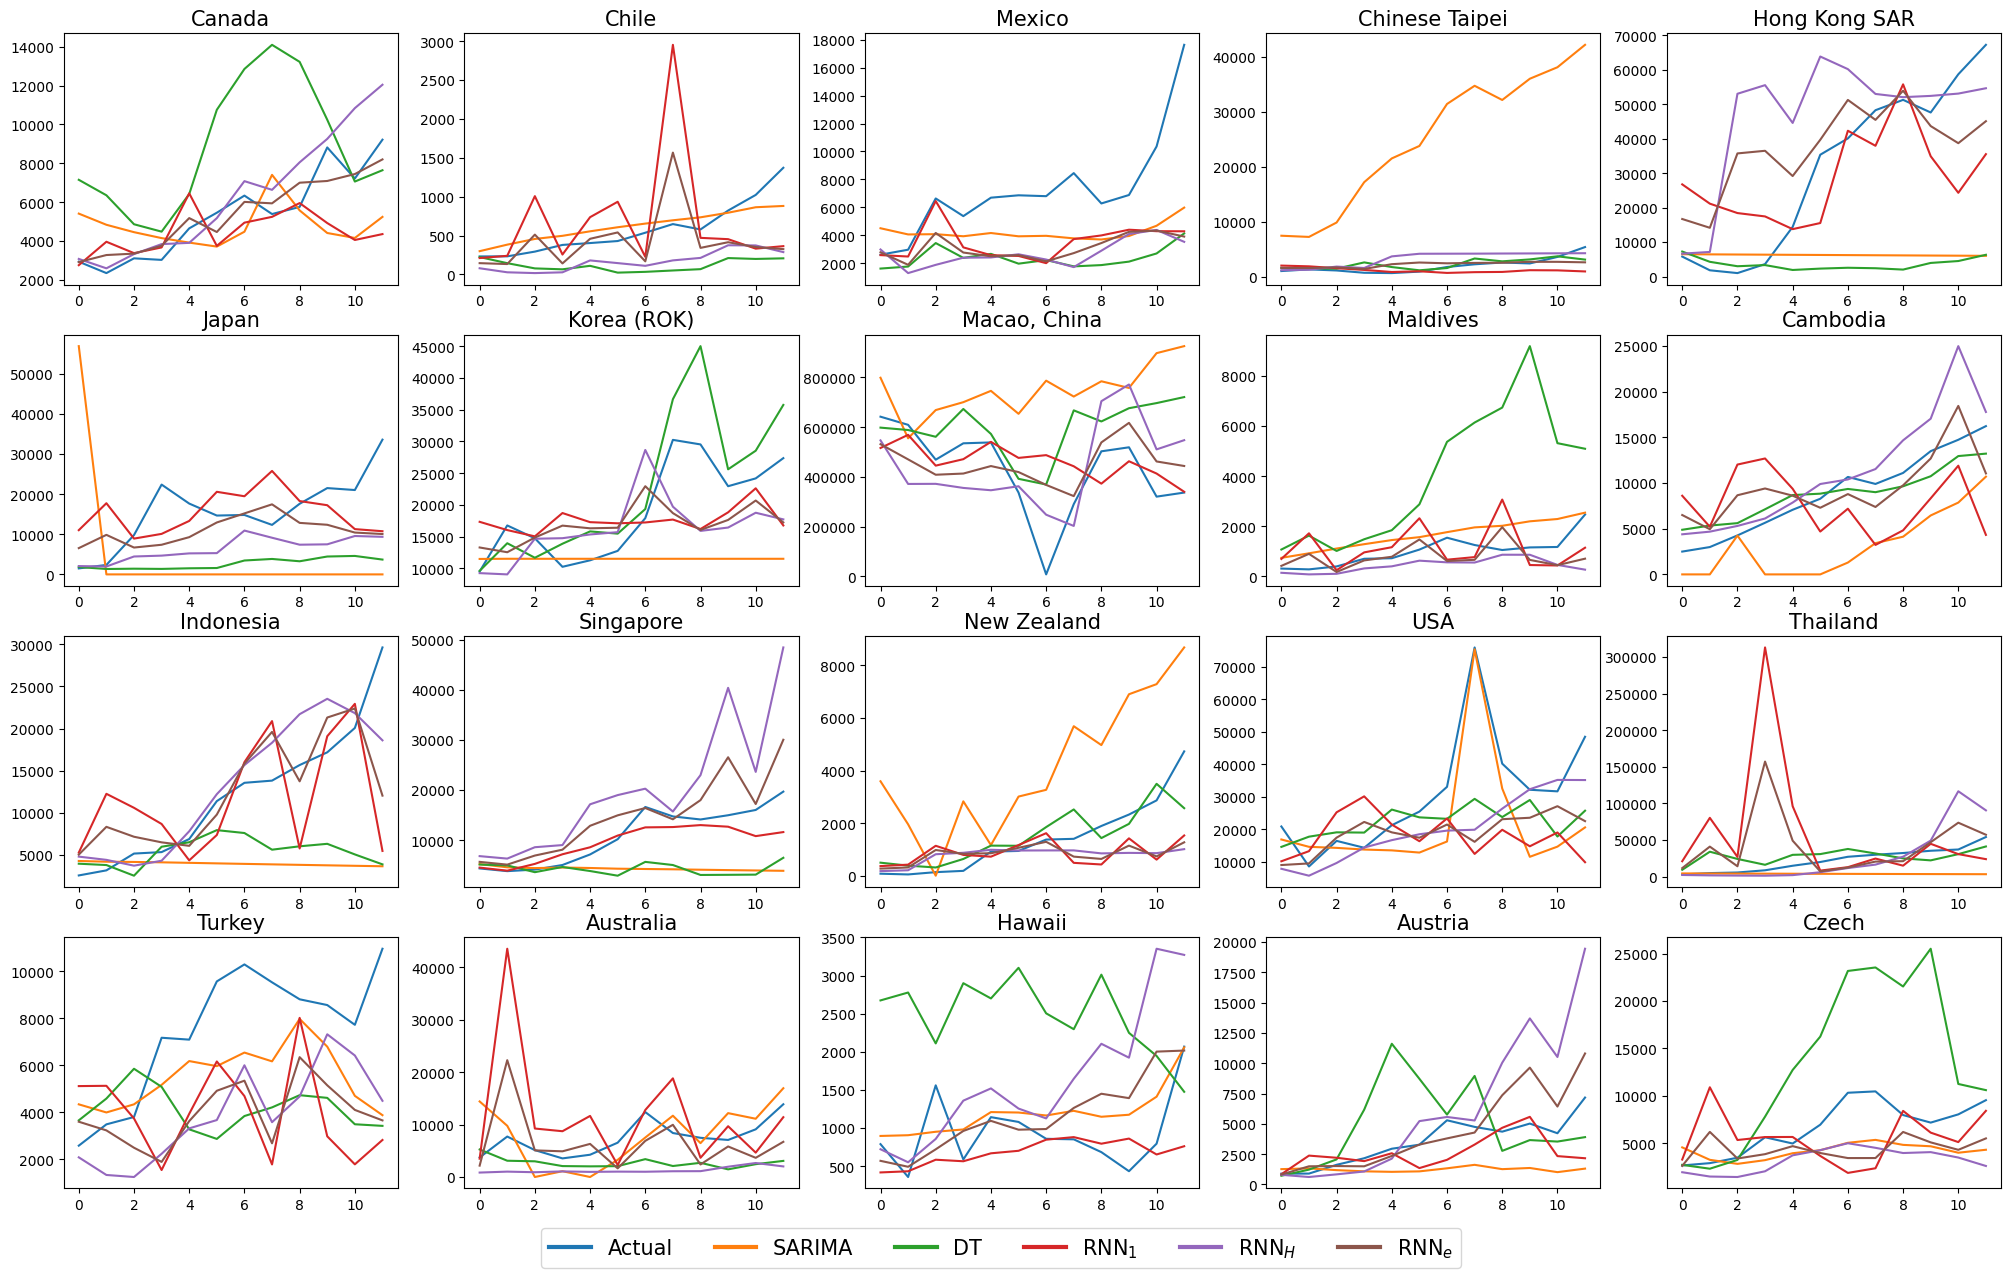

In [8]:
fig = plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='Actual', color=temp[0])
    plt.plot(sarima_pred[i*12:i*12+12].clip(0,), label='SARIMA', color=temp[1])
    
    plt.plot(reg_comb_pred[i*12:i*12+12], label='DT', color=temp[2])
    plt.plot(rnn_sep_pred[i*12:i*12+12], label='RNN$_1$', color=temp[3])
    plt.plot(rnn_os_pred[i*12:i*12+12], label='RNN$_H$', color=temp[4])
    plt.plot(ensemble_pred[i*12:i*12+12], label='RNN$_e$', color=temp[5])
    # plt.legend()
    plt.title(country, fontsize=15)
    # plt.ylim(-10, top=all_y[i*12:i*12+12].max()*1.1)

handles, labels = plt.gca().get_legend_handles_labels()
leg = fig.legend(handles, labels, fontsize=15, loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0.05))
for legobj in leg.legend_handles:
    legobj.set_linewidth(3.0)
plt.show()

# Final Run
Using RNN forecast 18 months at once and also forecast one month at a time

In [343]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 'CovidCases', 'CovidDeaths', 'TravelPolicy', 'GlobalCovidTrend',
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'
def sliding_window_full(df, input_len=100, output_len=12,):
    df = df.copy().dropna()
    x, y, mase = [], [], []
    for i in range(len(df) - input_len - output_len + 1):
        x.append(df[country_feat + universal_feat + [target]].iloc[i: i + input_len])
        y.append(df[target].iloc[i + input_len: i + input_len + output_len].values)
        m = []
        for j in range(output_len):
            m.append(compute_mase_scale(df[target].iloc[: i + input_len + j].values, h=0))
        mase.append(m)
    y = np.asarray(y)
    mase = np.asarray(mase)
    return x, y, mase

Epoch 0: train loss 2.3128, time 1.8088
Epoch 1: train loss 1.6151, time 1.5718
Epoch 2: train loss 1.4766, time 1.5688
Epoch 3: train loss 1.4113, time 1.5720
Epoch 4: train loss 1.3767, time 1.5739
Epoch 5: train loss 1.3421, time 1.5764
Epoch 6: train loss 1.3058, time 1.5790
Epoch 7: train loss 1.2782, time 1.5807
Epoch 8: train loss 1.2165, time 1.5746
Epoch 9: train loss 1.1957, time 1.5796
warning not converged


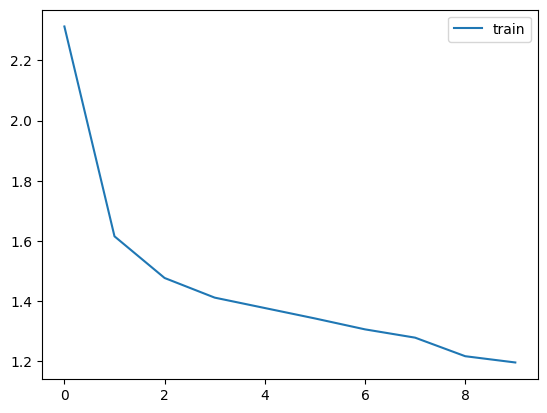

In [344]:
# predicting 18 steps at once
# advantage is that it is numerically stable does not require autoregressive predicting
# disadvantage is model only learn up to 18 timesteps before the forecasting starting point

best_param = ({'seq_len': 24, 'batch_size': 128},
              {'model_type': 'gru', 'num_layers': 3, 'hidden_size': 50},
              {'optim_type': 'rmsprop', 'lr': 0.0005})
output_size = 18
seq_len = best_param[0]['seq_len']
seq_train_x_ori, seq_train_y_ori, train_mase_ori = [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase = sliding_window_full(all_data[country], input_len=best_param[0]['seq_len'], 
                                                               output_len=output_size)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    train_mase_ori.append(train_mase)

seq_train_y_ori = np.concatenate(seq_train_y_ori)
train_mase_ori = np.concatenate(train_mase_ori)

model = ForecastModel(**best_param[1], input_size=23, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori) # (model.num_layers, model.hidden_size))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)

model, train_losses, _ = train_rnn(model, criterion, optimizer, train_dataloader, cuda=True, epochs=10, save_best=False, mase=True)
plt.plot(train_losses, label='train')
# plt.plot(val_losses, label='val')
plt.legend();
torch.save(model.state_dict(), './final_multistep_rnn.pth')


In [345]:
# rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
model.eval()
rnn_preds, dt = [], []
for country, df in all_data.items():
    df = df.copy()
    test_y = df.loc[df['VisitorArrivals'].last_valid_index():].iloc[1:]
    required_steps = math.ceil(len(test_y) / output_size)
    preds = []
    for i in range(required_steps):
        test_y_ = test_y.iloc[i*output_size: i*output_size+output_size]
        test_x = df.loc[:test_y_.index[0]].iloc[-seq_len-1:-1]
        # display(test_x)
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x):]
            test_x.iloc[-len(last_pred):, test_x.columns.get_loc('VisitorArrivals')] = last_pred
        # display(test_x)
        # display(test_y_)
        with torch.no_grad():
            init_state = model.get_embeddings([country])
            x_input = torch.from_numpy(test_x[country_feat + universal_feat + [target]].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = model(x_input, init_state).detach().cpu().numpy()[0]
        preds.append(pred)
    preds = np.concatenate(preds)
    dt.append(test_y.index)
    rnn_preds.append(preds[:len(test_y)])

In [346]:
rnn_pred = []

for i, country in enumerate(all_data.keys()):
    rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[dt[i] - pd.DateOffset(years=6)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    

Epoch 0: train loss 1.9049, time 1.8761
Epoch 1: train loss 1.0828, time 1.6340
Epoch 2: train loss 0.9043, time 1.6311
Epoch 3: train loss 0.9292, time 1.6341
Epoch 4: train loss 0.8635, time 1.6471
Epoch 5: train loss 0.8123, time 1.6411
Epoch 6: train loss 0.7878, time 1.6277
Epoch 7: train loss 0.7803, time 1.6352
Epoch 8: train loss 0.7655, time 1.6315
Epoch 9: train loss 0.7634, time 1.6371
warning not converged


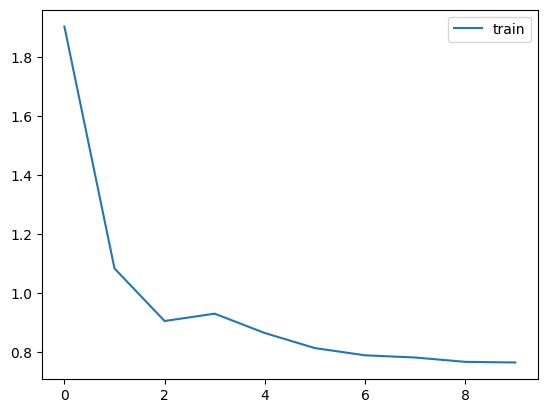

In [348]:
# predicting 1 steps at once
# advantage is model can learn more data and utilize future values to predict
# disadvantage is not as stable because prediction is done autoregressively and error propagates through each time step

best_param = ({'seq_len': 24, 'batch_size': 256},
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 100},
              {'optim_type': 'rmsprop', 'lr': 0.0005})
output_size = 1
seq_len = best_param[0]['seq_len']
seq_train_x_ori, seq_train_y_ori, train_mase_ori = [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase = sliding_window_full(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=output_size)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    train_mase_ori.append(train_mase)

seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()
train_mase_ori = np.concatenate(train_mase_ori)

onestep_model = ForecastModel(**best_param[1], input_size=23, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], onestep_model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)

onestep_model, train_losses, _ = train_rnn(onestep_model, criterion, optimizer, train_dataloader, cuda=True, epochs=10, save_best=False, mase=True)
plt.plot(train_losses, label='train')
# plt.plot(val_losses, label='val')
plt.legend();
torch.save(onestep_model.state_dict(), './final_onestep_rnn.pth')


In [349]:
# rnn_preds, _ = eval_rnn(onestep_model, criterion, test_dataloader)

# auto regressive predictions
onestep_model.eval()
rnn_preds, dt = [], []
for country, df in all_data.items():
    df = df.copy()
    test_y = df.loc[df['VisitorArrivals'].last_valid_index():].iloc[1:]
    required_steps = math.ceil(len(test_y) / output_size)
    preds = []
    for i in range(required_steps):
        test_y_ = test_y.iloc[i*output_size: i*output_size+output_size]
        test_x = df.loc[:test_y_.index[0]].iloc[-seq_len-1:-1]
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x):]
            test_x.iloc[-len(last_pred):, test_x.columns.get_loc('VisitorArrivals')] = last_pred
        with torch.no_grad():
            init_state = onestep_model.get_embeddings([country])
            x_input = torch.from_numpy(test_x[country_feat + universal_feat + [target]].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = onestep_model(x_input, init_state).detach().cpu().numpy()
        preds.append(pred)
    preds = np.concatenate(preds)
    dt.append(test_y.index)
    rnn_preds.append(preds[:len(test_y)])

In [350]:
rnn_onestep_pred = []

for i, country in enumerate(all_data.keys()):
    rnn_onestep_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[dt[i] - pd.DateOffset(years=6)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    

# Ensemble

In [392]:
# ensembling both for whichever make more sense
def make_prediction(multistep_model, onestep_model, seq_len=(24, 36), dropout=False, dropout_p=None):
    multistep_model.eval()
    onestep_model.eval()
    if dropout:
        if dropout_p is not None:
            multistep_model.dropout.p = dropout_p
            onestep_model.dropout.p = dropout_p
            multistep_model.rnn.dropout = dropout_p
            onestep_model.rnn.dropout = dropout_p
        multistep_model.dropout.train()
        onestep_model.dropout.train()
        multistep_model.rnn.train() # to enable dropout in rnn
        onestep_model.rnn.train()
    rnn_preds, dt = [], []
    for country, df in all_data.items():
        output_size = 18
        df = df.copy()
        test_y = df.loc[df['VisitorArrivals'].last_valid_index():].iloc[1:]
        required_steps = math.ceil(len(test_y) / output_size)
        assert required_steps == 1
        preds = []
        for i in range(required_steps):
            test_y_ = test_y.iloc[i*output_size: i*output_size+output_size]
            test_x = df.loc[:test_y_.index[0]].iloc[-seq_len[0]-1:-1]
            if i > 0:
                last_pred = np.concatenate(preds)[-len(test_x):]
                test_x.iloc[-len(last_pred):, test_x.columns.get_loc('VisitorArrivals')] = last_pred

            with torch.no_grad():
                init_state = multistep_model.get_embeddings([country])
                x_input = torch.from_numpy(test_x[country_feat + universal_feat + [target]].drop(columns='Country').to_numpy()).float().unsqueeze(0)
                init_state, x_input = init_state.cuda(), x_input.cuda()
                pred = multistep_model(x_input, init_state).detach().cpu().numpy()[0]
            preds.append(pred)
        preds = np.concatenate(preds)
        # one step at a time
        output_size = 1
        required_steps = math.ceil(len(test_y) / output_size)
        onestep_preds = []
        for i in range(required_steps):
            test_y_ = test_y.iloc[i*output_size: i*output_size+output_size]
            test_x = df.loc[:test_y_.index[0]].iloc[-seq_len[1]-1:-1]
            if i > 0:
                last_pred = np.concatenate(onestep_preds)[-len(test_x):]
                test_x.iloc[-len(last_pred):, test_x.columns.get_loc('VisitorArrivals')] = last_pred
            with torch.no_grad():
                init_state = onestep_model.get_embeddings([country])
                x_input = torch.from_numpy(test_x[country_feat + universal_feat + [target]].drop(columns='Country').to_numpy()).float().unsqueeze(0)
                init_state, x_input = init_state.cuda(), x_input.cuda()
                pred = onestep_model(x_input, init_state).detach().cpu().numpy()
            onestep_preds.append(pred)
        onestep_preds = np.concatenate(onestep_preds)
        
        preds = inverse_target(preds[:len(test_y)], all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=6)].values if deduct_seasonality else 0.,
                               y_scaler if single_y_scaler else y_scaler[country])
        onestep_preds = inverse_target(onestep_preds[:len(test_y)], all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=6)].values if deduct_seasonality else 0.,
                                       y_scaler if single_y_scaler else y_scaler[country])
        
        w = (0.5, 0.5)
        rnn_pred = w[0] * preds + (w[1]) * onestep_preds
        rnn_preds.append(rnn_pred)
        dt.append(test_y.index)
    return rnn_preds, dt

In [359]:
multistep_model = ForecastModel(model_type='gru', num_layers=3, hidden_size=50, input_size=23, output_size=18, conditional_labels=country_list)
multistep_model.load_state_dict(torch.load('./final_multistep_rnn.pth'))
multistep_model.cuda()
onestep_model = ForecastModel(model_type='gru', num_layers=1, hidden_size=100, input_size=23, output_size=1, conditional_labels=country_list)
onestep_model.load_state_dict(torch.load('./final_onestep_rnn.pth'))
onestep_model.cuda()

ForecastModel(
  (rnn): GRU(23, 100, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (cond_emb): Embedding(20, 100)
)

In [393]:
ensemble_rnn, dt = make_prediction(multistep_model, onestep_model)

In [364]:
# plot
def final_process(rnn_pred, dt, plot=False, rescale=True):
    rnn_pred = rnn_pred.copy()
    if plot:
        fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 15))
    pred_dfs = []

    for i, (country, country_df) in enumerate(all_data.items()):
        if plot:
            row, col = i // 5, i % 5
            ax = axes[row, col]
        # print(row, col)
        country_df = country_df.copy()

        seasonal_component = get_seasonal_component(all_decomposed_seasonal[country], len(country_df))
        assert len(seasonal_component) == len(country_df)
        seasonal_component.index = country_df.index
        seasonal_component[(seasonal_component.index >= '2020-01-01') & (seasonal_component.index <= '2023-01-01')] = 0 # no seasonality during covid
        country_df['VisitorArrivals'] = inverse_target(country_df['VisitorArrivals'], seasonal_component if deduct_seasonality else 0., y_scaler if single_y_scaler else y_scaler[country])
        pred_df = pd.DataFrame({'VisitorArrivals': rnn_pred[i]}, index=dt[i])
        
        # rescaling
        if rescale:
            last = country_df['VisitorArrivals'].dropna().iloc[-1]
            if pred_df['VisitorArrivals'].iloc[0] > last * 1.3:
                diff = (last * 1.2 - pred_df['VisitorArrivals'].iloc[0]) * 0.8
            elif pred_df['VisitorArrivals'].iloc[0] < last * 0.8:
                diff = last * 0.8 - pred_df['VisitorArrivals'].iloc[0]
            else:
                diff = 0
            pred_df['VisitorArrivals'] += diff
        
        if plot:
            start_date = min(dt[i])
            country_df = country_df.iloc[-120:]
            temp_df = country_df['VisitorArrivals'].copy()
            temp_df.loc[pred_df.index] = pred_df['VisitorArrivals']
            if country == 'Hong Kong SAR':
                temp_df.loc[pd.to_datetime('2023-02-01')] = 48275
            split = {'Canada': '2022-12-01', 'Czech': '2022-12-01', 'Japan': '2023-02-01', 'Hong Kong SAR': '2023-01-01', 'Singapore': '2023-02-01', 'USA': '2023-02-01'}.get(country, '2023-01-01')
            temp_df[temp_df.index <= split].plot(ax=ax)
            temp_df[temp_df.index > split].plot(ax=ax)
            ax.set_title(country, fontsize=14)
            ax.set_xlabel('')
            # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            ax.tick_params(axis='x', labelrotation = 45)

            # ax.axvline(pd.to_datetime('2023-07-01'), color='black')
        pred_dfs.append(pred_df[pred_df.index > '2023-07-01'].rename(columns={'VisitorArrivals': country}).astype(int))
        rnn_pred[i] = pred_df['VisitorArrivals'].values

    pred_dfs = pd.concat(pred_dfs, axis=1)
    if plot:
        plt.tight_layout()
        plt.show()
    return pred_dfs, rnn_pred

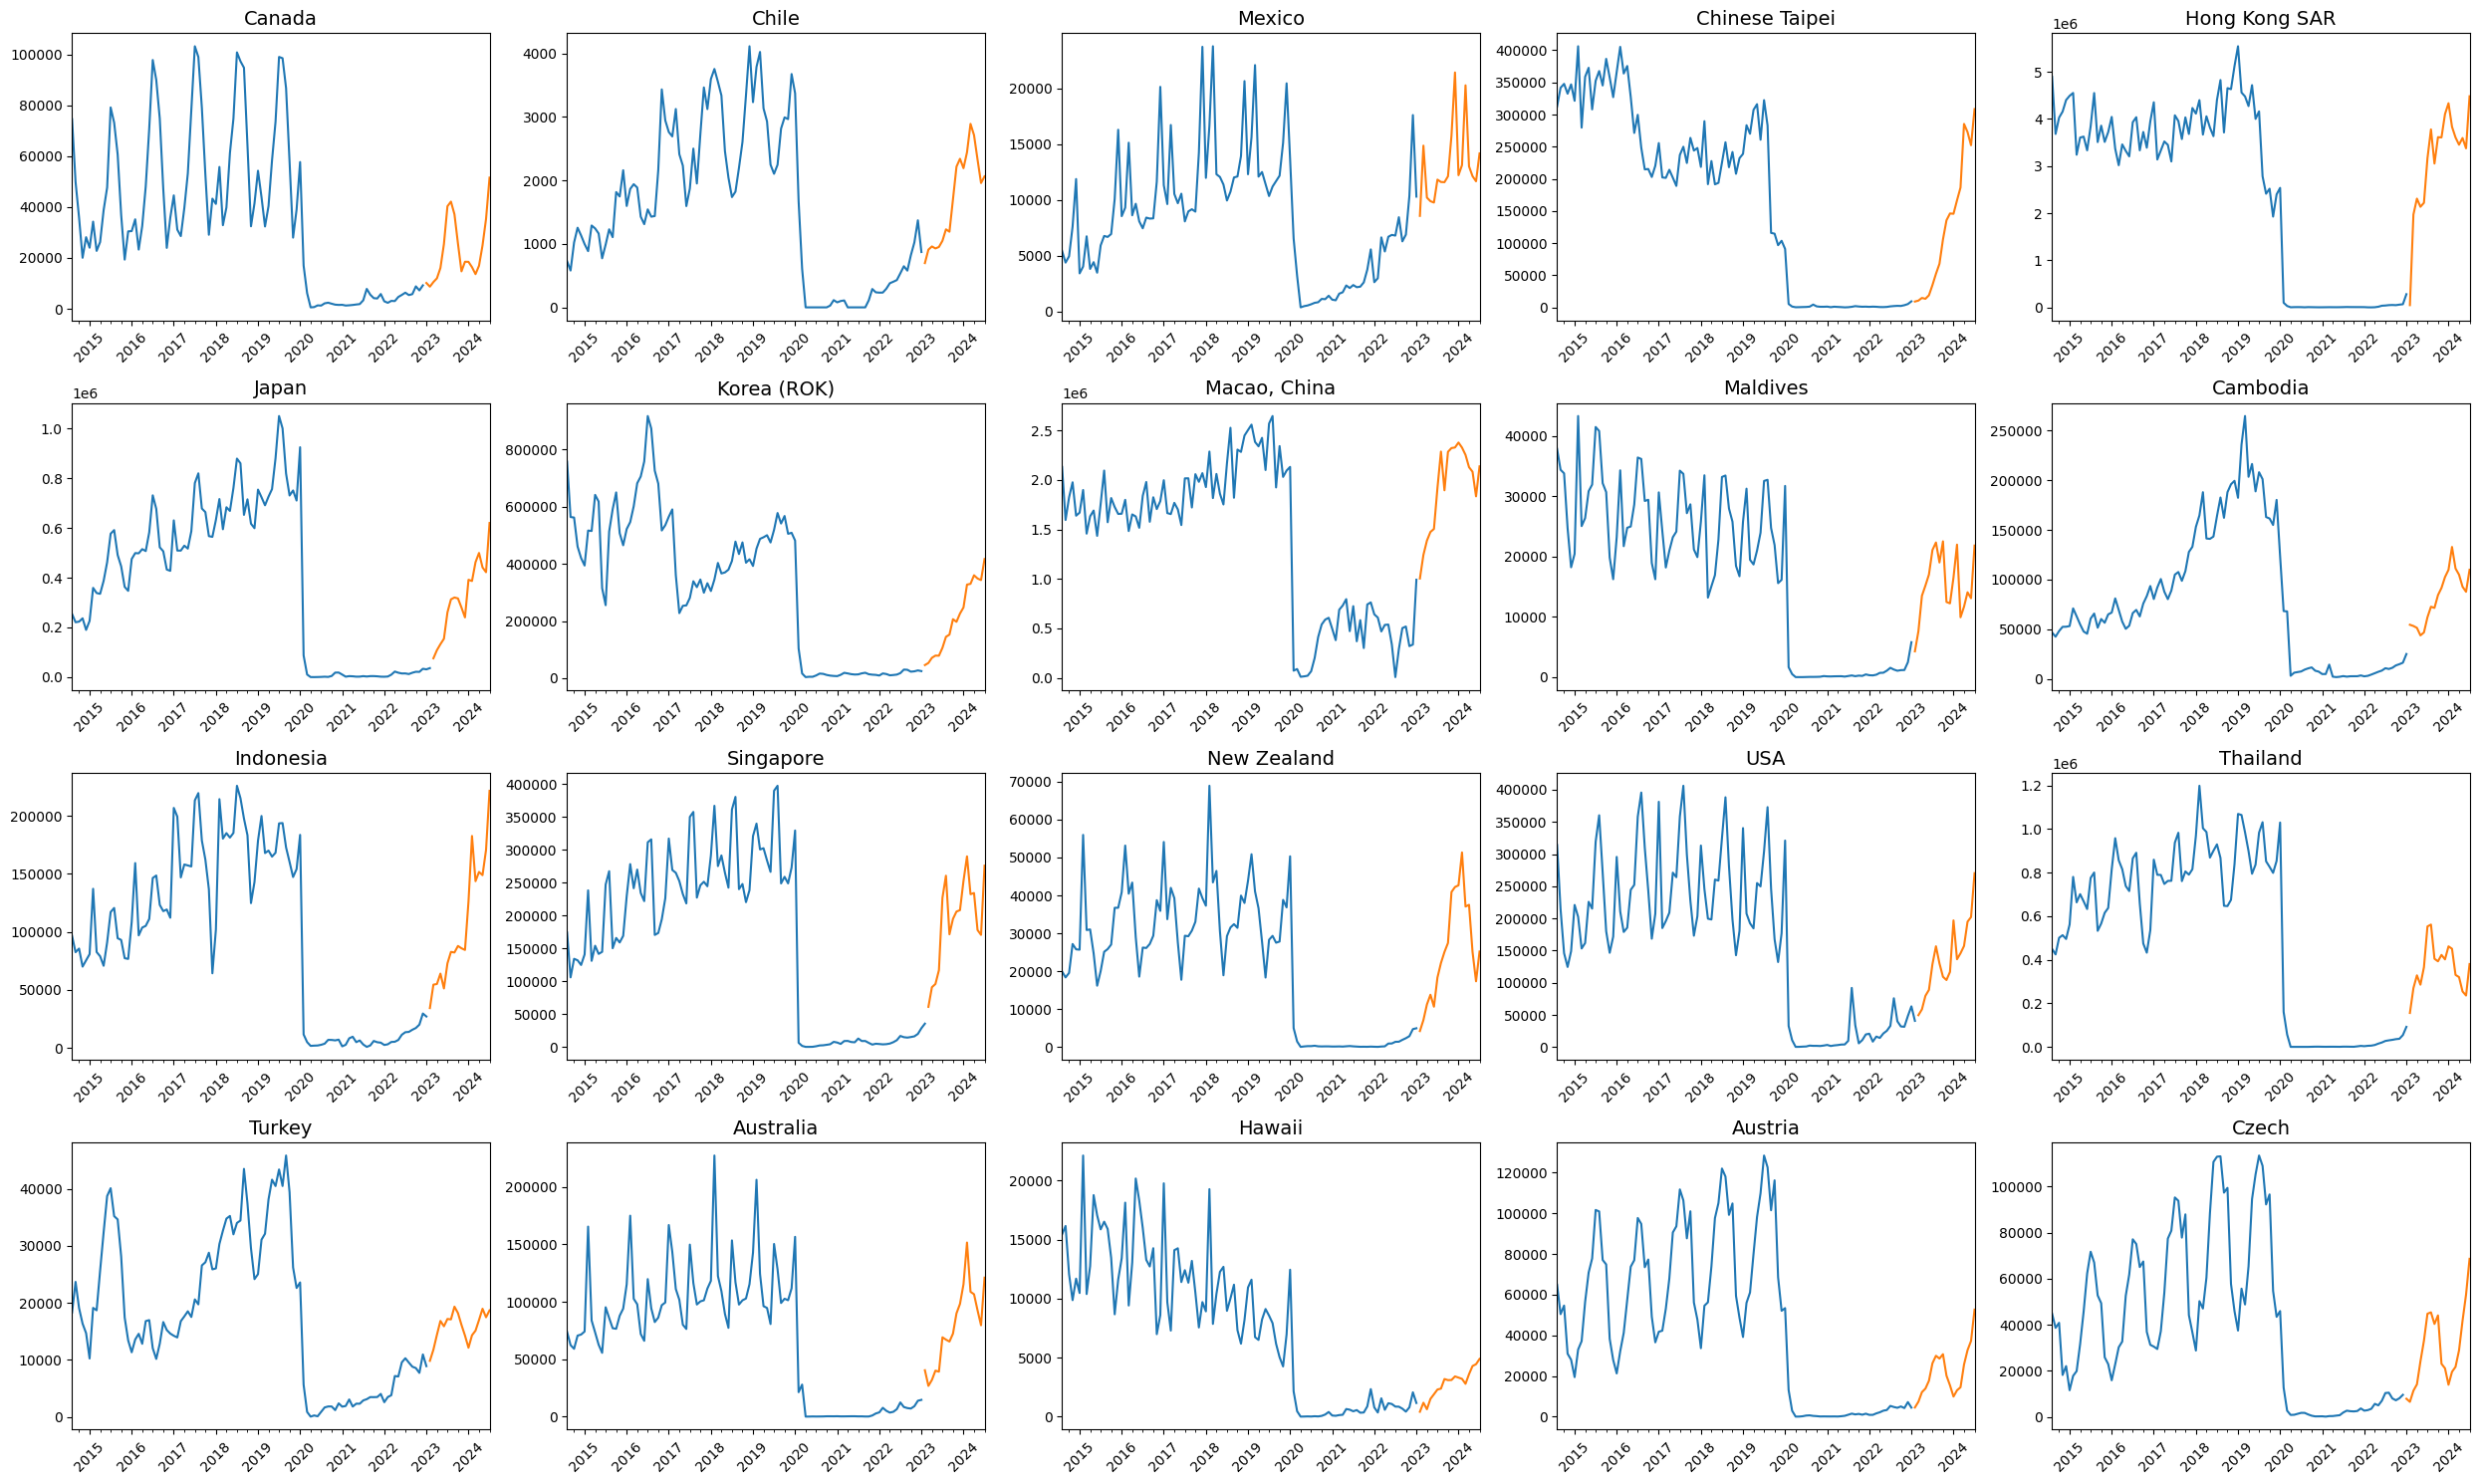

In [395]:
save_path = './data/point_prediction.csv'
pred_dfs, final_pred = final_process(ensemble_rnn, dt, plot=True)
pred_dfs.to_csv(save_path)

In [396]:
pred_dfs

Canada  Chile  Mexico  Chinese Taipei  Hong Kong SAR   Japan  \
Date                                                                       
2023-08-01   42165   1229   11616           52439        3777860  312820   
2023-09-01   37179   1192   11599           68023        3053446  320287   
2023-10-01   25625   1702   12125          105939        3612981  316517   
2023-11-01   14726   2217   15784          135653        3607944  279850   
2023-12-01   18507   2341   21451          146269        4103075  240207   
2024-01-01   18466   2193   12224          145773        4333424  391679   
2024-02-01   16370   2443   13131          166687        3833066  386643   
2024-03-01   13634   2892   20297          186568        3606657  462327   
2024-04-01   16941   2714   13018          285484        3453105  499530   
2024-05-01   24937   2330   12138          272856        3595493  441384   
2024-06-01   35337   1959   11681          252290        3375809  422095   
2024-07-01   51607   2064   14183          308547        4481575  620117   

            Korea (ROK)  Macao, China  Maldives  Cambodia  Indonesia  \
Date                                                                   
2023-08-01       144911       2286825     22350     72647      82779   
2023-09-01       152537       1895557     19033     71455      82280   
2023-10-01       206592       2284341     22538     84350      87897   
2023-11-01       197336       2322452     12473     91594      85889   
2023-12-01       226288       2328301     12245    102553      84478   
2024-01-01       247630       2378093     16547    109859     126184   
2024-02-01       327566       2327133     21995    132877     182717   
2024-03-01       330366       2253456      9930    111201     143743   
2024-04-01       360225       2128992     11695    104928     151709   
2024-05-01       349023       2083154     14083     92827     148948   
2024-06-01       343464       1834463     13094     87710     170709   
2024-07-01       417062       2137569     21841    109906     221683   

            Singapore  New Zealand     USA  Thailand  Turkey  Australia  \
Date                                                                      
2023-08-01     260278        22174  156746    561531   17099      67080   
2023-09-01     171188        25078  130065    404552   19331      65423   
2023-10-01     194643        27454  109301    392847   18204      72295   
2023-11-01     205749        40894  104297    422195   16133      89949   
2023-12-01     207924        42216  116982    401782   14260      98179   
2024-01-01     252427        42661  196930    461415   12129     115307   
2024-02-01     289699        51331  136555    450527   14314     151638   
2024-03-01     232140        37067  145844    330478   15122     108735   
2024-04-01     233971        37511  157194    320299   16995     106620   
2024-05-01     177711        25108  194891    254490   18963      92692   
2024-06-01     170278        17342  202114    235809   17468      79607   
2024-07-01     275554        25197  270332    380211   18689     121074   

            Hawaii  Austria  Czech  
Date                                
2023-08-01    2382    29936  45388  
2023-09-01    3193    28557  40348  
2023-10-01    3098    30711  44066  
2023-11-01    3110    20170  23020  
2023-12-01    3413    15384  21071  
2024-01-01    3315     9869  13920  
2024-02-01    3207    12949  19551  
2024-03-01    2788    14438  21693  
2024-04-01    3603    25621  28877  
2024-05-01    4292    32680  41725  
2024-06-01    4448    37242  53106  
2024-07-01    4894    52632  68663

# Interval Forecast
With Monte Carlo dropout method

In [397]:
def monte_carlo_dropout(trials, initial_pred=None, dropout_p=None):
    trials -= 1
    assert trials > 0
    if initial_pred is None:
        initial_pred, dt = make_prediction(multistep_model, onestep_model, dropout=False)
        _, initial_pred = final_process(initial_pred, dt, plot=False)
    for _ in tqdm(range(trials)):
        dropout_pred, dt = make_prediction(multistep_model, onestep_model, dropout=True, dropout_p=dropout_p)
        _, dropout_pred = final_process(dropout_pred, dt, plot=False)
        for i in range(len(dropout_pred)):
            mc_samples[i].append(dropout_pred[i])

    for i in range(len(mc_samples)):
        mc_samples[i] = np.asarray(mc_samples[i])
    return mc_samples

In [398]:
# plot
def final_interval_process(rnn_pred, dt, lower, upper, plot=False):
    rnn_pred = rnn_pred.copy()
    if plot:
        fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 15))
    pred_dfs = []

    for i, (country, country_df) in enumerate(all_data.items()):
        if plot:
            row, col = i // 5, i % 5
            ax = axes[row, col]
        # print(row, col)
     
        if plot:
            pred_df = pd.DataFrame({'VisitorArrivals': rnn_pred[i]}, index=dt[i])
            pred_df = pred_df[pred_df.index > '2023-07-01']
            start_date = min(dt[i])
            pred_df['VisitorArrivals'].plot(ax=ax)
            ax.fill_between(dt[i], lower[i], upper[i], alpha=.25)

            ax.set_title(country)
            # ax.axvline(start_date, color='black')
            
        pred_df = pd.DataFrame({country + 'Lower': lower[i], country + 'Upper': upper[i]}, index=dt[i])
        pred_dfs.append(pred_df[pred_df.index > '2023-07-01'].astype(int))

    pred_dfs = pd.concat(pred_dfs, axis=1)
    if plot:
        plt.tight_layout()
        plt.show()
    return pred_dfs

In [399]:
trials = 100
mc_samples = [[x] for x in final_pred]

mc_samples = monte_carlo_dropout(trials, mc_samples, dropout_p=0.5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:49<00:00,  2.02it/s]


In [400]:
# all_lower, all_upper = get_confidence_interval(mc_samples, alpha=0.2)
cis = [get_confidence_interval(sample, confidence=0.8) for sample in mc_samples]
all_lower = [p - ci for p, ci in zip(final_pred, cis)]
all_upper = [p + ci for p, ci in zip(final_pred, cis)]

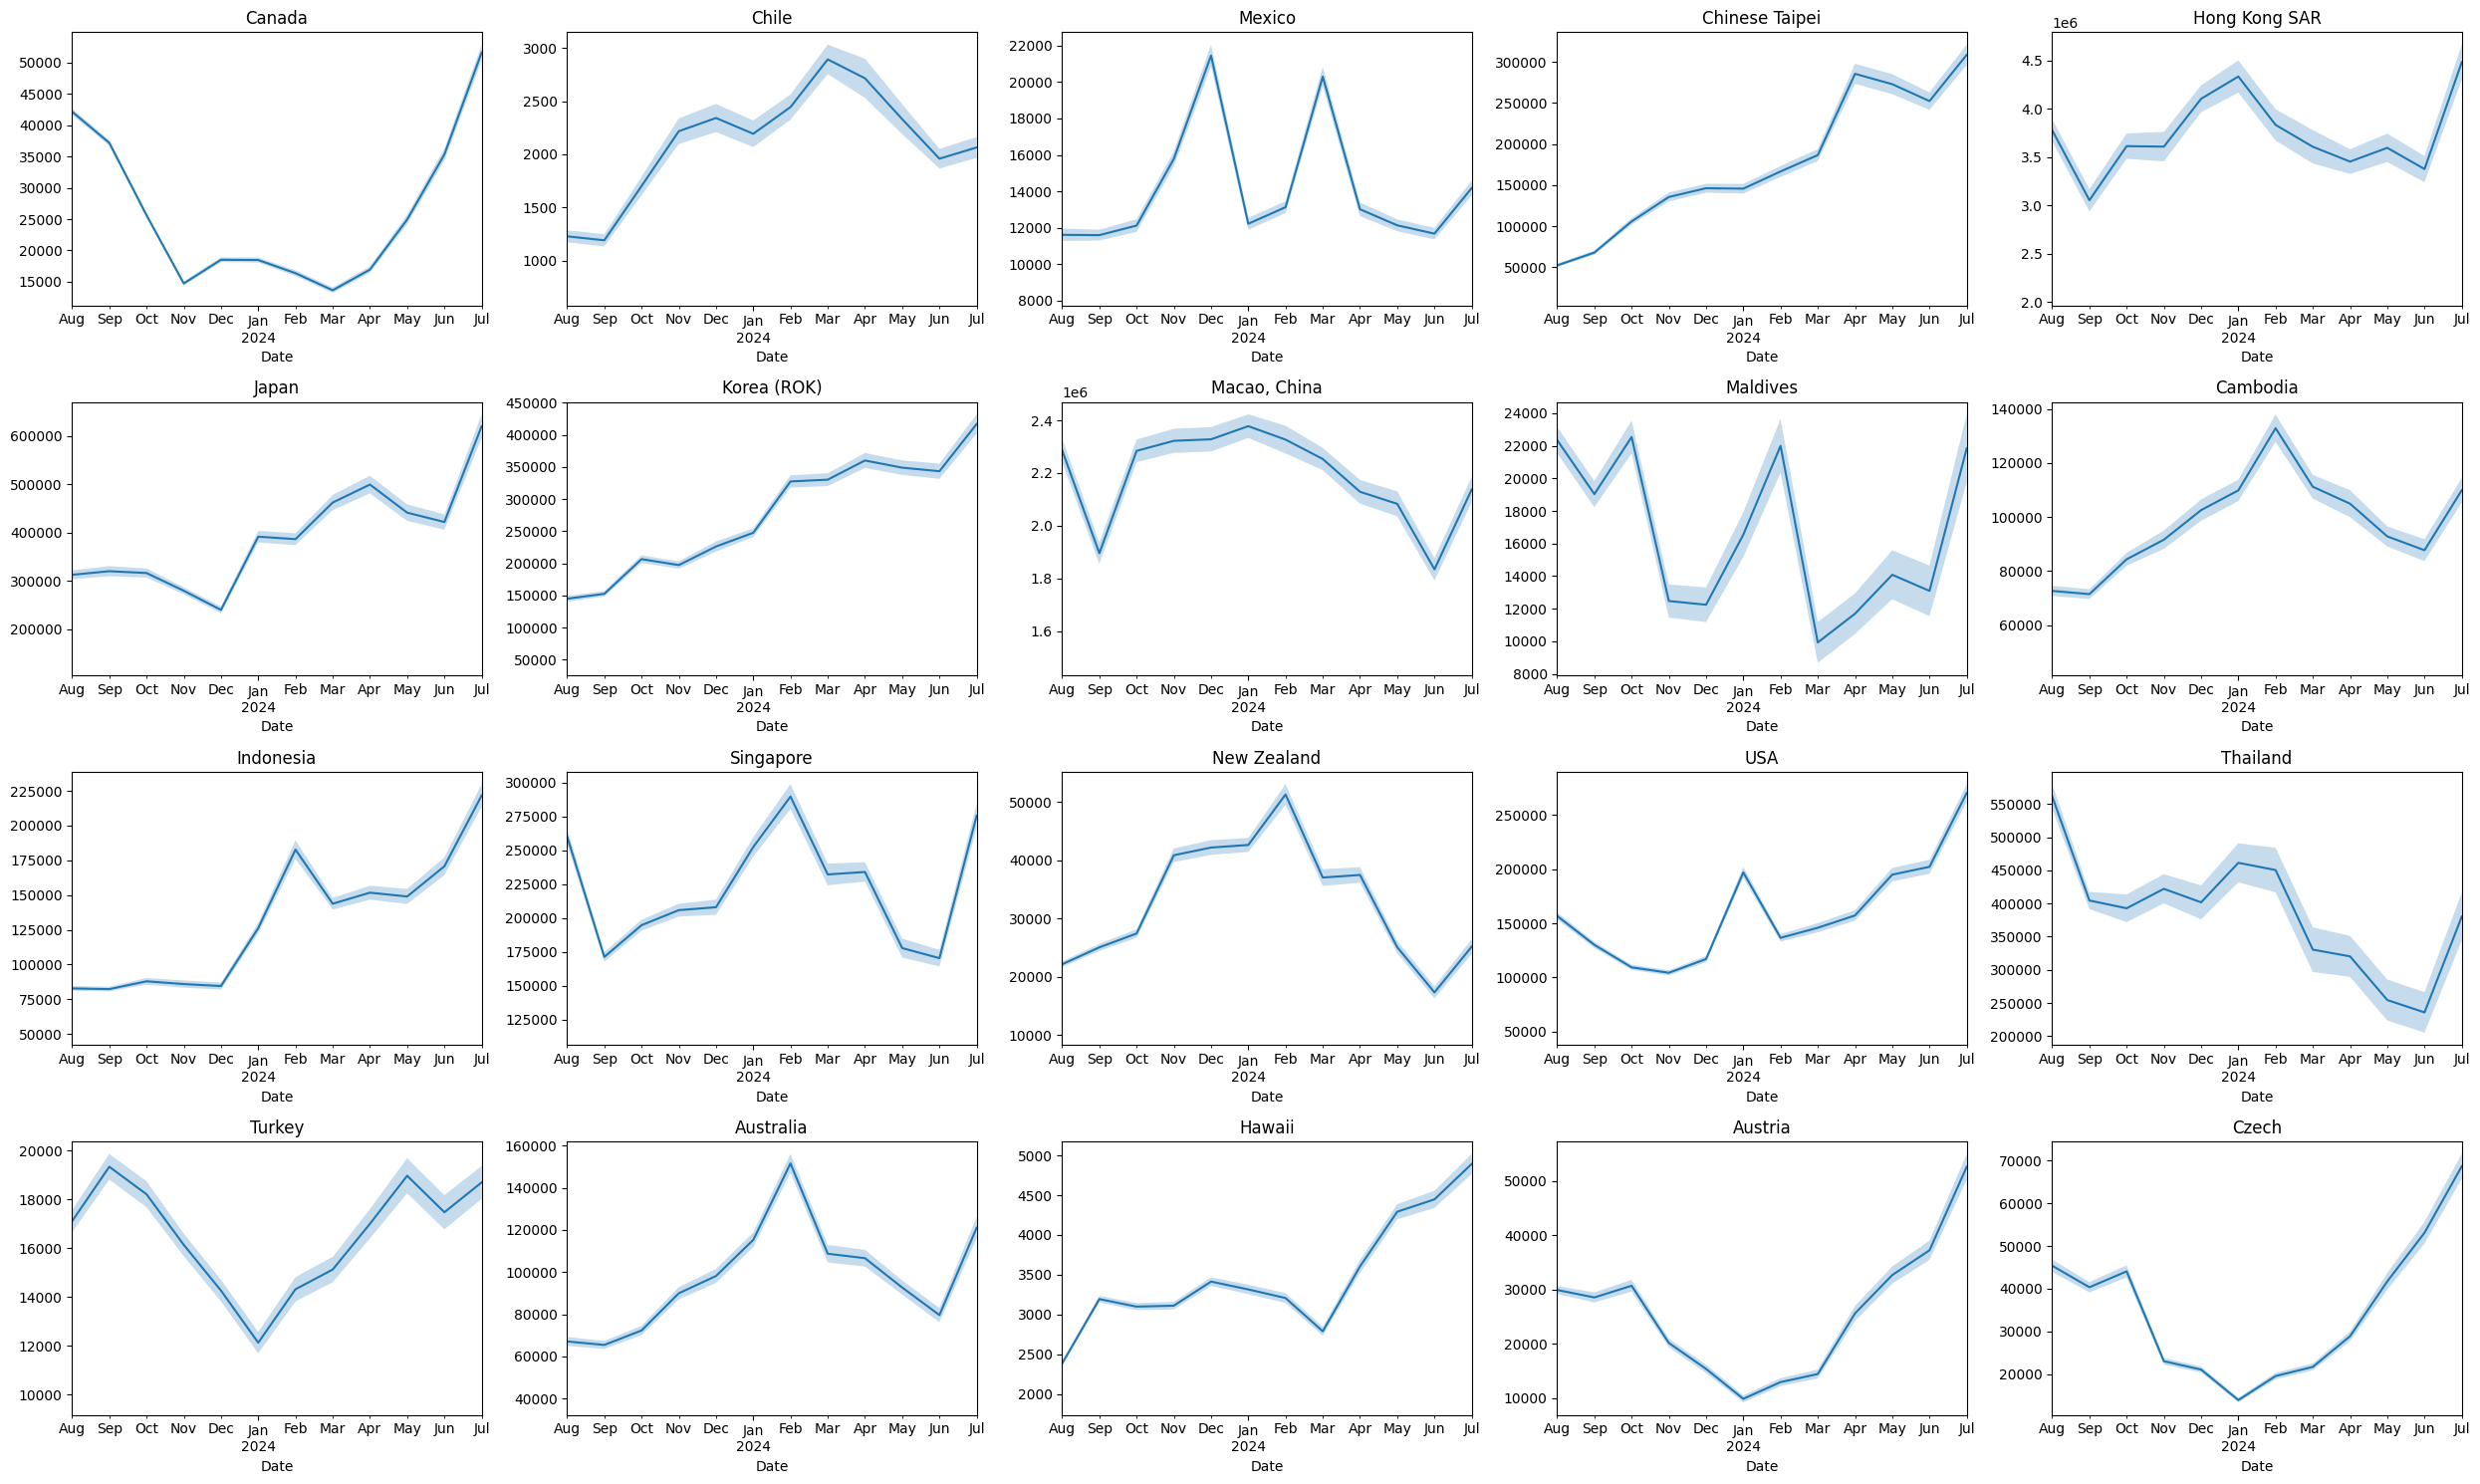

In [402]:
interval_save_path = './data/interval_prediction.csv'
interval_df = final_interval_process(final_pred, dt, all_lower, all_upper, plot=True)
interval_df.to_csv(interval_save_path)

In [403]:
interval_df

CanadaLower  CanadaUpper  ChileLower  ChileUpper  MexicoLower  \
Date                                                                        
2023-08-01        41673        42656        1172        1286        11276   
2023-09-01        36731        37626        1134        1249        11301   
2023-10-01        25259        25992        1614        1789        11781   
2023-11-01        14397        15055        2096        2337        15366   
2023-12-01        18122        18891        2208        2473        20852   
2024-01-01        18053        18880        2067        2318        11895   
2024-02-01        15923        16816        2325        2562        12808   
2024-03-01        13182        14085        2753        3030        19770   
2024-04-01        16428        17454        2530        2898        12638   
2024-05-01        24184        25690        2188        2472        11816   
2024-06-01        34378        36296        1866        2051        11362   
2024-07-01        50344        52870        1966        2162        13769   

            MexicoUpper  Chinese TaipeiLower  Chinese TaipeiUpper  \
Date                                                                
2023-08-01        11955                50363                54515   
2023-09-01        11897                65509                70536   
2023-10-01        12469               101894               109985   
2023-11-01        16201               130219               141087   
2023-12-01        22050               140796               151743   
2024-01-01        12553               139874               151672   
2024-02-01        13455               159987               173388   
2024-03-01        20824               179291               193845   
2024-04-01        13398               273317               297651   
2024-05-01        12460               260653               285059   
2024-06-01        11999               241622               262958   
2024-07-01        14597               296133               320962   

            Hong Kong SARLower  Hong Kong SARUpper  ...  TurkeyLower  \
Date                                                ...                
2023-08-01             3662568             3893152  ...        16644   
2023-09-01             2937243             3169649  ...        18804   
2023-10-01             3481916             3744046  ...        17672   
2023-11-01             3455160             3760727  ...        15671   
2023-12-01             3964133             4242018  ...        13817   
2024-01-01             4166736             4500112  ...        11690   
2024-02-01             3670903             3995229  ...        13815   
2024-03-01             3434346             3778967  ...        14601   
2024-04-01             3324661             3581548  ...        16394   
2024-05-01             3448238             3742747  ...        18242   
2024-06-01             3239888             3511729  ...        16768   
2024-07-01             4299683             4663467  ...        18014   

            TurkeyUpper  AustraliaLower  AustraliaUpper  HawaiiLower  \
Date                                                                   
2023-08-01        17554           64954           69206         2353   
2023-09-01        19857           63527           67318         3151   
2023-10-01        18736           70082           74508         3054   
2023-11-01        16596           87029           92868         3062   
2023-12-01        14702           94859          101498         3360   
2024-01-01        12567          111821          118794         3255   
2024-02-01        14814          147119          156156         3145   
2024-03-01        15643          104563          112907         2732   
2024-04-01        17596          102645          110594         3522   
2024-05-01        19683           89346           96039         4197   
2024-06-01        18168           76225           82989         4339   
2024-07-01        193

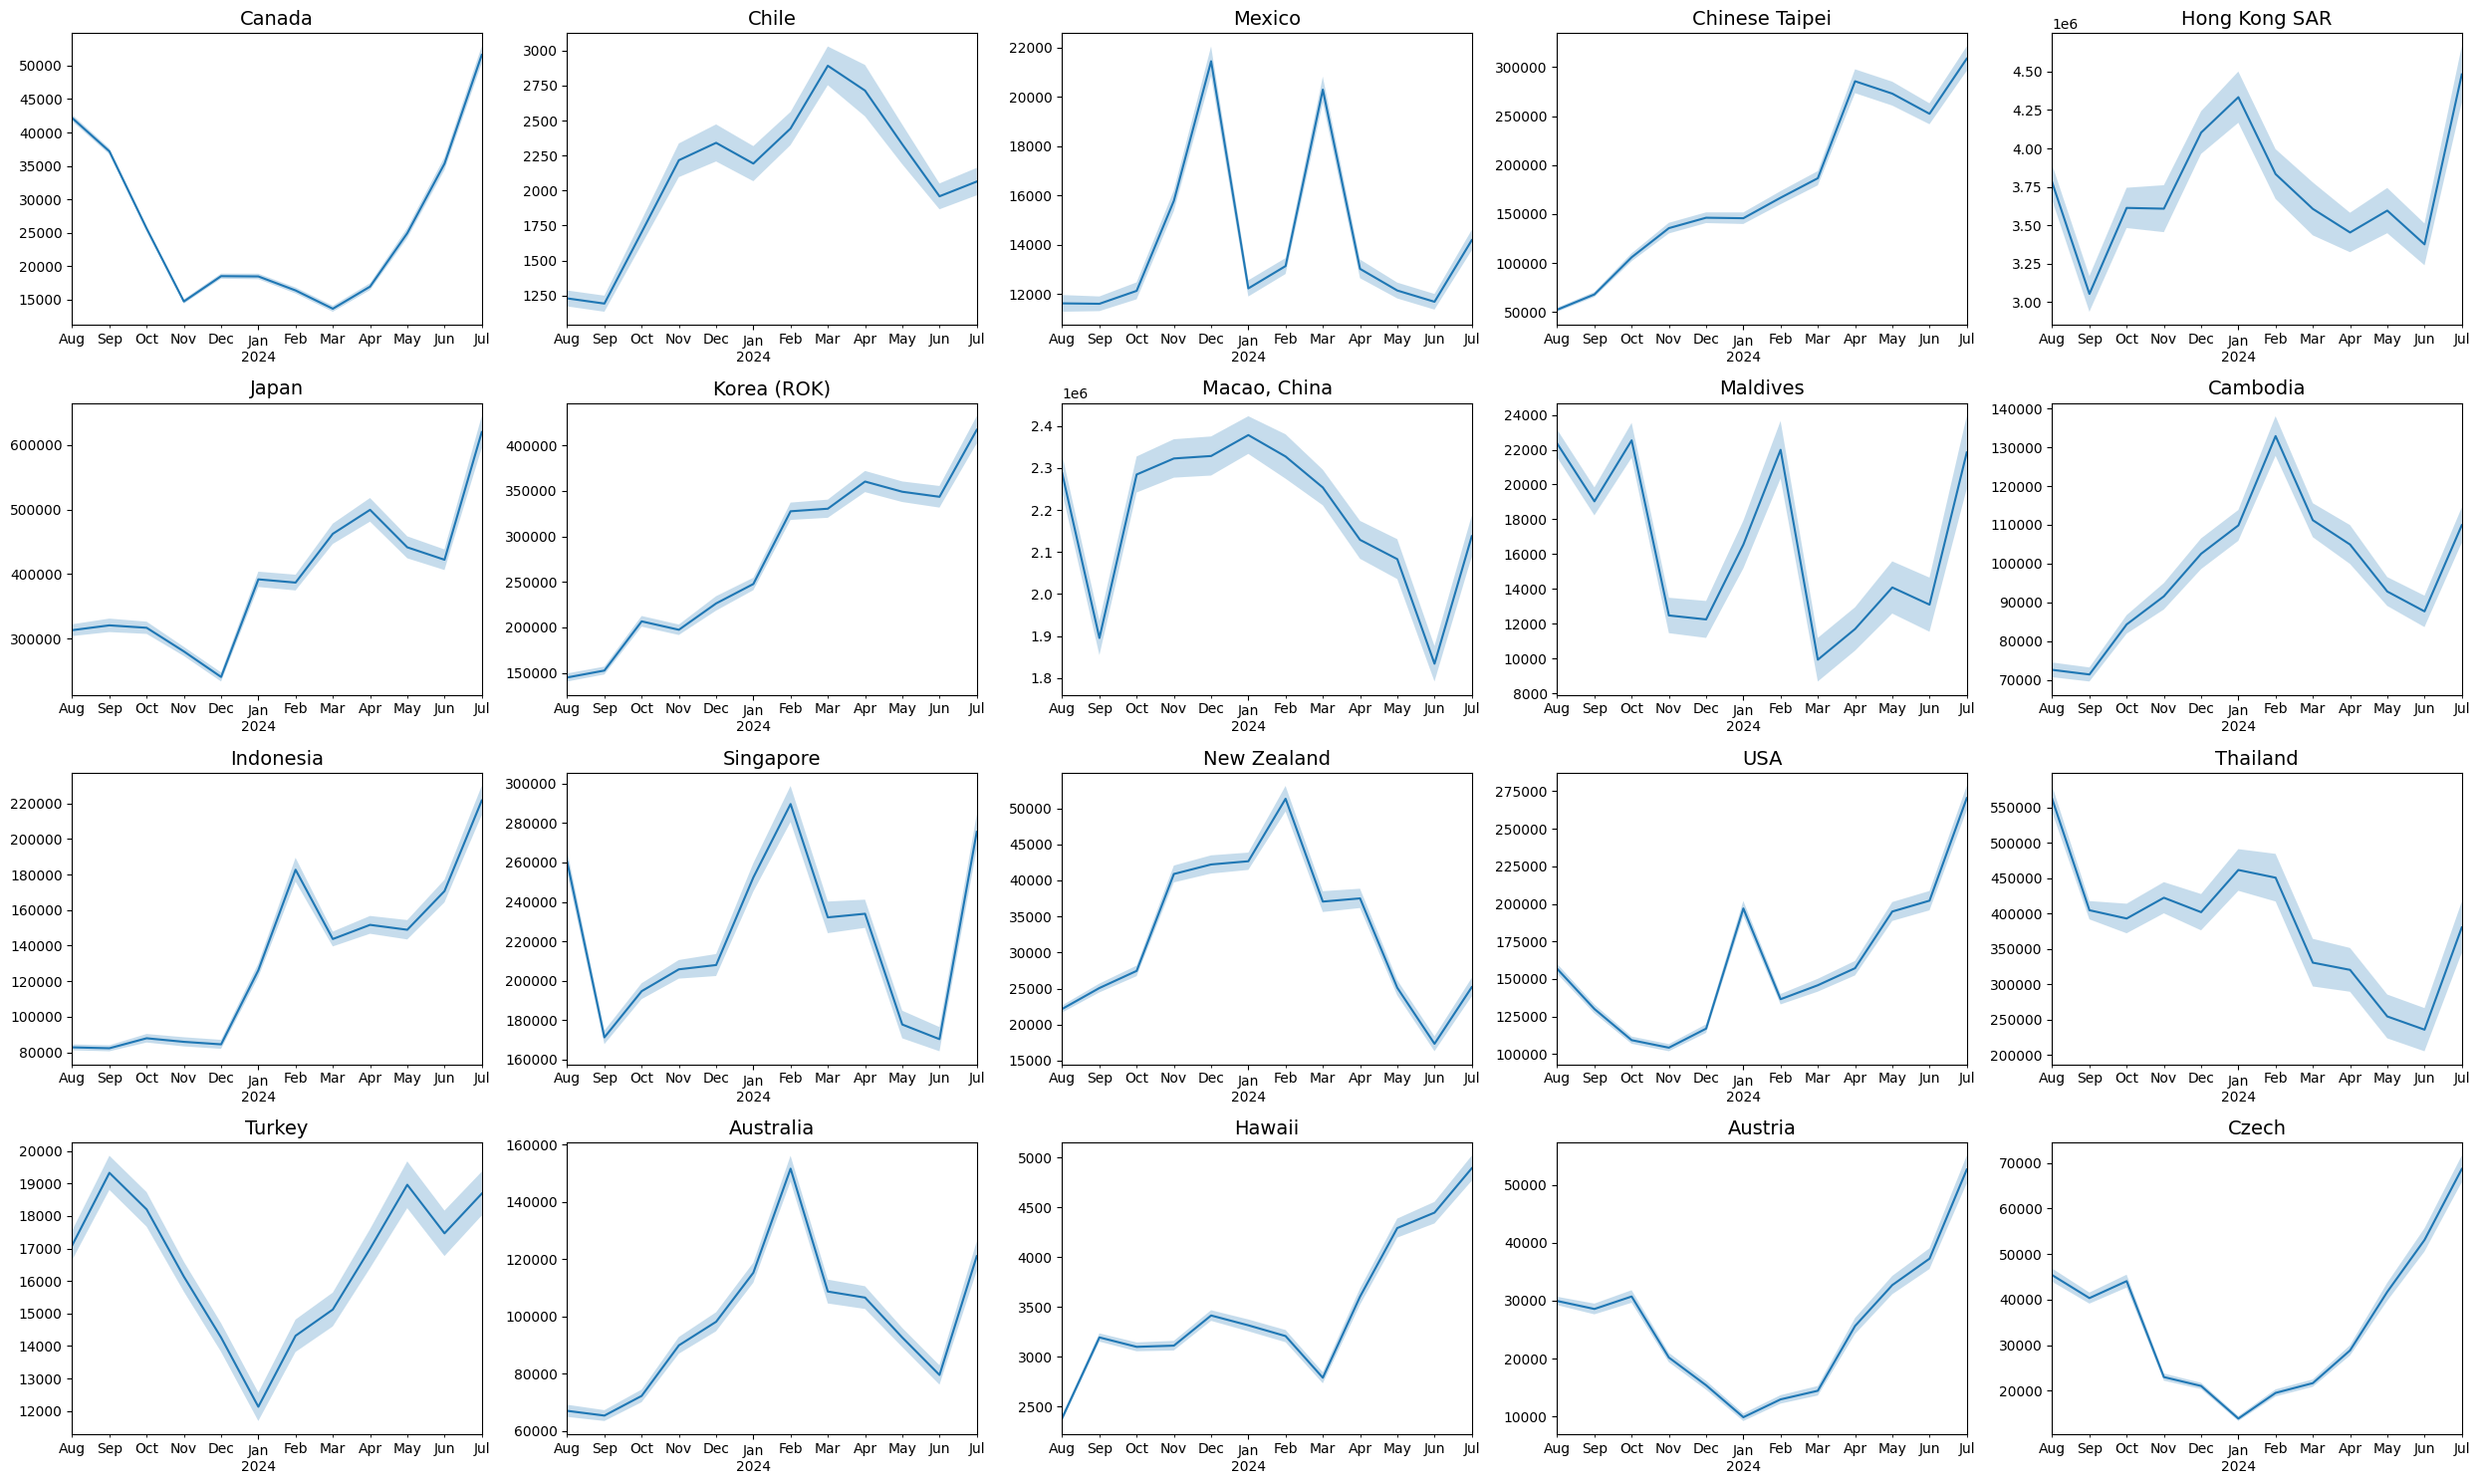

In [404]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 15))

for i, (country, country_df) in enumerate(all_data.items()):
    row, col = i // 5, i % 5
    ax = axes[row, col]
    # print(row, col)

    pred_df = pd.DataFrame({'VisitorArrivals': final_pred[i]}, index=dt[i])
    # pred_df
    pred_df = pred_df[pred_df.index > '2023-07-01']
    pred_df['VisitorArrivals'].plot(ax=ax)
    ax.fill_between(pred_df.index, interval_df[country+'Lower'].values, interval_df[country+'Upper'].values, alpha=.25)

    ax.set_title(country, fontsize=14)
    ax.set_xlabel('')
    # ax.axvline(start_date, color='black')

plt.tight_layout()
plt.show()